In [11]:
from utils_clustering import *
from utils_survival import *
from utils_evaluation import *
import pandas as pd
import numpy as np
import os
import sys
import pickle
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold



# Load data
  

test_data = pd.read_csv('aml original data/clinical_test.csv', delimiter=',')
train_data = pd.read_csv('aml original data/clinical_train.csv', delimiter=',')
methods = ['DISC_union', 'DISC_intersection', 'CASet_intersection', 'CASet_union', 'BD','1BD', '2BD', 'AD', 'CD', 'PD', 'PCD', 'MLTD', 'MP3_union', 'MP3_sigmoid', 'MP3_intersection', 'MP3_geometric']
directory ='GEN/Results/survival'
stage = 'wo_Stage'
thresh = 't = 0.02'
if not os.path.exists(directory + '/' + thresh + '/clinicaldata_wclusterlabels.csv'):
    clinical_data = pd.read_csv('aml original data/AML_clinic.csv', delimiter=',')
else:
    clinical_data = pd.read_csv(directory + '/' + thresh + '/clinicaldata_wclusterlabels.csv', delimiter=',')

# create paths for saving results
if not os.path.exists(directory + '/' + thresh + '/'):
    os.makedirs(directory + '/' + thresh + '/')
if not os.path.exists(directory + '/' + thresh + '/KM/'):
    os.makedirs(directory + '/' + thresh + '/KM/')
if not os.path.exists(directory + '/' + thresh + '/KM/KM train/'):
    os.makedirs(directory + '/' + thresh + '/KM/KM train/')
if not os.path.exists(directory + '/' + thresh + '/KM/KM test/'):
    os.makedirs(directory + '/' + thresh + '/KM/KM test/')
if not os.path.exists(directory + '/' + thresh + '/' + stage + '/'):
    os.makedirs(directory + '/' + thresh + '/' + stage + '/')
if not os.path.exists(directory + '/' + thresh + '/' + stage + '/KM PI/'):
    os.makedirs(directory + '/' + thresh + '/' + stage + '/KM PI/')
if not os.path.exists(directory + '/' + thresh + '/opt/'):
    os.makedirs(directory + '/' + thresh + '/opt/')

In [ ]:
#merge clinical data with train and test data
clinical_data = pd.read_csv(directory + '/' + thresh + '/clinicaldata_wclusterlabels.csv', delimiter=',')

clinical_data['VitalStatus'] = clinical_data['VitalStatus'].replace('Dead NOS',1)
clinical_data['VitalStatus'] = clinical_data['VitalStatus'].replace('Alive NOS',0)

clinical_data.to_csv(directory + '/' + thresh + '/clinicaldata_wclusterlabels.csv', index=False)
train_data = train_data[['sample']]
test_data = test_data[['sample']]
cd_train = pd.merge(clinical_data, train_data, on='sample', how='inner')
cd_test = pd.merge(clinical_data, test_data, on='sample', how='inner')
cd_train.to_csv(directory + '/' + thresh + '/clinicaldata_train.csv', index=False)
cd_test.to_csv(directory + '/' + thresh + '/clinicaldata_test.csv', index=False)

In [117]:
genome = ['EZH2', 'GATA2', 'TP53', 'STAG2', 'IDH1', 'ETV6', 'SRSF2', 'U2AF1', 'DNMT3A', 'SF3B1', 'FLT3', 'PTPN11', 'NRAS', 'CSF3R', 'IDH2', 'PPM1D', 'CBL', 'MYC', 'KRAS', 'KIT', 'PHF6', 'SMC3', 'ASXL1', 'BCOR', 'SETBP1', 'TET2', 'NPM1', 'WT1', 'RUNX1', 'FLT3-ITD', 'JAK2']

# Placeholder DataFrame for the counts
gene_counts = pd.DataFrame(columns=['gene', 'count_0', 'count_1'])

# Assuming cd_train is your data
# ...

for gene in genome:
    counts = cd_train[gene].value_counts()
    gene_counts = gene_counts.append({
        'gene': gene,
        'count_0': counts.get(0, 0),  # get() returns 0 if the key is not found
        'count_1': counts.get(1, 0)
    }, ignore_index=True)

# Display the DataFrame
print(gene_counts)


        gene count_0 count_1
0       EZH2      83       3
1      GATA2      84       2
2       TP53      76      10
3      STAG2      84       2
4       IDH1      72      14
5       ETV6      85       1
6      SRSF2      72      14
7      U2AF1      81       5
8     DNMT3A      55      31
9      SF3B1      80       6
10      FLT3      69      17
11    PTPN11      72      14
12      NRAS      54      32
13     CSF3R      85       1
14      IDH2      65      21
15     PPM1D      84       2
16       CBL      85       1
17       MYC      85       1
18      KRAS      74      12
19       KIT      82       4
20      PHF6      84       2
21      SMC3      86       0
22     ASXL1      77       9
23      BCOR      84       2
24    SETBP1      83       3
25      TET2      76      10
26      NPM1      46      40
27       WT1      72      14
28     RUNX1      67      19
29  FLT3-ITD      58      28
30      JAK2      86       0


/var/folders/cl/99v281453pv_d_pjwvv_46740000gp/T/ipykernel_80533/4092105171.py:11: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  gene_counts = gene_counts.append({
/var/folders/cl/99v281453pv_d_pjwvv_46740000gp/T/ipykernel_80533/4092105171.py:11: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  gene_counts = gene_counts.append({
/var/folders/cl/99v281453pv_d_pjwvv_46740000gp/T/ipykernel_80533/4092105171.py:11: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  gene_counts = gene_counts.append({
/var/folders/cl/99v281453pv_d_pjwvv_46740000gp/T/ipykernel_80533/4092105171.py:11: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  gene_counts = gene_coun

In [131]:
# Filter genes to ensure at least 20% representation in both categories
filtered_genes = gene_counts[
    (gene_counts['count_1'] >= 0.10 * (gene_counts['count_1'] + gene_counts['count_0'])) &
    (gene_counts['count_0'] >= 0.10 * (gene_counts['count_1'] + gene_counts['count_0']))
]

# Display the filtered DataFrame
print(filtered_genes)

        gene count_0 count_1
2       TP53      76      10
4       IDH1      72      14
6      SRSF2      72      14
8     DNMT3A      55      31
10      FLT3      69      17
11    PTPN11      72      14
12      NRAS      54      32
14      IDH2      65      21
18      KRAS      74      12
22     ASXL1      77       9
25      TET2      76      10
26      NPM1      46      40
27       WT1      72      14
28     RUNX1      67      19
29  FLT3-ITD      58      28


In [12]:
from lifelines import CoxPHFitter
import pandas as pd

# Placeholder data
# cd_train = pd.read_csv("your_data.csv")
# Assuming that 1 in 'VitalStatus' indicates event (death) and 0 indicates censored
clinical_data = pd.read_csv(directory + '/' + thresh + '/clinicaldata_wclusterlabels.csv', delimiter=',')
train_data = train_data[['sample']]
test_data = test_data[['sample']]
cd_train = pd.merge(clinical_data, train_data, on='sample', how='inner')


# List of genes

# Initialize a dataframe to store results
# Initialize a dataframe to store results
results = pd.DataFrame(columns=['gene', 'coef', 'p', 'se(coef)', 
                                'coef lower 95%', 'coef upper 95%', 
                                'z', 'exp(coef)', 
                                'exp(coef) lower 95%', 'exp(coef) upper 95%'])

# Univariate Cox Regression
for gene in genome:
    #exception
    try:
        cph = CoxPHFitter()
        cph.fit(cd_train[['Survival in days', 'VitalStatus', gene]], duration_col='Survival in days', event_col='VitalStatus')
        summary = cph.summary
        results = results.append({
            'gene': gene,
            'coef': summary['coef'].values[0],
            'p': summary['p'].values[0],
            'se(coef)': summary['se(coef)'].values[0],
            'coef lower 95%': summary['coef lower 95%'].values[0],
            'coef upper 95%': summary['coef upper 95%'].values[0],
            'z': summary['z'].values[0],
            'exp(coef)': summary['exp(coef)'].values[0],
            'exp(coef) lower 95%': summary['exp(coef) lower 95%'].values[0],
            'exp(coef) upper 95%': summary['exp(coef) upper 95%'].values[0]
        }, ignore_index=True)
    except:
        continue

# Display results
print(results.sort_values(by='p'))


/var/folders/cl/99v281453pv_d_pjwvv_46740000gp/T/ipykernel_80533/3943734626.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append({
/var/folders/cl/99v281453pv_d_pjwvv_46740000gp/T/ipykernel_80533/3943734626.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append({
/var/folders/cl/99v281453pv_d_pjwvv_46740000gp/T/ipykernel_80533/3943734626.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append({
/Users/Lau/anaconda3/lib/python3.10/site-packages/lifelines/utils/__init__.py:1122: ConvergenceWarning: Column STAG2 have very low variance when conditioned on death event present or not. This may harm convergence. This could be a form of 'complete separation'. For

        gene       coef         p     se(coef)  coef lower 95%  \
2       TP53   1.068927  0.002793     0.357542        0.368158   
23    SETBP1   1.721234  0.005537     0.620485        0.505105   
15     PPM1D   2.054829  0.006088     0.749119        0.586583   
10      FLT3  -1.053670  0.025735     0.472458       -1.979671   
0       EZH2   1.300038  0.033759     0.612378        0.099800   
25      NPM1  -0.613272  0.034563     0.290176       -1.182008   
17       MYC   1.848911  0.075703     1.040949       -0.191311   
5       ETV6   1.677911  0.105033     1.035154       -0.350953   
6      SRSF2  -0.521987  0.200645     0.407892       -1.321441   
28  FLT3-ITD   0.365439  0.220308     0.298145       -0.218914   
19       KIT  -1.004520  0.320608     1.011387       -2.986803   
9      SF3B1   0.554307  0.356905     0.601672       -0.624948   
27     RUNX1   0.248782  0.455187     0.333133       -0.404147   
14      IDH2  -0.212433  0.511979     0.323950       -0.847364   
26       W

/var/folders/cl/99v281453pv_d_pjwvv_46740000gp/T/ipykernel_80533/3943734626.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append({
/var/folders/cl/99v281453pv_d_pjwvv_46740000gp/T/ipykernel_80533/3943734626.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append({
/var/folders/cl/99v281453pv_d_pjwvv_46740000gp/T/ipykernel_80533/3943734626.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append({
/var/folders/cl/99v281453pv_d_pjwvv_46740000gp/T/ipykernel_80533/3943734626.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append({
/var/folders/cl/99v2

In [18]:
# Display results
print(results.sort_values(by='p'))
results.to_csv(directory + '/' + thresh + '/univariate_cox.csv', index=False)
# Filter results
filtered_results = results[results['p'] <= 0.25]
filtered_results.to_csv(directory +  '/' + thresh + '/filtered_univariate_cox.csv', index=False)
# Display filtered results
print(filtered_results.sort_values(by='p'))

        gene       coef         p     se(coef)  coef lower 95%  \
2       TP53   1.068927  0.002793     0.357542        0.368158   
23    SETBP1   1.721234  0.005537     0.620485        0.505105   
15     PPM1D   2.054829  0.006088     0.749119        0.586583   
10      FLT3  -1.053670  0.025735     0.472458       -1.979671   
0       EZH2   1.300038  0.033759     0.612378        0.099800   
25      NPM1  -0.613272  0.034563     0.290176       -1.182008   
17       MYC   1.848911  0.075703     1.040949       -0.191311   
5       ETV6   1.677911  0.105033     1.035154       -0.350953   
6      SRSF2  -0.521987  0.200645     0.407892       -1.321441   
28  FLT3-ITD   0.365439  0.220308     0.298145       -0.218914   
19       KIT  -1.004520  0.320608     1.011387       -2.986803   
9      SF3B1   0.554307  0.356905     0.601672       -0.624948   
27     RUNX1   0.248782  0.455187     0.333133       -0.404147   
14      IDH2  -0.212433  0.511979     0.323950       -0.847364   
26       W

In [20]:
genome = list(filtered_results['gene'])

        gene count_0 count_1
2       TP53      76      10
4       IDH1      72      14
6      SRSF2      72      14
8     DNMT3A      55      31
10      FLT3      69      17
11    PTPN11      72      14
12      NRAS      54      32
14      IDH2      65      21
18      KRAS      74      12
22     ASXL1      77       9
25      TET2      76      10
26      NPM1      46      40
27       WT1      72      14
28     RUNX1      67      19
29  FLT3-ITD      58      28


In [101]:

cph = CoxPHFitter().fit(cd_train_enconder, duration_col='Survival in days', event_col='VitalStatus')

cph.print_summary()

summary = cph.summary
summary.to_csv(directory +  '/' + thresh + "/summary_cph_gene.csv", index=True)

results = proportional_hazard_test(cph, cd_train_enconder, time_transform='rank')
results_df = results.summary
print(results_df)
# Save results to CSV
results_df.to_csv(directory +  '/' + thresh + "/schoenfeld_test_results_gene.csv", index = True)

<lifelines.CoxPHFitter: fitted with 86 total observations, 34 right-censored observations>
             duration col = 'Survival in days'
                event col = 'VitalStatus'
      baseline estimation = breslow
   number of observations = 86
number of events observed = 52
   partial log-likelihood = -179.08
         time fit was run = 2023-10-13 14:27:15 UTC

---
              coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                           
age           0.03       1.03       0.01            -0.00             0.05                 1.00                 1.06
maxCCF        1.38       3.96       1.15            -0.87             3.62                 0.42                37.48
Gender=Male   0.17       1.19       0.37            -0.56             0.90                 0.57                 2.46
TP53          1.02       2.77       0.46             0.11             1.93                 1.12                 6.86
IDH1          0.11       1.12       0.48            -0.83             1.05                 0.44                 2.84
SRSF2        -0.88       0.41       0.56            -1.98             0.21                 0.14                 1.24
DNMT3A        0.03       1.03       0.34            -0.63             0.69                 0.53                 2.00
FLT3         -1.01       0.36       0.55            -2.09             0.06                 0.12                 1.06
PTPN11        0.71       2.04       0.54            -0.34             1.77                 0.71                 5.85
NRAS         -0.37       0.69       0.40            -1.16             0.42                 0.31                 1.52
IDH2         -0.48       0.62       0.38            -1.23             0.26                 0.29                 1.30
KRAS          0.13       1.14       0.51            -0.87             1.12                 0.42                 3.07
ASXL1        -0.08       0.92       0.69            -1.43             1.26                 0.24                 3.54
TET2         -0.13       0.88       0.50            -1.11             0.85                 0.33                 2.35
NPM1         -1.05       0.35       0.38            -1.79            -0.30                 0.17                 0.74
WT1           0.13       1.14       0.44            -0.73             0.98                 0.48                 2.66
RUNX1        -0.25       0.78       0.50            -1.24             0.73                 0.29                 2.08
FLT3-ITD      0.48       1.62       0.35            -0.21             1.17                 0.81                 3.24

              cmp to     z    p   -log2(p)
covariate                                 
age             0.00  1.88 0.06       4.04
maxCCF          0.00  1.20 0.23       2.12
Gender=Male     0.00  0.46 0.65       0.63
TP53            0.00  2.20 0.03       5.15
IDH1            0.00  0.23 0.82       0.29
SRSF2           0.00 -1.58 0.11       3.13
DNMT3A          0.00  0.09 0.92       0.11
FLT3            0.00 -1.85 0.06       3.95
PTPN11          0.00  1.33 0.18       2.44
NRAS            0.00 -0.92 0.36       1.49
IDH2            0.00 -1.27 0.20       2.30
KRAS            0.00  0.25 0.80       0.32
ASXL1           0.00 -0.12 0.91       0.14
TET2            0.00 -0.25 0.80       0.32
NPM1            0.00 -2.76 0.01       7.43
WT1             0.00  0.29 0.77       0.38
RUNX1           0.00 -0.50 0.61       0.70
FLT3-ITD        0.00  1.35 0.18       2.51
---
Concordance = 0.72
Partial AIC = 394.16
log-likelihood ratio test = 31.19 on 18 df
-log2(p) of ll-ratio test = 5.19

             test_statistic         p  -log2(p)
ASXL1              0.965421  0.325825  1.617832
DNMT3A             0.957221  0.327888  1.608725
FLT3               1.458378  0.227188  2.138039
FLT3-ITD           0.023582  0.877953  0.187784
Gender=Male        2.930493  0.086921  3.524152
IDH1               3.300223  0.069270  3.851615
IDH2               2.582738  0.108035  3.210434
KRAS               0.336919  0.561613  0.832352
NPM1               0.473768  0.491259  1.025445
NRAS               4.326569  0.037522  4.736127
PTPN11             2.920616  0.087454  3.515324
RUNX1              0.133058  0.715283  0.483415
SRSF2              2.013358  0.155920  2.681123
TET2               0.001501  0.969096  0.045289
TP53               1.300477  0.254126  1.976383
WT1                0.275137  0.599906  0.737191
age                0.289518  0.590529  0.759919
maxCCF             2.804808  0.093982  3.411470


In [102]:
# I want to filter out the features that are not significant p<0.25
filtered_summary = summary[summary['p'] <= 0.25]
filtered_pph = results_df[results_df['p'] > 0.05]

#I wan to merge the with the index in common
filtered_summary = filtered_summary.reset_index()
filtered_pph = filtered_pph.reset_index()
filtered_summary = filtered_summary.rename(columns={'index': 'covariate'})
filtered_pph = filtered_pph.rename(columns={'index': 'covariate'})
filtered_summary = filtered_summary.set_index('covariate')
filtered_pph = filtered_pph.set_index('covariate')

#I want to merge the two dataframes
merged = pd.merge(filtered_summary, filtered_pph, on='covariate', how='inner')
filtered_pph.to_csv(directory +  '/' + thresh + "/covariates_clinical_and_gene.csv", index = True)



In [133]:
filtered_genes.to_csv(directory +  '/' + thresh + "/covariates_gene.csv", index = False)


In [92]:
from lifelines.statistics import proportional_hazard_test

# List of genes
genome = list(filtered_genes['gene'])
new_df = cd_train[['age','Gender', 'Survival in days', 'VitalStatus'] + genome]
cd_train= convert_to_category(new_df,columns=['Gender'])
cd_train_enconder = convert_to_OneHotEncoder(cd_train)
cph = CoxPHFitter()
cph.fit(cd_train_enconder, duration_col='Survival in days', event_col='VitalStatus')

cph.print_summary()

summary = cph.summary
summary.to_csv(directory +  '/' + thresh + "/summary_cph_gene.csv", index=True)

results = proportional_hazard_test(cph, cd_train_enconder, time_transform='rank')
results_df = results.summary

# Save results to CSV
results_df.to_csv(directory +  '/' + thresh + "/schoenfeld_test_results.csv", index = True)

KeyError: "['TP53', 'IDH1', 'SRSF2', 'DNMT3A', 'FLT3', 'PTPN11', 'NRAS', 'IDH2', 'KRAS', 'ASXL1', 'TET2', 'NPM1', 'WT1', 'RUNX1', 'FLT3-ITD'] not in index"

In [49]:
results_df

,test_statistic,p,-log2(p)
ASXL1,0.099860,0.751998,0.411199
DNMT3A,0.650900,0.419791,1.252257
FLT3,0.594798,0.440570,1.182558
FLT3-ITD,0.087273,0.767673,0.381437
Gender=Male,3.139809,0.076403,3.710231
IDH1,2.298563,0.129494,2.949046
IDH2,2.554445,0.109984,3.184629
KRAS,0.017401,0.895054,0.159953
NPM1,0.325808,0.568138,0.815687
NRAS,2.608373,0.106301,3.233776


### Train and Test generation

In [1]:
from sklearn.model_selection import train_test_split
import pandas as pd
#train and test dataset 80% and 20% respectively
clinical_data = pd.read_csv('aml original data/AML_clinic.csv', delimiter=',')
new = clinical_data.copy()
y = new[['VitalStatus']]
X = new.drop(['VitalStatus'], axis=1)
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.3, random_state=42
                                                    , stratify=y)

# merge train and test data
train_data = pd.concat([X_train, y_train], axis=1)
test_data = pd.concat([X_test, y_test], axis=1)

train_data.to_csv('aml original data/clinical_train.csv', index=False)
test_data.to_csv('aml original data/clinical_test.csv', index=False)

In [3]:
# 10 folds from stratified k fold

skf = StratifiedKFold(n_splits=10, random_state=42, shuffle=True)
cd_train = pd.read_csv('aml original data/clinical_train.csv', delimiter=',')

#apply stratified k fold
train = cd_train.copy()

y = cd_train[['VitalStatus']]

X = train.drop(['VitalStatus'], axis=1)
for i, (train_index, test_index) in enumerate(skf.split(X,y)):
    train_data = train.iloc[train_index]
    train_data.to_csv('aml original data/clinical_train_fold' + str(i) + '.csv', index=False)



### ADD GENOTYPE


In [3]:

with open("tree_map.pickle", "rb") as f:
    tree_map = pickle.load(f)

print(tree_map)

{'AML-01-001': {278: AnyNode(data='278', label='Root', matching_label='Root', name=0, node_id='4'), 291: AnyNode(data='291', label='Root', matching_label='Root', name=0, node_id='4')}, 'AML-02-001': {272: AnyNode(data='272', label='Root', matching_label='Root', name=0, node_id='5')}, 'AML-03-001': {298: AnyNode(data='298', label='Root', matching_label='Root', name=0, node_id='2')}, 'AML-04-001': {235: AnyNode(data='235', label='Root', matching_label='Root', name=0, node_id='12'), 244: AnyNode(data='244', label='Root', matching_label='Root', name=0, node_id='12'), 248: AnyNode(data='248', label='Root', matching_label='Root', name=0, node_id='12')}, 'AML-05-001': {219: AnyNode(data='219', label='Root', matching_label='Root', name=0, node_id='5')}, 'AML-06-001': {247: AnyNode(data='247', label='Root', matching_label='Root', name=0, node_id='5')}, 'AML-07-001': {221: AnyNode(data='221', label='Root', matching_label='Root', name=0, node_id='3'), 347: AnyNode(data='347', label='Root', matchi

In [8]:
from anytree import Node, RenderTree

for j, k in tree_map.items():
    for i in k.values():
        print(RenderTree(i))

AnyNode(data='278', label='Root', matching_label='Root', name=0, node_id='4')
└── AnyNode(data='0', label='FLT3-ITD', matching_label='FLT3-ITD', name=13, node_id='0', size_percent=0.18100000000000002)
    └── AnyNode(data='2', label='WT1', matching_label='WT1', name=11, node_id='2', size_percent=0.113)
        └── AnyNode(data='1', label='NPM1', matching_label='NPM1', name=4, node_id='1', size_percent=0.39799999999999996)
AnyNode(data='291', label='Root', matching_label='Root', name=0, node_id='4')
└── AnyNode(data='0', label='FLT3-ITD', matching_label='FLT3-ITD', name=13, node_id='0', size_percent=0.04)
    └── AnyNode(data='2', label='WT1', matching_label='WT1', name=11, node_id='2', size_percent=0.315)
        └── AnyNode(data='1', label='NPM1', matching_label='NPM1', name=4, node_id='1', size_percent=0.621)
AnyNode(data='272', label='Root', matching_label='Root', name=0, node_id='5')
└── AnyNode(data='0', label='DNMT3A', matching_label='DNMT3A', name=9, node_id='0', size_percent=0.

In [10]:
clinical_data = pd.read_csv('Results/survival' + '/' + thresh + '/clinicaldata_wclusterlabels.csv', delimiter=',')
clinical_data.set_index('sample', inplace=True)

In [11]:
# Step 1: Extract Mutation Names
from anytree import PreOrderIter

all_mutations = set()
for sample, trees in tree_map.items():
    for tree_id, tree in trees.items():
        for node in PreOrderIter(tree):  # Traverse tree
            all_mutations.add(node.matching_label)  # or node.label

# Step 2: Update Dataset
for mutation in all_mutations:
    clinical_data[mutation] = 0  # Add a column for each mutation with initial value 0

# Step 3 & 4: Traverse Trees and Update Dataset
for sample, trees in tree_map.items():
    for tree_id, tree in trees.items():
        for node in PreOrderIter(tree):  # Traverse tree
            mutation = node.matching_label  # or node.label
            if mutation in clinical_data.columns:
                clinical_data.loc[sample, mutation] = 1  # Update dataset

clinical_data

,PriorMalig,Chemo,XRT,stAML,untreated,Gender,VitalStatus,age,N_subclone,Diagnosis,...,ASXL1,BCOR,SETBP1,TET2,NPM1,WT1,RUNX1,FLT3-ITD,Root,JAK2
sample,,,,,,,,,,,,,,,,,,,,,
AML-01-001,Yes,No,Yes,stAML,untreated,Male,1,66,4,AML,...,0,0,0,0,1,1,0,1,1,0
AML-02-001,Yes,No,No,stAML,untreated,Male,1,84,5,AML,...,0,0,0,0,0,0,1,0,1,1
AML-03-001,No,No,No,dnAML,untreated,Female,1,59,2,AML,...,0,0,0,0,1,0,0,1,1,0
AML-04-001,Yes,No,Yes,stAML,RR,Male,1,76,9,AML,...,0,0,0,0,0,1,0,1,1,0
AML-05-001,No,No,No,dnAML,untreated,Female,1,48,6,AMML,...,0,0,0,0,0,0,0,1,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
AML-119-001,No,No,No,dnAML,untreated,Male,0,67,3,AML,...,0,0,0,0,1,0,0,0,1,0
AML-120-001,Yes,No,No,dnAML,treated,Male,0,84,3,AMML,...,0,0,0,0,0,0,1,0,1,0
AML-121-001,Yes,Yes,No,stAML,untreated,Female,0,82,5,AMOL,...,0,0,0,0,1,0,0,0,1,0


In [19]:
#drop column 'Root' from clinical_data

clinical_data.drop('Root', axis=1)
clinical_data

,PriorMalig,Chemo,XRT,stAML,untreated,Gender,VitalStatus,age,N_subclone,Diagnosis,...,ASXL1,BCOR,SETBP1,TET2,NPM1,WT1,RUNX1,FLT3-ITD,Root,JAK2
sample,,,,,,,,,,,,,,,,,,,,,
AML-01-001,Yes,No,Yes,stAML,untreated,Male,1,66,4,AML,...,0,0,0,0,1,1,0,1,1,0
AML-02-001,Yes,No,No,stAML,untreated,Male,1,84,5,AML,...,0,0,0,0,0,0,1,0,1,1
AML-03-001,No,No,No,dnAML,untreated,Female,1,59,2,AML,...,0,0,0,0,1,0,0,1,1,0
AML-04-001,Yes,No,Yes,stAML,RR,Male,1,76,9,AML,...,0,0,0,0,0,1,0,1,1,0
AML-05-001,No,No,No,dnAML,untreated,Female,1,48,6,AMML,...,0,0,0,0,0,0,0,1,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
AML-119-001,No,No,No,dnAML,untreated,Male,0,67,3,AML,...,0,0,0,0,1,0,0,0,1,0
AML-120-001,Yes,No,No,dnAML,treated,Male,0,84,3,AMML,...,0,0,0,0,0,0,1,0,1,0
AML-121-001,Yes,Yes,No,stAML,untreated,Female,0,82,5,AMOL,...,0,0,0,0,1,0,0,0,1,0


In [15]:
all_mutations.discard('Root')
list_mut = list(all_mutations)
print(list_mut)

['EZH2', 'GATA2', 'TP53', 'STAG2', 'IDH1', 'ETV6', 'SRSF2', 'U2AF1', 'DNMT3A', 'SF3B1', 'FLT3', 'PTPN11', 'NRAS', 'CSF3R', 'IDH2', 'PPM1D', 'CBL', 'MYC', 'KRAS', 'KIT', 'PHF6', 'SMC3', 'ASXL1', 'BCOR', 'SETBP1', 'TET2', 'NPM1', 'WT1', 'RUNX1', 'FLT3-ITD', 'JAK2']


In [20]:
clinical_data.reset_index(inplace=True)
clinical_data


,sample,PriorMalig,Chemo,XRT,stAML,untreated,Gender,VitalStatus,age,N_subclone,...,ASXL1,BCOR,SETBP1,TET2,NPM1,WT1,RUNX1,FLT3-ITD,Root,JAK2
0,AML-01-001,Yes,No,Yes,stAML,untreated,Male,1,66,4,...,0,0,0,0,1,1,0,1,1,0
1,AML-02-001,Yes,No,No,stAML,untreated,Male,1,84,5,...,0,0,0,0,0,0,1,0,1,1
2,AML-03-001,No,No,No,dnAML,untreated,Female,1,59,2,...,0,0,0,0,1,0,0,1,1,0
3,AML-04-001,Yes,No,Yes,stAML,RR,Male,1,76,9,...,0,0,0,0,0,1,0,1,1,0
4,AML-05-001,No,No,No,dnAML,untreated,Female,1,48,6,...,0,0,0,0,0,0,0,1,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
118,AML-119-001,No,No,No,dnAML,untreated,Male,0,67,3,...,0,0,0,0,1,0,0,0,1,0
119,AML-120-001,Yes,No,No,dnAML,treated,Male,0,84,3,...,0,0,0,0,0,0,1,0,1,0
120,AML-121-001,Yes,Yes,No,stAML,untreated,Female,0,82,5,...,0,0,0,0,1,0,0,0,1,0
121,AML-122-001,Yes,No,No,dnAML,treated,Male,0,77,2,...,0,0,0,0,1,0,0,0,1,0


In [21]:
clinical_data.to_csv(directory + '/' + thresh + '/clinicaldata_wclusterlabels.csv', index=False)

### Change of thresh

In [105]:
#merge clinical data with train and test data
clinical_data = pd.read_csv(directory + '/' + thresh + '/clinicaldata_wclusterlabels.csv', delimiter=',')

clinical_data['VitalStatus'] = clinical_data['VitalStatus'].replace('Dead NOS',1)
clinical_data['VitalStatus'] = clinical_data['VitalStatus'].replace('Alive NOS',0)

clinical_data.to_csv(directory + '/' + thresh + '/clinicaldata_wclusterlabels.csv', index=False)
train_data = train_data[['sample']]
test_data = test_data[['sample']]
cd_train = pd.merge(clinical_data, train_data, on='sample', how='inner')
cd_test = pd.merge(clinical_data, test_data, on='sample', how='inner')
cd_train.to_csv(directory + '/' + thresh + '/clinicaldata_train.csv', index=False)
cd_test.to_csv(directory + '/' + thresh + '/clinicaldata_test.csv', index=False)

In [135]:
### KM plots
methods = ['DISC_union', 'DISC_intersection', 'CASet_intersection', 'CASet_union', 'BD','1BD', '2BD', 'AD', 'CD', 'PD', 'PCD', 'MLTD', 'MP3_union', 'MP3_sigmoid', 'MP3_intersection', 'MP3_geometric']
clinical_col = ['age','Gender','maxCCF']
gene = filtered_genes['gene'].tolist()

new = gene + clinical_col + methods

In [110]:
### KM plots
methods = ['DISC_union', 'DISC_intersection', 'CASet_intersection', 'CASet_union', 'BD','1BD', '2BD', 'AD', 'CD', 'PD', 'PCD', 'MLTD', 'MP3_union', 'MP3_sigmoid', 'MP3_intersection', 'MP3_geometric']
clinical_col = ['age','Gender','maxCCF']
gene = filtered_pph.index.tolist()
gene.remove('age')
gene.remove('Gender=Male')
gene.remove('maxCCF')
new = gene + clinical_col + methods
for method in new:
    kaplan_meier(clinical_data, 'Survival in days', 'VitalStatus', method, directory + '/' + thresh + '/KM/')
    kaplan_meier(cd_train, 'Survival in days', 'VitalStatus', method, directory + '/' + thresh + '/KM/KM train/')
    kaplan_meier(cd_test, 'Survival in days', 'VitalStatus', method, directory + '/' + thresh + '/KM/KM test/')

<Figure size 640x480 with 0 Axes>

In [144]:
print(filtered_genes['gene'].tolist())

['TP53', 'IDH1', 'SRSF2', 'DNMT3A', 'FLT3', 'PTPN11', 'NRAS', 'IDH2', 'KRAS', 'ASXL1', 'TET2', 'NPM1', 'WT1', 'RUNX1', 'FLT3-ITD']


### Change of Stage

In [136]:
#merge clinical data with train and test data
clinical_data = pd.read_csv(directory + '/' + thresh + '/clinicaldata_wclusterlabels.csv', delimiter=',')
train_data = train_data[['sample']]
test_data = test_data[['sample']]
cd_train = pd.merge(clinical_data, train_data, on='sample', how='inner')
cd_test = pd.merge(clinical_data, test_data, on='sample', how='inner')
cd_train.to_csv(directory + '/' + thresh + '/clinicaldata_train.csv', index=False)
cd_test.to_csv(directory + '/' + thresh + '/clinicaldata_test.csv', index=False)

In [150]:
#### Cox regression LLR and AIC without CBL , BCOR , SMC3
dfs = convert_to_category(cd_train,columns =['Gender'], method=methods)
results = {}
methods = ['DISC_union', 'DISC_intersection', 'CASet_intersection', 'CASet_union', 'BD','1BD', '2BD', 'AD', 'CD', 'PD', 'PCD', 'MLTD','MP3_union',  'MP3_sigmoid', 'MP3_intersection', 'MP3_geometric']

methods_cox = ['Only Clinical', 'Genotype'] + methods 
params = dict()
for method in methods_cox:
    print(method)
    if method == 'Only Clinical':
        filtered_df = filter_data(dfs,clinical_col + ['Survival in days', 'VitalStatus'])
    elif method == 'Genotype':
        filtered_df = filter_data(dfs,clinical_col + gene + ['Survival in days', 'VitalStatus'])
    else:
        filtered_df = filter_data(dfs,clinical_col + gene + [method, 'Survival in days', 'VitalStatus'])

    df_HE = convert_to_OneHotEncoder(filtered_df)
    cph_model = fit_cox_model(df_HE, 'Survival in days', 'VitalStatus')
    results[method] = {}
    results[method]['AIC'] = round(partial_AIC(cph_model),1)
    results[method]['Log-Likelihood'] = round(Log_Likelihood(cph_model),1)
    cph_model.print_summary()
    params[method] = cph_model.params_.shape[0]


results = pd.DataFrame(results).T
results.to_csv(directory + '/' + thresh + '/' + stage + '/Cox Results' + stage + '.csv')
results 


Only Clinical


<lifelines.CoxPHFitter: fitted with 86 total observations, 34 right-censored observations>
             duration col = 'Survival in days'
                event col = 'VitalStatus'
      baseline estimation = breslow
   number of observations = 86
number of events observed = 52
   partial log-likelihood = -191.00
         time fit was run = 2023-10-13 17:45:19 UTC

---
              coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                           
age           0.02       1.02       0.01             0.00             0.05                 1.00                 1.05
Gender=Male  -0.15       0.86       0.29            -0.72             0.41                 0.49                 1.51
maxCCF        1.72       5.58       0.88            -0.00             3.44                 1.00                31.30

              cmp to     z    p   -log2(p)
covariate                                 
age             0.00  2.13 0.03       4.92
Gender=Male     0.00 -0.53 0.60       0.74
maxCCF          0.00  1.95 0.05       4.30
---
Concordance = 0.56
Partial AIC = 388.00
log-likelihood ratio test = 7.34 on 3 df
-log2(p) of ll-ratio test = 4.02

Genotype


<lifelines.CoxPHFitter: fitted with 86 total observations, 34 right-censored observations>
             duration col = 'Survival in days'
                event col = 'VitalStatus'
      baseline estimation = breslow
   number of observations = 86
number of events observed = 52
   partial log-likelihood = -179.08
         time fit was run = 2023-10-13 17:45:19 UTC

---
              coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                           
age           0.03       1.03       0.01            -0.00             0.05                 1.00                 1.06
Gender=Male   0.17       1.19       0.37            -0.56             0.90                 0.57                 2.46
maxCCF        1.38       3.96       1.15            -0.87             3.62                 0.42                37.48
TP53          1.02       2.77       0.46             0.11             1.93                 1.12                 6.86
IDH1          0.11       1.12       0.48            -0.83             1.05                 0.44                 2.84
SRSF2        -0.88       0.41       0.56            -1.98             0.21                 0.14                 1.24
DNMT3A        0.03       1.03       0.34            -0.63             0.69                 0.53                 2.00
FLT3         -1.01       0.36       0.55            -2.09             0.06                 0.12                 1.06
PTPN11        0.71       2.04       0.54            -0.34             1.77                 0.71                 5.85
NRAS         -0.37       0.69       0.40            -1.16             0.42                 0.31                 1.52
IDH2         -0.48       0.62       0.38            -1.23             0.26                 0.29                 1.30
KRAS          0.13       1.14       0.51            -0.87             1.12                 0.42                 3.07
ASXL1        -0.08       0.92       0.69            -1.43             1.26                 0.24                 3.54
TET2         -0.13       0.88       0.50            -1.11             0.85                 0.33                 2.35
NPM1         -1.05       0.35       0.38            -1.79            -0.30                 0.17                 0.74
WT1           0.13       1.14       0.44            -0.73             0.98                 0.48                 2.66
RUNX1        -0.25       0.78       0.50            -1.24             0.73                 0.29                 2.08
FLT3-ITD      0.48       1.62       0.35            -0.21             1.17                 0.81                 3.24

              cmp to     z    p   -log2(p)
covariate                                 
age             0.00  1.88 0.06       4.04
Gender=Male     0.00  0.46 0.65       0.63
maxCCF          0.00  1.20 0.23       2.12
TP53            0.00  2.20 0.03       5.15
IDH1            0.00  0.23 0.82       0.29
SRSF2           0.00 -1.58 0.11       3.13
DNMT3A          0.00  0.09 0.92       0.11
FLT3            0.00 -1.85 0.06       3.95
PTPN11          0.00  1.33 0.18       2.44
NRAS            0.00 -0.92 0.36       1.49
IDH2            0.00 -1.27 0.20       2.30
KRAS            0.00  0.25 0.80       0.32
ASXL1           0.00 -0.12 0.91       0.14
TET2            0.00 -0.25 0.80       0.32
NPM1            0.00 -2.76 0.01       7.43
WT1             0.00  0.29 0.77       0.38
RUNX1           0.00 -0.50 0.61       0.70
FLT3-ITD        0.00  1.35 0.18       2.51
---
Concordance = 0.72
Partial AIC = 394.16
log-likelihood ratio test = 31.19 on 18 df
-log2(p) of ll-ratio test = 5.19

DISC_union


<lifelines.CoxPHFitter: fitted with 86 total observations, 34 right-censored observations>
             duration col = 'Survival in days'
                event col = 'VitalStatus'
      baseline estimation = breslow
   number of observations = 86
number of events observed = 52
   partial log-likelihood = -179.04
         time fit was run = 2023-10-13 17:45:19 UTC

---
               coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                            
age            0.03       1.03       0.02            -0.00             0.06                 1.00                 1.06
Gender=Male    0.19       1.21       0.38            -0.55             0.92                 0.58                 2.52
maxCCF         1.41       4.09       1.17            -0.88             3.70                 0.41                40.42
TP53           0.96       2.61       0.53            -0.08             2.00                 0.93                 7.37
IDH1           0.09       1.09       0.49            -0.87             1.04                 0.42                 2.83
SRSF2         -0.91       0.40       0.57            -2.03             0.20                 0.13                 1.23
DNMT3A         0.05       1.05       0.34            -0.62             0.71                 0.54                 2.04
FLT3          -1.02       0.36       0.55            -2.10             0.06                 0.12                 1.07
PTPN11         0.75       2.11       0.55            -0.34             1.83                 0.71                 6.23
NRAS          -0.30       0.74       0.49            -1.25             0.65                 0.29                 1.91
IDH2          -0.51       0.60       0.40            -1.29             0.27                 0.28                 1.32
KRAS           0.12       1.13       0.51            -0.88             1.13                 0.42                 3.09
ASXL1         -0.09       0.92       0.69            -1.44             1.26                 0.24                 3.54
TET2          -0.14       0.87       0.51            -1.13             0.85                 0.32                 2.35
NPM1          -1.06       0.35       0.45            -1.94            -0.17                 0.14                 0.84
WT1            0.12       1.12       0.48            -0.84             1.07                 0.43                 2.90
RUNX1         -0.29       0.74       0.54            -1.35             0.76                 0.26                 2.13
FLT3-ITD       0.49       1.63       0.36            -0.22             1.20                 0.80                 3.34
DISC_union=1   0.01       1.01       0.62            -1.21             1.23                 0.30                 3.41
DISC_union=2  -0.14       0.87       0.67            -1.44             1.17                 0.24                 3.22

               cmp to     z    p   -log2(p)
covariate                                  
age              0.00  1.81 0.07       3.83
Gender=Male      0.00  0.50 0.62       0.69
maxCCF           0.00  1.20 0.23       2.13
TP53             0.00  1.81 0.07       3.85
IDH1             0.00  0.18 0.86       0.22
SRSF2            0.00 -1.60 0.11       3.19
DNMT3A           0.00  0.13 0.89       0.16
FLT3             0.00 -1.85 0.06       3.94
PTPN11           0.00  1.35 0.18       2.49
NRAS             0.00 -0.63 0.53       0.91
IDH2             0.00 -1.27 0.20       2.30
KRAS             0.00  0.24 0.81       0.31
ASXL1            0.00 -0.13 0.90       0.15
TET2             0.00 -0.27 0.79       0.35
NPM1             0.00 -2.34 0.02       5.69
WT1              0.00  0.24 0.81       0.30
RUNX1            0.00 -0.55 0.58       0.78
FLT3-ITD         0.00  1.34 0.18       2.48
DISC_union=1     0.00  0.02 0.99       0.02
DISC_union=2     0.00 -0.20 0.84       0.25
---
Concordance = 0.72
Partial AIC = 398.09
log-likelihood ratio

DISC_intersection


<lifelines.CoxPHFitter: fitted with 86 total observations, 34 right-censored observations>
             duration col = 'Survival in days'
                event col = 'VitalStatus'
      baseline estimation = breslow
   number of observations = 86
number of events observed = 52
   partial log-likelihood = -169.85
         time fit was run = 2023-10-13 17:45:19 UTC

---
                       coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                    
age                    0.02       1.02       0.02            -0.02             0.06                 0.98                 1.06
Gender=Male            0.44       1.55       0.45            -0.45             1.32                 0.64                 3.75
maxCCF                 2.86      17.51       1.50            -0.08             5.80                 0.93               330.99
TP53                   0.98       2.67       0.66            -0.31             2.27                 0.73                 9.70
IDH1                   0.20       1.22       0.65            -1.09             1.48                 0.34                 4.37
SRSF2                 -1.77       0.17       1.03            -3.79             0.25                 0.02                 1.29
DNMT3A                 0.39       1.47       0.50            -0.59             1.36                 0.56                 3.91
FLT3                  -1.04       0.35       0.72            -2.45             0.36                 0.09                 1.44
PTPN11                 1.22       3.40       0.71            -0.16             2.61                 0.85                13.57
NRAS                  -0.76       0.47       0.57            -1.88             0.35                 0.15                 1.42
IDH2                   0.74       2.10       0.75            -0.72             2.21                 0.48                 9.10
KRAS                   0.78       2.18       0.59            -0.38             1.94                 0.69                 6.94
ASXL1                 -0.81       0.45       1.06            -2.88             1.27                 0.06                 3.55
TET2                 -19.09       0.00    3509.83         -6898.22          6860.05                 0.00                  inf
NPM1                  -1.03       0.36       0.45            -1.91            -0.16                 0.15                 0.85
WT1                    1.03       2.79       0.55            -0.05             2.11                 0.95                 8.21
RUNX1                 -0.02       0.98       0.59            -1.18             1.14                 0.31                 3.14
FLT3-ITD               0.62       1.86       0.50            -0.35             1.59                 0.70                 4.90
DISC_intersection=1   -1.14       0.32       0.96            -3.01             0.74                 0.05                 2.09
DISC_intersection=2   -0.32       0.73       1.44            -3.14             2.51                 0.04                12.34
DISC_intersection=3    0.04       1.04       0.88            -1.69             1.77                 0.18                 5.86
DISC_intersection=4   -2.09       0.12       1.05            -4.16            -0.03                 0.02                 0.97
DISC_intersection=5   -1.80       0.16       1.25            -4.25             0.64                 0.01                 1.90
DISC_intersection=6   -3.30       0.04       1.35            -5.95            -0.66                 0.00                 0.52
DISC_intersection=7    0.34       1.40       1.16            -1.94             2.62                 0.14                13.75
DISC_intersection=8   -0.91       0.40       1.18            -3.23             1.41                 0.04                 4.10
DISC_intersection=9    1.14       3.14       1.35            -1.51             3.79                 0

CASet_intersection


<lifelines.CoxPHFitter: fitted with 86 total observations, 34 right-censored observations>
             duration col = 'Survival in days'
                event col = 'VitalStatus'
      baseline estimation = breslow
   number of observations = 86
number of events observed = 52
   partial log-likelihood = -178.85
         time fit was run = 2023-10-13 17:45:20 UTC

---
                       coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                    
age                    0.03       1.03       0.02            -0.00             0.06                 1.00                 1.06
Gender=Male            0.17       1.18       0.38            -0.57             0.91                 0.57                 2.48
maxCCF                 1.33       3.78       1.19            -1.00             3.66                 0.37                38.75
TP53                   0.89       2.45       0.52            -0.13             1.92                 0.87                 6.84
IDH1                  -0.05       0.96       0.53            -1.09             0.99                 0.34                 2.70
SRSF2                 -0.84       0.43       0.60            -2.02             0.34                 0.13                 1.41
DNMT3A                -0.02       0.98       0.36            -0.71             0.68                 0.49                 1.97
FLT3                  -0.99       0.37       0.56            -2.08             0.10                 0.12                 1.10
PTPN11                 0.76       2.14       0.54            -0.30             1.81                 0.74                 6.14
NRAS                  -0.29       0.75       0.42            -1.11             0.52                 0.33                 1.69
IDH2                  -0.42       0.66       0.42            -1.24             0.39                 0.29                 1.48
KRAS                   0.11       1.11       0.50            -0.88             1.10                 0.42                 2.99
ASXL1                 -0.08       0.92       0.69            -1.44             1.27                 0.24                 3.57
TET2                  -0.14       0.87       0.52            -1.15             0.87                 0.32                 2.39
NPM1                  -1.13       0.32       0.41            -1.92            -0.33                 0.15                 0.72
WT1                    0.11       1.12       0.45            -0.76             0.98                 0.47                 2.67
RUNX1                 -0.24       0.79       0.53            -1.28             0.80                 0.28                 2.23
FLT3-ITD               0.55       1.74       0.37            -0.18             1.29                 0.83                 3.62
CASet_intersection=1   0.01       1.01       0.50            -0.97             0.99                 0.38                 2.68
CASet_intersection=2   0.32       1.38       0.52            -0.71             1.35                 0.49                 3.85
CASet_intersection=3   0.39       1.48       1.28            -2.12             2.91                 0.12                18.28

                       cmp to     z    p   -log2(p)
covariate                                          
age                      0.00  1.68 0.09       3.44
Gender=Male              0.00  0.45 0.65       0.61
maxCCF                   0.00  1.12 0.26       1.93
TP53                     0.00  1.70 0.09       3.50
IDH1                     0.00 -0.09 0.93       0.10
SRSF2                    0.00 -1.39 0.16       2.62
DNMT3A                   0.00 -0.05 0.96       0.06
FLT3                     0.00 -1.78 0.07       3.74
PTPN11                   0.00  1.41 0.16       2.66
NRAS                     0.00 -0.70 0.48       1.05
IDH2                     0.00 -1.02 0.31       1.70
KRAS                     0.00  0.22 0.83       0.27
AS

CASet_union


<lifelines.CoxPHFitter: fitted with 86 total observations, 34 right-censored observations>
             duration col = 'Survival in days'
                event col = 'VitalStatus'
      baseline estimation = breslow
   number of observations = 86
number of events observed = 52
   partial log-likelihood = -178.34
         time fit was run = 2023-10-13 17:45:20 UTC

---
                coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                             
age             0.02       1.02       0.01            -0.00             0.05                 1.00                 1.05
Gender=Male     0.11       1.12       0.42            -0.71             0.93                 0.49                 2.55
maxCCF          1.44       4.23       1.18            -0.86             3.75                 0.42                42.40
TP53            0.99       2.68       0.51            -0.01             1.98                 0.99                 7.25
IDH1            0.20       1.22       0.50            -0.77             1.18                 0.46                 3.24
SRSF2          -0.95       0.39       0.56            -2.05             0.16                 0.13                 1.17
DNMT3A         -0.16       0.85       0.38            -0.92             0.59                 0.40                 1.80
FLT3           -1.10       0.33       0.56            -2.20             0.01                 0.11                 1.01
PTPN11          0.70       2.01       0.56            -0.40             1.80                 0.67                 6.05
NRAS           -0.39       0.67       0.45            -1.27             0.49                 0.28                 1.63
IDH2           -0.53       0.59       0.43            -1.37             0.31                 0.25                 1.36
KRAS            0.02       1.02       0.52            -1.00             1.04                 0.37                 2.84
ASXL1          -0.06       0.94       0.74            -1.51             1.39                 0.22                 4.00
TET2           -0.25       0.78       0.55            -1.33             0.83                 0.26                 2.29
NPM1           -1.17       0.31       0.40            -1.94            -0.39                 0.14                 0.67
WT1             0.01       1.01       0.46            -0.90             0.92                 0.41                 2.50
RUNX1          -0.34       0.71       0.53            -1.38             0.71                 0.25                 2.03
FLT3-ITD        0.49       1.63       0.38            -0.26             1.24                 0.77                 3.44
CASet_union=1   0.32       1.38       0.78            -1.21             1.85                 0.30                 6.39
CASet_union=2   0.51       1.67       0.45            -0.36             1.39                 0.70                 4.01

                cmp to     z      p   -log2(p)
covariate                                     
age               0.00  1.69   0.09       3.47
Gender=Male       0.00  0.27   0.78       0.35
maxCCF            0.00  1.22   0.22       2.18
TP53              0.00  1.95   0.05       4.28
IDH1              0.00  0.41   0.68       0.55
SRSF2             0.00 -1.68   0.09       3.43
DNMT3A            0.00 -0.43   0.67       0.58
FLT3              0.00 -1.94   0.05       4.27
PTPN11            0.00  1.24   0.21       2.22
NRAS              0.00 -0.88   0.38       1.40
IDH2              0.00 -1.24   0.21       2.22
KRAS              0.00  0.04   0.97       0.04
ASXL1             0.00 -0.08   0.93       0.10
TET2              0.00 -0.46   0.65       0.63
NPM1              0.00 -2.96 <0.005       8.33
WT1               0.00  0.02   0.98       0.03
RUNX1             0.00 -0.63   0.53       0.92
FLT3-ITD          0.00  1.28   0.20       2.31
CASet_union=1     0.00  0.41   0.68       0.55
CASet_union=2     0.00 

BD


<lifelines.CoxPHFitter: fitted with 86 total observations, 34 right-censored observations>
             duration col = 'Survival in days'
                event col = 'VitalStatus'
      baseline estimation = breslow
   number of observations = 86
number of events observed = 52
   partial log-likelihood = -177.61
         time fit was run = 2023-10-13 17:45:20 UTC

---
              coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                           
age           0.03       1.03       0.01             0.00             0.06                 1.00                 1.06
Gender=Male   0.25       1.28       0.38            -0.50             1.00                 0.61                 2.71
maxCCF        1.37       3.93       1.14            -0.87             3.61                 0.42                36.85
TP53          0.88       2.42       0.47            -0.05             1.81                 0.96                 6.11
IDH1         -0.07       0.93       0.49            -1.04             0.90                 0.35                 2.46
SRSF2        -1.08       0.34       0.58            -2.21             0.05                 0.11                 1.05
DNMT3A       -0.10       0.91       0.34            -0.77             0.58                 0.46                 1.78
FLT3         -1.07       0.34       0.57            -2.19             0.06                 0.11                 1.06
PTPN11        0.87       2.38       0.56            -0.24             1.97                 0.79                 7.18
NRAS         -0.11       0.90       0.43            -0.95             0.74                 0.39                 2.10
IDH2         -0.57       0.57       0.39            -1.33             0.19                 0.26                 1.21
KRAS          0.24       1.27       0.52            -0.77             1.25                 0.46                 3.51
ASXL1        -0.30       0.74       0.69            -1.66             1.05                 0.19                 2.87
TET2         -0.09       0.91       0.51            -1.09             0.90                 0.34                 2.46
NPM1         -0.97       0.38       0.48            -1.91            -0.03                 0.15                 0.97
WT1           0.26       1.30       0.45            -0.61             1.13                 0.54                 3.11
RUNX1        -0.55       0.58       0.53            -1.58             0.48                 0.21                 1.62
FLT3-ITD      0.66       1.93       0.37            -0.07             1.38                 0.94                 3.99
BD=1          0.56       1.75       0.60            -0.62             1.74                 0.54                 5.70
BD=2         -0.35       0.71       0.56            -1.45             0.76                 0.23                 2.13

              cmp to     z    p   -log2(p)
covariate                                 
age             0.00  2.18 0.03       5.10
Gender=Male     0.00  0.65 0.51       0.96
maxCCF          0.00  1.20 0.23       2.12
TP53            0.00  1.86 0.06       4.01
IDH1            0.00 -0.14 0.89       0.17
SRSF2           0.00 -1.88 0.06       4.05
DNMT3A          0.00 -0.28 0.78       0.35
FLT3            0.00 -1.86 0.06       3.98
PTPN11          0.00  1.54 0.12       3.00
NRAS            0.00 -0.25 0.80       0.31
IDH2            0.00 -1.46 0.14       2.81
KRAS            0.00  0.47 0.64       0.64
ASXL1           0.00 -0.44 0.66       0.60
TET2            0.00 -0.19 0.85       0.23
NPM1            0.00 -2.03 0.04       4.54
WT1             0.00  0.58 0.56       0.84
RUNX1           0.00 -1.05 0.29       1.76
FLT3-ITD        0.00  1.78 0.08       3.73
BD=1            0.00  0.93 0.35       1.50
BD=2            0.00 -0.62 0.54       0.89
---
Concordance = 0.73
Partial AIC = 395.22
log-likelihood ratio test = 34.12 on 20 df
-log2(p) of ll-ratio 

1BD


<lifelines.CoxPHFitter: fitted with 86 total observations, 34 right-censored observations>
             duration col = 'Survival in days'
                event col = 'VitalStatus'
      baseline estimation = breslow
   number of observations = 86
number of events observed = 52
   partial log-likelihood = -174.23
         time fit was run = 2023-10-13 17:45:20 UTC

---
              coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                           
age           0.02       1.02       0.01            -0.01             0.05                 0.99                 1.05
Gender=Male   0.48       1.62       0.40            -0.30             1.26                 0.74                 3.52
maxCCF        1.18       3.27       1.20            -1.18             3.54                 0.31                34.58
TP53          0.28       1.33       0.53            -0.75             1.32                 0.47                 3.74
IDH1         -0.44       0.65       0.53            -1.49             0.61                 0.23                 1.84
SRSF2         1.00       2.71       0.95            -0.86             2.85                 0.42                17.35
DNMT3A        0.19       1.21       0.40            -0.60             0.98                 0.55                 2.67
FLT3         -1.17       0.31       0.56            -2.27            -0.07                 0.10                 0.93
PTPN11        0.62       1.85       0.56            -0.48             1.71                 0.62                 5.55
NRAS         -0.87       0.42       0.45            -1.75             0.01                 0.17                 1.01
IDH2          0.79       2.20       0.57            -0.32             1.90                 0.72                 6.67
KRAS         -0.48       0.62       0.56            -1.58             0.61                 0.21                 1.84
ASXL1        -0.26       0.77       0.70            -1.64             1.12                 0.19                 3.07
TET2          0.55       1.74       0.62            -0.66             1.76                 0.52                 5.83
NPM1         -0.49       0.61       0.54            -1.55             0.58                 0.21                 1.78
WT1          -0.63       0.53       0.52            -1.65             0.38                 0.19                 1.47
RUNX1         0.13       1.14       0.54            -0.93             1.19                 0.39                 3.29
FLT3-ITD      0.84       2.31       0.40             0.04             1.63                 1.04                 5.10
1BD=1         0.68       1.97       0.68            -0.66             2.01                 0.52                 7.45
1BD=2        -3.00       0.05       1.19            -5.33            -0.66                 0.00                 0.52

              cmp to     z    p   -log2(p)
covariate                                 
age             0.00  1.19 0.23       2.10
Gender=Male     0.00  1.21 0.22       2.15
maxCCF          0.00  0.98 0.33       1.62
TP53            0.00  0.54 0.59       0.76
IDH1            0.00 -0.82 0.41       1.28
SRSF2           0.00  1.06 0.29       1.78
DNMT3A          0.00  0.48 0.63       0.66
FLT3            0.00 -2.09 0.04       4.77
PTPN11          0.00  1.10 0.27       1.89
NRAS            0.00 -1.93 0.05       4.23
IDH2            0.00  1.39 0.17       2.60
KRAS            0.00 -0.87 0.39       1.37
ASXL1           0.00 -0.37 0.71       0.49
TET2            0.00  0.89 0.37       1.43
NPM1            0.00 -0.90 0.37       1.44
WT1             0.00 -1.22 0.22       2.17
RUNX1           0.00  0.24 0.81       0.30
FLT3-ITD        0.00  2.07 0.04       4.69
1BD=1           0.00  1.00 0.32       1.65
1BD=2           0.00 -2.51 0.01       6.39
---
Concordance = 0.77
Partial AIC = 388.45
log-likelihood ratio test = 40.89 on 20 df
-log2(p) of ll-ratio 

2BD


<lifelines.CoxPHFitter: fitted with 86 total observations, 34 right-censored observations>
             duration col = 'Survival in days'
                event col = 'VitalStatus'
      baseline estimation = breslow
   number of observations = 86
number of events observed = 52
   partial log-likelihood = -178.78
         time fit was run = 2023-10-13 17:45:20 UTC

---
              coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                           
age           0.03       1.03       0.01            -0.00             0.05                 1.00                 1.06
Gender=Male   0.26       1.29       0.40            -0.52             1.04                 0.59                 2.82
maxCCF        1.28       3.60       1.16            -0.99             3.56                 0.37                35.09
TP53          1.04       2.82       0.47             0.12             1.95                 1.13                 7.02
IDH1          0.13       1.14       0.48            -0.81             1.08                 0.44                 2.94
SRSF2        -0.95       0.39       0.57            -2.06             0.16                 0.13                 1.18
DNMT3A       -0.02       0.98       0.34            -0.69             0.66                 0.50                 1.93
FLT3         -1.02       0.36       0.56            -2.11             0.07                 0.12                 1.08
PTPN11        0.87       2.38       0.58            -0.26             2.00                 0.77                 7.38
NRAS         -0.29       0.75       0.41            -1.10             0.52                 0.33                 1.69
IDH2         -0.57       0.57       0.42            -1.39             0.26                 0.25                 1.29
KRAS          0.14       1.15       0.51            -0.86             1.14                 0.43                 3.14
ASXL1        -0.22       0.81       0.75            -1.69             1.26                 0.18                 3.52
TET2         -0.02       0.98       0.52            -1.04             1.01                 0.35                 2.74
NPM1         -1.32       0.27       0.57            -2.43            -0.21                 0.09                 0.81
WT1           0.16       1.18       0.45            -0.72             1.04                 0.49                 2.84
RUNX1        -0.33       0.72       0.53            -1.36             0.71                 0.26                 2.03
FLT3-ITD      0.50       1.65       0.36            -0.21             1.21                 0.81                 3.35
2BD=1        -0.45       0.64       0.61            -1.65             0.75                 0.19                 2.11
2BD=2        -0.22       0.81       0.72            -1.63             1.20                 0.20                 3.31

              cmp to     z    p   -log2(p)
covariate                                 
age             0.00  1.79 0.07       3.78
Gender=Male     0.00  0.65 0.52       0.95
maxCCF          0.00  1.10 0.27       1.89
TP53            0.00  2.23 0.03       5.26
IDH1            0.00  0.28 0.78       0.36
SRSF2           0.00 -1.67 0.09       3.40
DNMT3A          0.00 -0.05 0.96       0.06
FLT3            0.00 -1.83 0.07       3.89
PTPN11          0.00  1.51 0.13       2.92
NRAS            0.00 -0.70 0.49       1.04
IDH2            0.00 -1.35 0.18       2.51
KRAS            0.00  0.28 0.78       0.36
ASXL1           0.00 -0.29 0.77       0.37
TET2            0.00 -0.03 0.97       0.04
NPM1            0.00 -2.34 0.02       5.68
WT1             0.00  0.36 0.72       0.48
RUNX1           0.00 -0.62 0.54       0.90
FLT3-ITD        0.00  1.38 0.17       2.57
2BD=1           0.00 -0.74 0.46       1.12
2BD=2           0.00 -0.30 0.76       0.39
---
Concordance = 0.72
Partial AIC = 397.56
log-likelihood ratio test = 31.78 on 20 df
-log2(p) of ll-ratio 

AD


<lifelines.CoxPHFitter: fitted with 86 total observations, 34 right-censored observations>
             duration col = 'Survival in days'
                event col = 'VitalStatus'
      baseline estimation = breslow
   number of observations = 86
number of events observed = 52
   partial log-likelihood = -177.62
         time fit was run = 2023-10-13 17:45:21 UTC

---
              coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                           
age           0.03       1.03       0.01            -0.00             0.05                 1.00                 1.05
Gender=Male   0.02       1.02       0.38            -0.73             0.77                 0.48                 2.17
maxCCF        0.87       2.39       1.17            -1.42             3.16                 0.24                23.56
TP53          1.28       3.59       0.55             0.21             2.35                 1.23                10.45
IDH1         -0.16       0.85       0.52            -1.17             0.86                 0.31                 2.36
SRSF2        -0.99       0.37       0.57            -2.11             0.13                 0.12                 1.13
DNMT3A        0.04       1.04       0.34            -0.63             0.70                 0.53                 2.01
FLT3         -1.15       0.32       0.56            -2.24            -0.06                 0.11                 0.94
PTPN11        0.59       1.81       0.55            -0.49             1.68                 0.61                 5.35
NRAS         -0.53       0.59       0.42            -1.34             0.29                 0.26                 1.34
IDH2         -0.10       0.91       0.48            -1.03             0.84                 0.36                 2.31
KRAS         -0.07       0.93       0.57            -1.19             1.05                 0.31                 2.86
ASXL1        -0.21       0.81       0.68            -1.54             1.13                 0.21                 3.08
TET2         -0.19       0.83       0.51            -1.19             0.82                 0.30                 2.27
NPM1         -1.36       0.26       0.62            -2.58            -0.14                 0.08                 0.87
WT1           0.04       1.04       0.44            -0.83             0.90                 0.43                 2.47
RUNX1        -0.12       0.89       0.52            -1.14             0.90                 0.32                 2.46
FLT3-ITD      0.63       1.88       0.40            -0.15             1.42                 0.86                 4.13
AD=1         -0.76       0.47       0.76            -2.25             0.73                 0.11                 2.08
AD=2          0.67       1.95       0.78            -0.86             2.19                 0.42                 8.95

              cmp to     z    p   -log2(p)
covariate                                 
age             0.00  1.83 0.07       3.91
Gender=Male     0.00  0.05 0.96       0.06
maxCCF          0.00  0.75 0.46       1.13
TP53            0.00  2.35 0.02       5.72
IDH1            0.00 -0.31 0.76       0.40
SRSF2           0.00 -1.74 0.08       3.61
DNMT3A          0.00  0.11 0.91       0.13
FLT3            0.00 -2.07 0.04       4.69
PTPN11          0.00  1.07 0.28       1.82
NRAS            0.00 -1.26 0.21       2.27
IDH2            0.00 -0.20 0.84       0.25
KRAS            0.00 -0.12 0.91       0.14
ASXL1           0.00 -0.31 0.76       0.40
TET2            0.00 -0.36 0.72       0.48
NPM1            0.00 -2.18 0.03       5.11
WT1             0.00  0.08 0.94       0.09
RUNX1           0.00 -0.23 0.82       0.29
FLT3-ITD        0.00  1.58 0.12       3.12
AD=1            0.00 -1.00 0.32       1.65
AD=2            0.00  0.86 0.39       1.35
---
Concordance = 0.74
Partial AIC = 395.23
log-likelihood ratio test = 34.11 on 20 df
-log2(p) of ll-ratio 

CD


<lifelines.CoxPHFitter: fitted with 86 total observations, 34 right-censored observations>
             duration col = 'Survival in days'
                event col = 'VitalStatus'
      baseline estimation = breslow
   number of observations = 86
number of events observed = 52
   partial log-likelihood = -178.71
         time fit was run = 2023-10-13 17:45:21 UTC

---
              coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                           
age           0.03       1.03       0.02            -0.00             0.06                 1.00                 1.06
Gender=Male   0.12       1.12       0.39            -0.65             0.88                 0.52                 2.42
maxCCF        1.16       3.18       1.19            -1.17             3.49                 0.31                32.64
TP53          1.01       2.74       0.47             0.08             1.93                 1.08                 6.92
IDH1         -0.04       0.96       0.51            -1.04             0.97                 0.35                 2.64
SRSF2        -1.03       0.36       0.62            -2.25             0.18                 0.10                 1.20
DNMT3A       -0.01       0.99       0.48            -0.94             0.92                 0.39                 2.52
FLT3         -1.07       0.34       0.55            -2.15             0.01                 0.12                 1.01
PTPN11        0.68       1.98       0.54            -0.39             1.75                 0.68                 5.75
NRAS         -0.46       0.63       0.45            -1.34             0.42                 0.26                 1.52
IDH2         -0.22       0.80       0.48            -1.17             0.72                 0.31                 2.06
KRAS         -0.00       1.00       0.54            -1.06             1.06                 0.35                 2.88
ASXL1        -0.11       0.89       0.70            -1.48             1.25                 0.23                 3.50
TET2         -0.21       0.81       0.52            -1.24             0.81                 0.29                 2.25
NPM1         -0.98       0.38       0.50            -1.96            -0.00                 0.14                 1.00
WT1           0.12       1.13       0.44            -0.74             0.98                 0.48                 2.68
RUNX1        -0.26       0.77       0.51            -1.27             0.74                 0.28                 2.10
FLT3-ITD      0.43       1.54       0.40            -0.35             1.21                 0.71                 3.35
CD=1         -0.00       1.00       0.77            -1.50             1.50                 0.22                 4.47
CD=2         -0.66       0.51       0.80            -2.24             0.91                 0.11                 2.48

              cmp to     z    p   -log2(p)
covariate                                 
age             0.00  1.75 0.08       3.65
Gender=Male     0.00  0.30 0.77       0.38
maxCCF          0.00  0.97 0.33       1.60
TP53            0.00  2.13 0.03       4.90
IDH1            0.00 -0.07 0.94       0.08
SRSF2           0.00 -1.66 0.10       3.38
DNMT3A          0.00 -0.02 0.99       0.02
FLT3            0.00 -1.93 0.05       4.23
PTPN11          0.00  1.25 0.21       2.25
NRAS            0.00 -1.03 0.30       1.72
IDH2            0.00 -0.46 0.64       0.64
KRAS            0.00 -0.00 1.00       0.00
ASXL1           0.00 -0.16 0.87       0.20
TET2            0.00 -0.41 0.68       0.55
NPM1            0.00 -1.96 0.05       4.33
WT1             0.00  0.27 0.78       0.35
RUNX1           0.00 -0.51 0.61       0.72
FLT3-ITD        0.00  1.09 0.28       1.85
CD=1            0.00 -0.00 1.00       0.00
CD=2            0.00 -0.83 0.41       1.29
---
Concordance = 0.72
Partial AIC = 397.42
log-likelihood ratio test = 31.92 on 20 df
-log2(p) of ll-ratio 

PD


<lifelines.CoxPHFitter: fitted with 86 total observations, 34 right-censored observations>
             duration col = 'Survival in days'
                event col = 'VitalStatus'
      baseline estimation = breslow
   number of observations = 86
number of events observed = 52
   partial log-likelihood = -175.07
         time fit was run = 2023-10-13 17:45:21 UTC

---
              coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                           
age           0.03       1.03       0.02            -0.00             0.06                 1.00                 1.06
Gender=Male   0.10       1.11       0.49            -0.85             1.06                 0.43                 2.89
maxCCF        1.50       4.48       1.38            -1.20             4.20                 0.30                66.85
TP53          0.91       2.49       0.65            -0.36             2.19                 0.70                 8.92
IDH1          0.19       1.21       0.52            -0.82             1.20                 0.44                 3.33
SRSF2        -1.30       0.27       0.65            -2.57            -0.03                 0.08                 0.97
DNMT3A       -0.14       0.87       0.49            -1.10             0.82                 0.33                 2.27
FLT3         -1.34       0.26       0.66            -2.65            -0.04                 0.07                 0.96
PTPN11        0.90       2.46       0.66            -0.39             2.19                 0.68                 8.95
NRAS         -0.61       0.54       0.50            -1.58             0.37                 0.21                 1.44
IDH2         -0.62       0.54       0.61            -1.81             0.58                 0.16                 1.78
KRAS          0.58       1.78       0.58            -0.57             1.72                 0.57                 5.60
ASXL1        -0.01       0.99       0.76            -1.49             1.48                 0.22                 4.40
TET2          0.38       1.46       0.67            -0.94             1.70                 0.39                 5.47
NPM1         -0.85       0.43       0.48            -1.80             0.09                 0.17                 1.10
WT1           0.33       1.40       0.50            -0.65             1.32                 0.52                 3.73
RUNX1        -0.01       0.99       0.53            -1.04             1.03                 0.35                 2.80
FLT3-ITD      0.51       1.67       0.41            -0.29             1.32                 0.75                 3.73
PD=1          0.67       1.95       1.00            -1.28             2.62                 0.28                13.73
PD=2          0.45       1.57       0.81            -1.15             2.04                 0.32                 7.72
PD=3          1.00       2.72       0.90            -0.76             2.76                 0.47                15.83
PD=4         -0.86       0.42       0.69            -2.21             0.49                 0.11                 1.63
PD=5          0.37       1.44       0.79            -1.17             1.91                 0.31                 6.72
PD=6         -0.02       0.98       0.89            -1.76             1.72                 0.17                 5.59
PD=7          0.71       2.03       1.07            -1.38             2.80                 0.25                16.40

              cmp to     z    p   -log2(p)
covariate                                 
age             0.00  1.66 0.10       3.37
Gender=Male     0.00  0.21 0.83       0.27
maxCCF          0.00  1.09 0.28       1.85
TP53            0.00  1.40 0.16       2.64
IDH1            0.00  0.37 0.71       0.49
SRSF2           0.00 -2.00 0.05       4.47
DNMT3A          0.00 -0.29 0.77       0.38
FLT3            0.00 -2.02 0.04       4.54
PTPN11          0.00  1.36 0.17       2

PCD


<lifelines.CoxPHFitter: fitted with 86 total observations, 34 right-censored observations>
             duration col = 'Survival in days'
                event col = 'VitalStatus'
      baseline estimation = breslow
   number of observations = 86
number of events observed = 52
   partial log-likelihood = -178.53
         time fit was run = 2023-10-13 17:45:21 UTC

---
              coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                           
age           0.03       1.03       0.01            -0.00             0.06                 1.00                 1.06
Gender=Male   0.18       1.20       0.38            -0.56             0.93                 0.57                 2.53
maxCCF        1.31       3.70       1.15            -0.94             3.56                 0.39                35.22
TP53          0.96       2.61       0.47             0.04             1.88                 1.04                 6.57
IDH1         -0.11       0.90       0.52            -1.13             0.92                 0.32                 2.51
SRSF2        -0.92       0.40       0.59            -2.08             0.23                 0.13                 1.26
DNMT3A       -0.06       0.94       0.45            -0.94             0.82                 0.39                 2.27
FLT3         -1.08       0.34       0.55            -2.16             0.00                 0.11                 1.00
PTPN11        0.68       1.96       0.54            -0.39             1.74                 0.68                 5.69
NRAS         -0.52       0.59       0.43            -1.37             0.33                 0.26                 1.39
IDH2         -0.14       0.87       0.50            -1.11             0.84                 0.33                 2.32
KRAS         -0.04       0.97       0.54            -1.09             1.02                 0.34                 2.76
ASXL1        -0.32       0.73       0.73            -1.75             1.11                 0.17                 3.02
TET2         -0.21       0.81       0.52            -1.22             0.81                 0.29                 2.25
NPM1         -0.99       0.37       0.44            -1.84            -0.13                 0.16                 0.88
WT1           0.10       1.10       0.44            -0.76             0.95                 0.47                 2.59
RUNX1        -0.22       0.80       0.50            -1.21             0.76                 0.30                 2.15
FLT3-ITD      0.43       1.54       0.40            -0.35             1.21                 0.71                 3.36
PCD=1         0.04       1.04       0.67            -1.28             1.36                 0.28                 3.91
PCD=2        -0.78       0.46       0.76            -2.26             0.71                 0.10                 2.03

              cmp to     z    p   -log2(p)
covariate                                 
age             0.00  1.91 0.06       4.17
Gender=Male     0.00  0.48 0.63       0.66
maxCCF          0.00  1.14 0.25       1.97
TP53            0.00  2.04 0.04       4.58
IDH1            0.00 -0.20 0.84       0.25
SRSF2           0.00 -1.57 0.12       3.10
DNMT3A          0.00 -0.14 0.89       0.17
FLT3            0.00 -1.96 0.05       4.32
PTPN11          0.00  1.24 0.21       2.23
NRAS            0.00 -1.21 0.23       2.13
IDH2            0.00 -0.27 0.78       0.35
KRAS            0.00 -0.07 0.95       0.08
ASXL1           0.00 -0.44 0.66       0.60
TET2            0.00 -0.40 0.69       0.54
NPM1            0.00 -2.26 0.02       5.39
WT1             0.00  0.22 0.82       0.28
RUNX1           0.00 -0.45 0.66       0.61
FLT3-ITD        0.00  1.09 0.28       1.85
PCD=1           0.00  0.06 0.95       0.08
PCD=2           0.00 -1.03 0.31       1.71
---
Concordance = 0.72
Partial AIC = 397.06
log-likelihood ratio test = 32.28 on 20 df
-log2(p) of ll-ratio 

MLTD


<lifelines.CoxPHFitter: fitted with 86 total observations, 34 right-censored observations>
             duration col = 'Survival in days'
                event col = 'VitalStatus'
      baseline estimation = breslow
   number of observations = 86
number of events observed = 52
   partial log-likelihood = -177.44
         time fit was run = 2023-10-13 17:45:21 UTC

---
              coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                           
age           0.03       1.03       0.01            -0.00             0.06                 1.00                 1.06
Gender=Male   0.12       1.13       0.37            -0.61             0.85                 0.55                 2.34
maxCCF        1.48       4.37       1.14            -0.77             3.72                 0.47                41.12
TP53          1.22       3.38       0.49             0.25             2.18                 1.28                 8.89
IDH1          0.14       1.15       0.54            -0.91             1.20                 0.40                 3.32
SRSF2        -0.48       0.62       0.63            -1.73             0.76                 0.18                 2.14
DNMT3A       -0.06       0.95       0.34            -0.72             0.61                 0.48                 1.84
FLT3         -1.13       0.32       0.57            -2.24            -0.02                 0.11                 0.98
PTPN11        0.94       2.55       0.54            -0.12             1.99                 0.89                 7.35
NRAS         -0.98       0.37       0.59            -2.14             0.18                 0.12                 1.20
IDH2         -0.04       0.97       0.54            -1.10             1.03                 0.33                 2.80
KRAS          0.07       1.08       0.55            -1.00             1.14                 0.37                 3.13
ASXL1         0.38       1.46       0.84            -1.27             2.02                 0.28                 7.53
TET2         -0.07       0.93       0.53            -1.12             0.97                 0.33                 2.64
NPM1         -0.84       0.43       0.39            -1.60            -0.08                 0.20                 0.92
WT1           0.20       1.23       0.44            -0.66             1.06                 0.52                 2.90
RUNX1        -0.10       0.91       0.51            -1.10             0.91                 0.33                 2.49
FLT3-ITD      0.49       1.63       0.37            -0.24             1.21                 0.79                 3.35
MLTD=1       -0.78       0.46       0.81            -2.38             0.81                 0.09                 2.26
MLTD=2        0.85       2.33       0.67            -0.47             2.16                 0.63                 8.67

              cmp to     z    p   -log2(p)
covariate                                 
age             0.00  1.84 0.07       3.94
Gender=Male     0.00  0.33 0.74       0.43
maxCCF          0.00  1.29 0.20       2.34
TP53            0.00  2.47 0.01       6.20
IDH1            0.00  0.26 0.79       0.34
SRSF2           0.00 -0.76 0.45       1.16
DNMT3A          0.00 -0.16 0.87       0.20
FLT3            0.00 -2.00 0.05       4.46
PTPN11          0.00  1.74 0.08       3.60
NRAS            0.00 -1.66 0.10       3.36
IDH2            0.00 -0.07 0.95       0.08
KRAS            0.00  0.13 0.89       0.16
ASXL1           0.00  0.45 0.65       0.61
TET2            0.00 -0.14 0.89       0.17
NPM1            0.00 -2.17 0.03       5.06
WT1             0.00  0.46 0.64       0.64
RUNX1           0.00 -0.19 0.85       0.23
FLT3-ITD        0.00  1.32 0.19       2.42
MLTD=1          0.00 -0.96 0.34       1.57
MLTD=2          0.00  1.26 0.21       2.27
---
Concordance = 0.73
Partial AIC = 394.88
log-likelihood ratio test = 34.47 on 20 df
-log2(p) of ll-ratio 

MP3_union


<lifelines.CoxPHFitter: fitted with 86 total observations, 34 right-censored observations>
             duration col = 'Survival in days'
                event col = 'VitalStatus'
      baseline estimation = breslow
   number of observations = 86
number of events observed = 52
   partial log-likelihood = -178.75
         time fit was run = 2023-10-13 17:45:22 UTC

---
              coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                           
age           0.03       1.03       0.01             0.00             0.06                 1.00                 1.06
Gender=Male   0.17       1.18       0.37            -0.57             0.90                 0.57                 2.46
maxCCF        1.28       3.60       1.18            -1.04             3.60                 0.35                36.66
TP53          1.11       3.04       0.49             0.14             2.08                 1.15                 8.00
IDH1          0.16       1.18       0.50            -0.82             1.15                 0.44                 3.16
SRSF2        -0.94       0.39       0.57            -2.06             0.17                 0.13                 1.19
DNMT3A       -0.09       0.91       0.38            -0.83             0.65                 0.44                 1.91
FLT3         -0.91       0.40       0.57            -2.03             0.20                 0.13                 1.23
PTPN11        0.78       2.19       0.54            -0.28             1.85                 0.76                 6.35
NRAS         -0.57       0.57       0.48            -1.51             0.38                 0.22                 1.46
IDH2         -0.55       0.58       0.43            -1.39             0.29                 0.25                 1.33
KRAS          0.20       1.23       0.53            -0.83             1.24                 0.43                 3.47
ASXL1        -0.18       0.83       0.72            -1.59             1.23                 0.20                 3.41
TET2         -0.07       0.93       0.51            -1.07             0.92                 0.34                 2.51
NPM1         -1.25       0.29       0.46            -2.16            -0.34                 0.12                 0.71
WT1           0.07       1.07       0.46            -0.83             0.97                 0.44                 2.63
RUNX1        -0.25       0.78       0.50            -1.24             0.73                 0.29                 2.09
FLT3-ITD      0.49       1.64       0.37            -0.23             1.22                 0.79                 3.38
MP3_union=1   0.19       1.21       0.95            -1.67             2.06                 0.19                 7.84
MP3_union=2   0.77       2.15       0.94            -1.07             2.60                 0.34                13.52

              cmp to     z    p   -log2(p)
covariate                                 
age             0.00  2.02 0.04       4.54
Gender=Male     0.00  0.45 0.65       0.61
maxCCF          0.00  1.08 0.28       1.84
TP53            0.00  2.24 0.02       5.33
IDH1            0.00  0.33 0.74       0.43
SRSF2           0.00 -1.65 0.10       3.35
DNMT3A          0.00 -0.25 0.81       0.31
FLT3            0.00 -1.60 0.11       3.20
PTPN11          0.00  1.44 0.15       2.75
NRAS            0.00 -1.18 0.24       2.07
IDH2            0.00 -1.29 0.20       2.34
KRAS            0.00  0.39 0.70       0.51
ASXL1           0.00 -0.25 0.80       0.32
TET2            0.00 -0.15 0.88       0.18
NPM1            0.00 -2.70 0.01       7.18
WT1             0.00  0.15 0.88       0.18
RUNX1           0.00 -0.50 0.61       0.70
FLT3-ITD        0.00  1.33 0.18       2.45
MP3_union=1     0.00  0.20 0.84       0.25
MP3_union=2     0.00  0.82 0.41       1.28
---
Concordance = 0.72
Partial AIC = 397.50
log-likelihood ratio test = 31.85 on 20 df
-log2(p) of ll-ratio 

MP3_sigmoid


<lifelines.CoxPHFitter: fitted with 86 total observations, 34 right-censored observations>
             duration col = 'Survival in days'
                event col = 'VitalStatus'
      baseline estimation = breslow
   number of observations = 86
number of events observed = 52
   partial log-likelihood = -178.47
         time fit was run = 2023-10-13 17:45:22 UTC

---
                coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                             
age             0.03       1.03       0.01            -0.00             0.06                 1.00                 1.06
Gender=Male     0.26       1.29       0.38            -0.49             1.00                 0.61                 2.73
maxCCF          0.99       2.70       1.19            -1.34             3.33                 0.26                27.86
TP53            1.01       2.74       0.47             0.10             1.92                 1.10                 6.81
IDH1            0.26       1.30       0.51            -0.74             1.26                 0.48                 3.53
SRSF2          -0.94       0.39       0.62            -2.15             0.28                 0.12                 1.33
DNMT3A         -0.14       0.87       0.40            -0.93             0.65                 0.40                 1.92
FLT3           -0.92       0.40       0.57            -2.04             0.21                 0.13                 1.23
PTPN11          0.71       2.03       0.53            -0.34             1.75                 0.71                 5.77
NRAS           -0.45       0.64       0.42            -1.27             0.38                 0.28                 1.46
IDH2           -0.37       0.69       0.42            -1.19             0.46                 0.30                 1.58
KRAS            0.03       1.03       0.52            -0.98             1.04                 0.37                 2.82
ASXL1          -0.26       0.77       0.70            -1.64             1.11                 0.19                 3.05
TET2           -0.05       0.95       0.51            -1.06             0.96                 0.35                 2.61
NPM1           -1.30       0.27       0.48            -2.23            -0.36                 0.11                 0.69
WT1             0.20       1.22       0.44            -0.67             1.07                 0.51                 2.92
RUNX1          -0.24       0.79       0.50            -1.23             0.75                 0.29                 2.11
FLT3-ITD        0.38       1.46       0.42            -0.43             1.20                 0.65                 3.31
MP3_sigmoid=1  -0.66       0.52       0.70            -2.03             0.72                 0.13                 2.06
MP3_sigmoid=2  -0.86       0.42       0.88            -2.59             0.87                 0.08                 2.38

                cmp to     z    p   -log2(p)
covariate                                   
age               0.00  1.91 0.06       4.16
Gender=Male       0.00  0.68 0.50       1.00
maxCCF            0.00  0.83 0.41       1.30
TP53              0.00  2.16 0.03       5.04
IDH1              0.00  0.51 0.61       0.72
SRSF2             0.00 -1.51 0.13       2.92
DNMT3A            0.00 -0.34 0.73       0.45
FLT3              0.00 -1.60 0.11       3.18
PTPN11            0.00  1.33 0.18       2.44
NRAS              0.00 -1.06 0.29       1.78
IDH2              0.00 -0.87 0.38       1.39
KRAS              0.00  0.05 0.96       0.06
ASXL1             0.00 -0.38 0.71       0.50
TET2              0.00 -0.10 0.92       0.12
NPM1              0.00 -2.73 0.01       7.29
WT1               0.00  0.45 0.65       0.62
RUNX1             0.00 -0.47 0.64       0.65
FLT3-ITD          0.00  0.92 0.36       1.48
MP3_sigmoid=1     0.00 -0.93 0.35       1.51
MP3_sigmoid=2     0.00 -0.97 0.33       1.60
---
Concordance = 0.

MP3_intersection


<lifelines.CoxPHFitter: fitted with 86 total observations, 34 right-censored observations>
             duration col = 'Survival in days'
                event col = 'VitalStatus'
      baseline estimation = breslow
   number of observations = 86
number of events observed = 52
   partial log-likelihood = -179.06
         time fit was run = 2023-10-13 17:45:22 UTC

---
                     coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                  
age                  0.03       1.03       0.02            -0.00             0.06                 1.00                 1.06
Gender=Male          0.18       1.20       0.38            -0.56             0.92                 0.57                 2.52
maxCCF               1.43       4.17       1.19            -0.91             3.76                 0.40                43.06
TP53                 1.02       2.77       0.50             0.04             2.00                 1.04                 7.36
IDH1                 0.12       1.12       0.48            -0.82             1.05                 0.44                 2.87
SRSF2               -0.82       0.44       0.69            -2.16             0.53                 0.11                 1.70
DNMT3A               0.04       1.04       0.35            -0.64             0.72                 0.53                 2.06
FLT3                -1.01       0.36       0.55            -2.10             0.07                 0.12                 1.08
PTPN11               0.73       2.09       0.57            -0.37             1.84                 0.69                 6.32
NRAS                -0.36       0.70       0.42            -1.18             0.45                 0.31                 1.57
IDH2                -0.46       0.63       0.41            -1.27             0.35                 0.28                 1.42
KRAS                 0.13       1.14       0.51            -0.86             1.13                 0.42                 3.09
ASXL1               -0.12       0.89       0.73            -1.54             1.31                 0.21                 3.69
TET2                -0.12       0.89       0.51            -1.11             0.87                 0.33                 2.39
NPM1                -1.06       0.35       0.40            -1.86            -0.27                 0.16                 0.76
WT1                  0.13       1.14       0.45            -0.76             1.02                 0.47                 2.78
RUNX1               -0.26       0.77       0.52            -1.27             0.75                 0.28                 2.12
FLT3-ITD             0.49       1.63       0.36            -0.21             1.19                 0.81                 3.29
MP3_intersection=1  -0.01       0.99       0.45            -0.90             0.88                 0.41                 2.41
MP3_intersection=2  -0.15       0.86       0.84            -1.80             1.51                 0.17                 4.51

                     cmp to     z    p   -log2(p)
covariate                                        
age                    0.00  1.83 0.07       3.88
Gender=Male            0.00  0.48 0.63       0.67
maxCCF                 0.00  1.20 0.23       2.12
TP53                   0.00  2.05 0.04       4.61
IDH1                   0.00  0.24 0.81       0.31
SRSF2                  0.00 -1.19 0.23       2.09
DNMT3A                 0.00  0.12 0.90       0.15
FLT3                   0.00 -1.83 0.07       3.88
PTPN11                 0.00  1.30 0.19       2.36
NRAS                   0.00 -0.87 0.38       1.38
IDH2                   0.00 -1.11 0.27       1.90
KRAS                   0.00  0.26 0.79       0.33
ASXL1                  0.00 -0.16 0.87       0.20
TET2                   0.00 -0.24 0.81       0.30
NPM1                   0.00 -2.63 0.01       6.86
WT1                    0.00  0.29 0.77       0.38


MP3_geometric


<lifelines.CoxPHFitter: fitted with 86 total observations, 34 right-censored observations>
             duration col = 'Survival in days'
                event col = 'VitalStatus'
      baseline estimation = breslow
   number of observations = 86
number of events observed = 52
   partial log-likelihood = -178.75
         time fit was run = 2023-10-13 17:45:22 UTC

---
                  coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                               
age               0.03       1.03       0.01            -0.00             0.06                 1.00                 1.06
Gender=Male       0.17       1.19       0.38            -0.57             0.91                 0.57                 2.48
maxCCF            1.39       4.01       1.14            -0.85             3.63                 0.43                37.67
TP53              0.98       2.68       0.48             0.05             1.92                 1.05                 6.79
IDH1              0.03       1.03       0.53            -1.01             1.07                 0.36                 2.92
SRSF2            -0.71       0.49       0.60            -1.88             0.46                 0.15                 1.59
DNMT3A           -0.02       0.98       0.38            -0.76             0.72                 0.47                 2.06
FLT3             -1.02       0.36       0.55            -2.10             0.06                 0.12                 1.06
PTPN11            0.74       2.09       0.55            -0.35             1.83                 0.71                 6.21
NRAS             -0.36       0.70       0.41            -1.17             0.45                 0.31                 1.57
IDH2             -0.30       0.74       0.45            -1.18             0.58                 0.31                 1.78
KRAS              0.06       1.06       0.53            -0.99             1.11                 0.37                 3.02
ASXL1            -0.03       0.97       0.69            -1.39             1.32                 0.25                 3.75
TET2             -0.07       0.93       0.51            -1.07             0.92                 0.34                 2.51
NPM1             -1.01       0.36       0.40            -1.79            -0.23                 0.17                 0.80
WT1               0.08       1.09       0.46            -0.81             0.97                 0.44                 2.65
RUNX1            -0.06       0.94       0.56            -1.17             1.05                 0.31                 2.84
FLT3-ITD          0.55       1.74       0.38            -0.18             1.29                 0.83                 3.63
MP3_geometric=1  -0.03       0.97       0.47            -0.95             0.89                 0.39                 2.44
MP3_geometric=2  -0.53       0.59       0.69            -1.88             0.83                 0.15                 2.28

                  cmp to     z    p   -log2(p)
covariate                                     
age                 0.00  1.89 0.06       4.11
Gender=Male         0.00  0.45 0.65       0.62
maxCCF              0.00  1.21 0.22       2.15
TP53                0.00  2.07 0.04       4.71
IDH1                0.00  0.06 0.96       0.07
SRSF2               0.00 -1.19 0.23       2.10
DNMT3A              0.00 -0.06 0.96       0.07
FLT3                0.00 -1.85 0.06       3.97
PTPN11              0.00  1.33 0.18       2.46
NRAS                0.00 -0.87 0.38       1.39
IDH2                0.00 -0.67 0.50       0.99
KRAS                0.00  0.11 0.91       0.13
ASXL1               0.00 -0.05 0.96       0.06
TET2                0.00 -0.14 0.89       0.17
NPM1                0.00 -2.53 0.01       6.47
WT1                 0.00  0.18 0.86       0.22
RUNX1               0.00 -0.11 0.91       0.13
FLT3-ITD            0.00  1.47 0.14       2.82
MP3_geometric=1     0.00 -

,AIC,Log-Likelihood
Only Clinical,388.0,-191.0
Genotype,394.2,-179.1
DISC_union,398.1,-179.0
DISC_intersection,399.7,-169.8
CASet_intersection,399.7,-178.8
CASet_union,396.7,-178.3
BD,395.2,-177.6
1BD,388.5,-174.2
2BD,397.6,-178.8
AD,395.2,-177.6


In [151]:
#### LR like fritz
import statsmodels.stats.multitest as mt


results = pd.read_csv(directory + '/' + thresh + '/' + stage + '/Cox Results' + stage + '.csv', index_col=0)
results_llr = results[['Log-Likelihood']]
results_aic = results[['AIC']]
clinical_n =  results_llr.loc['Only Clinical'][0]
clinical_aic = results_aic.loc['Only Clinical'][0]
df_clinic = params['Only Clinical'] - 1

add_results = {"Likelihood Ratio Test - clinical (LLR)" : {'Only Clinical' : None},"p-value - clinical (LLR)" : {'Only Clinical' : None},"Likelihood Ratio Test - genotype (LLR)" : {'Only Clinical' : None, 'Genotype' : None},"p-value - genotype (LLR)" : {'Only Clinical' : None,'Genotype' : None}}

new_methods = ['Genotype'] + methods

gen_n =  results_llr.loc['Genotype'][0]
gen_aic = results_aic.loc['Genotype'][0]
df_aic = params['Genotype'] - 1

for method in new_methods:
    llr_n =  results_llr.loc[method][0]
    df_p =  params[method] - 1
    

    add_results["Likelihood Ratio Test - clinical (LLR)"][method] = 2*(llr_n - clinical_n)

    p1 = stats.chi2.sf(2*(llr_n - clinical_n), df_p-df_clinic)
    p1 = round(p1, 10)
    add_results["p-value - clinical (LLR)"][method] = p1
    if method != 'Genotype':
        add_results["Likelihood Ratio Test - genotype (LLR)"][method] = 2*(llr_n - gen_n)

        p2 = stats.chi2.sf(2*(llr_n - gen_n), df_p-df_aic)
        p2 = round(p2, 10)
        add_results["p-value - genotype (LLR)"][method] = p2



add_results = pd.DataFrame(add_results)

#merge with index
new_results = pd.concat([results, add_results], axis=1)
new_results = new_results[['AIC', 'Log-Likelihood', 'Likelihood Ratio Test - clinical (LLR)', 'p-value - clinical (LLR)', 'Likelihood Ratio Test - genotype (LLR)', 'p-value - genotype (LLR)']]
new_results.to_csv(directory + '/' + thresh + '/' + stage + '/Cox Results' + stage + '.csv')
new_results

,AIC,Log-Likelihood,Likelihood Ratio Test - clinical (LLR),p-value - clinical (LLR),Likelihood Ratio Test - genotype (LLR),p-value - genotype (LLR)
Only Clinical,388.0,-191.0,NaN,NaN,NaN,NaN
Genotype,394.2,-179.1,23.8,0.068569,NaN,NaN
DISC_union,398.1,-179.0,24.0,0.119435,0.2,0.904837
DISC_intersection,399.7,-169.8,42.4,0.030045,18.6,0.098650
CASet_intersection,399.7,-178.8,24.4,0.142355,0.6,0.896432
CASet_union,396.7,-178.3,25.4,0.086108,1.6,0.449329
BD,395.2,-177.6,26.8,0.061067,3.0,0.223130
1BD,388.5,-174.2,33.6,0.009452,9.8,0.007447
2BD,397.6,-178.8,24.4,0.108968,0.6,0.740818
AD,395.2,-177.6,26.8,0.061067,3.0,0.223130


In [139]:
#### add WSS and number of clusters
results = pd.read_csv(directory + '/' + thresh + '/' + stage + '/Cox Results' + stage + '.csv', index_col=0)
numb_clust = pd.read_csv('Results/Threshold_nclust.csv', index_col=0)
nclust =numb_clust[['0.02_Number of Clusters']]
#merge with index
new_results = pd.concat([results, nclust], axis=1)

#change name of thresh to number of clusters
new_results = new_results.rename(columns={'0.02_Number of Clusters': 'Number of Clusters'})

## add WSS
wss = {}
for method in methods:
    X = pd.read_csv(f'Matrix Output/AML_{method}.csv', delimiter=',')
    nclusters = nclust.loc[method][0]
    wss[method] = round(weighted_silhouette(n_clust = int(nclusters), X = X), 2)

wss = pd.Series(wss)
wss = wss.rename('WSS')
new_results = pd.concat([new_results, wss], axis=1)

new_results = new_results[['Number of Clusters', 'WSS', 'AIC', 'Log-Likelihood', 'Likelihood Ratio Test (LLR)', 'p-value (LLR)']]
new_results.to_csv(directory + '/' + thresh + '/' + stage + '/Cox Results' + stage + '.csv')
new_results

,Number of Clusters,WSS,AIC,AIC difference,Log-Likelihood,Likelihood Ratio Test (LLR),p-value (LLR)
Only Clinical,NaN,NaN,388.0,NaN,-191.0,NaN,NaN
Genotype,NaN,NaN,394.2,6.2,-179.1,23.8,0.124972
DISC_union,3.0,0.05,398.1,10.1,-179.0,24.0,0.196152
DISC_intersection,14.0,0.68,399.7,11.7,-169.8,42.4,0.051673
CASet_intersection,4.0,0.13,399.7,11.7,-178.8,24.4,0.225356
CASet_union,3.0,0.03,396.7,8.7,-178.3,25.4,0.147793
BD,3.0,0.10,395.2,7.2,-177.6,26.8,0.109399
1BD,3.0,0.09,388.5,0.5,-174.2,33.6,0.020477
2BD,3.0,0.07,397.6,9.6,-178.8,24.4,0.181254
AD,3.0,0.05,395.2,7.2,-177.6,26.8,0.109399


### TEST C-index and Prognostic Index

In [11]:
clinical_data = pd.read_csv(directory + '/' + thresh + '/clinicaldata_wclusterlabels.csv', delimiter=',')
train_data = train_data[['sample']]
test_data = test_data[['sample']]
cd_train = pd.merge(clinical_data, train_data, on='sample', how='inner')
cd_test = pd.merge(clinical_data, test_data, on='sample', how='inner')
cd_train.to_csv(directory + '/' + thresh + '/clinicaldata_train.csv', index=False)
cd_test.to_csv(directory + '/' + thresh + '/clinicaldata_test.csv', index=False)

In [8]:
coef_dict = {}
new_methods = ['Only Clinical', 'Genotype'] + methods

for method in new_methods:
    if method == 'Only Clinical':
        filtered_clinical = cd_train[['age','Gender', 'Survival in days', 'VitalStatus']]
        categorical_data = convert_to_category(filtered_clinical, columns =['Gender'])
    elif method == 'Genotype':
        filtered_clinical = cd_train[['age','Gender','EZH2', 'GATA2', 'TP53', 'STAG2', 'IDH1', 'ETV6', 'SRSF2', 'U2AF1', 'DNMT3A', 'SF3B1', 'FLT3', 'PTPN11', 'NRAS', 'CSF3R', 'IDH2', 'PPM1D',  'MYC', 'KRAS', 'KIT', 'PHF6',  'ASXL1', 'BCOR', 'SETBP1', 'TET2', 'NPM1', 'WT1', 'RUNX1', 'FLT3-ITD',  'Survival in days', 'VitalStatus']]
        categorical_data = convert_to_category(filtered_clinical, columns =['Gender'])
    else:
        filtered_clinical = cd_train[['age','Gender','EZH2', 'GATA2', 'TP53', 'STAG2', 'IDH1', 'ETV6', 'SRSF2', 'U2AF1', 'DNMT3A', 'SF3B1', 'FLT3', 'PTPN11', 'NRAS', 'CSF3R', 'IDH2', 'PPM1D',  'MYC', 'KRAS', 'KIT', 'PHF6',  'ASXL1', 'BCOR', 'SETBP1', 'TET2', 'NPM1', 'WT1', 'RUNX1', 'FLT3-ITD',  method, 'Survival in days', 'VitalStatus']]
        categorical_data = convert_to_category(filtered_clinical, columns =['Gender', method])
    
    enconder_data = convert_to_OneHotEncoder(categorical_data)
    new_enconder_data= enconder_data.drop(['Survival in days', 'VitalStatus'], axis=1)
    columns = enconder_data.columns

    cph_model = fit_cox_model(enconder_data, 'Survival in days', 'VitalStatus')

    coef = list(get_coef(cph_model))

    if method == 'Only Clinical':
        filtered_clinical_test = cd_test[['age','Gender', 'Survival in days', 'VitalStatus']]
        categorical_data_test = convert_to_category(filtered_clinical_test, columns =['Gender'])
    elif method == 'Genotype':
        filtered_clinical_test = cd_test[['age','Gender','EZH2', 'GATA2', 'TP53', 'STAG2', 'IDH1', 'ETV6', 'SRSF2', 'U2AF1', 'DNMT3A', 'SF3B1', 'FLT3', 'PTPN11', 'NRAS', 'CSF3R', 'IDH2', 'PPM1D',  'MYC', 'KRAS', 'KIT', 'PHF6',  'ASXL1', 'BCOR', 'SETBP1', 'TET2', 'NPM1', 'WT1', 'RUNX1', 'FLT3-ITD',  'Survival in days', 'VitalStatus']]
        categorical_data_test = convert_to_category(filtered_clinical_test, columns =['Gender'])
    else:
        filtered_clinical_test = cd_test[['age','Gender','EZH2', 'GATA2', 'TP53', 'STAG2', 'IDH1', 'ETV6', 'SRSF2', 'U2AF1', 'DNMT3A', 'SF3B1', 'FLT3', 'PTPN11', 'NRAS', 'CSF3R', 'IDH2', 'PPM1D',  'MYC', 'KRAS', 'KIT', 'PHF6',  'ASXL1', 'BCOR', 'SETBP1', 'TET2', 'NPM1', 'WT1', 'RUNX1', 'FLT3-ITD',  method, 'Survival in days', 'VitalStatus']]
        categorical_data_test = convert_to_category(filtered_clinical_test, columns =['Gender', method])

    enconder_data_test = convert_to_OneHotEncoder(categorical_data_test)
    missing_cols = set(enconder_data.columns) - set(enconder_data_test.columns)

    # Add the missing columns to the 'new' DataFrame and fill them with zeros
    for col in missing_cols:
        enconder_data_test[col] = 0.0

    
    # Reorder the columns of the 'new' DataFrame to match the order of the columns in the 'previous' DataFrame
    df_result = enconder_data_test[enconder_data.columns]


    enconder_data_test = df_result.drop(['Survival in days', 'VitalStatus'], axis=1)


    
    test_clinical = prognostic_index(coef,enconder_data_test,method,cd_test)

test_clinical.to_csv(directory + '/' + thresh + '/' + stage + '/Prognostic Index' + stage + '.csv')

/Users/Lau/anaconda3/lib/python3.10/site-packages/lifelines/utils/__init__.py:1122: ConvergenceWarning: Column BCOR have very low variance when conditioned on death event present or not. This may harm convergence. This could be a form of 'complete separation'. For example, try the following code:

>>> events = df['VitalStatus'].astype(bool)
>>> print(df.loc[events, 'BCOR'].var())
>>> print(df.loc[~events, 'BCOR'].var())

A very low variance means that the column BCOR completely determines whether a subject dies or not. See https://stats.stackexchange.com/questions/11109/how-to-deal-with-perfect-separation-in-logistic-regression.

  warnings.warn(dedent(warning_text), ConvergenceWarning)
/Users/Lau/anaconda3/lib/python3.10/site-packages/lifelines/fitters/coxph_fitter.py:1604: ConvergenceWarning: Newton-Rhaphson convergence completed successfully but norm(delta) is still high, 0.240. This may imply non-unique solutions to the maximum likelihood. Perhaps there is collinearity or complete 

In [9]:
from lifelines import KaplanMeierFitter
from lifelines.statistics import logrank_test
import matplotlib.pyplot as plt

# Load the data
df = pd.read_csv(directory + '/' + thresh + '/' + stage + '/Prognostic Index' + stage + '.csv', delimiter=',')
new_methods = ['Only Clinical', 'Genotype'] + methods
for method in new_methods:
    plt.figure(figsize=(8, 6))  # Create a new figure for each method
    
    kmf = KaplanMeierFitter()
    high_risk_data = df[df[f'Risk Group {method}'] == 'High']
    low_risk_data = df[df[f'Risk Group {method}'] == 'Low']
    
    # Fit Kaplan-Meier for high-risk group
    kmf.fit(high_risk_data['Survival in days'], event_observed=high_risk_data['VitalStatus'], label='High Risk')
    kmf.plot(label='High Risk')
    
    # Fit Kaplan-Meier for low-risk group
    kmf.fit(low_risk_data['Survival in days'], event_observed=low_risk_data['VitalStatus'], label='Low Risk')
    kmf.plot(label='Low Risk')
    
    plt.xlabel('Time (Days)')
    plt.ylabel('Survival Probability')
    plt.title(f'Survival Curves for Risk Groups - {method}')
    plt.legend()
    
    # Perform log-rank test and add p-value to the plot
    result = logrank_test(
        high_risk_data['Survival in days'], low_risk_data['Survival in days'],
        high_risk_data['VitalStatus'], low_risk_data['VitalStatus']
    )

    plt.text(0.5, 0.04, f'Log-rank p-value: {result.p_value:.2e}', transform=plt.gca().transAxes, ha='center', va='bottom', bbox=dict(facecolor='white', edgecolor='black', boxstyle='round,pad=0.5'))
    
    # Save the plot for this method
    plt.savefig(directory + '/' + thresh + '/' + stage + f'/KM PI/Survival Curves for Risk Groups - {method}.png')
    
    # Close the current figure to create a new one for the next method
    plt.close()


In [14]:
c_index = dict()
test_clinical = pd.read_csv(directory + '/' + thresh + '/' + stage + '/Prognostic Index' + stage + '.csv', delimiter=',')
results = pd.read_csv(directory + '/' + thresh + '/' + stage + '/Cox Results' + stage + '.csv', index_col=0)

method = 'Only Clinical'

filtered_clinical = test_clinical[['Survival in days', 'VitalStatus', f'Prognostic Index {method}']]


cph_model = fit_cox_model(filtered_clinical, 'Survival in days', 'VitalStatus')

ci_test = cph_model.score(filtered_clinical, scoring_method="concordance_index")

clinical_c = round(ci_test,3)

c_index[method] = [clinical_c, None]

for method in new_methods:
    #c-index of the low risk and high risk groups
    filtered_clinical = test_clinical[['Survival in days', 'VitalStatus', f'Prognostic Index {method}']]

    cph_model = fit_cox_model(filtered_clinical, 'Survival in days', 'VitalStatus')

    ci_test = cph_model.score(filtered_clinical, scoring_method="concordance_index")

    cind = round(ci_test,3)

    c_index[method] = [cind, round(cind - clinical_c,3)]

    

c_index_df = pd.DataFrame.from_dict(c_index, orient='index', columns=['C-Index', 'C-Index difference'])


results['C-Index'] = c_index_df['C-Index']
results['C-Index difference'] = c_index_df['C-Index difference']
results.to_csv(directory + '/' + thresh + '/' + stage + '/Cox Results' + stage + '.csv')
results

,Number of Clusters,WSS,AIC,AIC difference,Log-Likelihood,Likelihood Ratio Test (LLR),p-value (LLR),C-Index,C-Index difference
Only Clinical,NaN,NaN,389.8,NaN,-192.9,NaN,NaN,0.663,0.000
Genotype,NaN,NaN,401.3,11.5,-170.6,22.3,0.032164,0.539,-0.124
DISC_union,3.0,0.05,403.5,13.7,-169.7,23.2,0.037220,0.489,-0.174
DISC_intersection,14.0,0.68,409.1,19.3,-162.6,30.3,0.024804,0.537,-0.126
CASet_intersection,4.0,0.13,405.5,15.7,-169.8,23.1,0.049942,0.515,-0.148
CASet_union,3.0,0.03,404.5,14.7,-170.3,22.6,0.047843,0.509,-0.154
BD,3.0,0.10,401.7,11.9,-168.9,24.0,0.026317,0.519,-0.144
1BD,3.0,0.09,401.1,11.3,-168.5,24.4,0.022021,0.601,-0.062
2BD,3.0,0.07,404.1,14.3,-170.1,22.8,0.044040,0.511,-0.152
AD,3.0,0.05,403.0,13.2,-169.5,23.4,0.034173,0.532,-0.131


### DISC sigmoid and geometric

#### Get matrix

In [18]:
def vectorized_sigmoid(x, mult=10.0):
    condition1 = x == 0
    condition2 = x == 1
    
    # Apply conditions
    sigmoid_values = np.where(condition1, 0, 
                              np.where(condition2, 1, 
                                       1 / (1 + np.exp(-mult * (x - 0.5)))))
    return sigmoid_values


def get_distance_sigmoid(matrix1, matrix2):
    min_values = np.minimum(matrix1 - matrix2, matrix2)
    similarity_score = matrix2 + vectorized_sigmoid(matrix1) * min_values
    return similarity_score

def get_distance_geometric(matrix1, matrix2):
    similarity_score = np.sqrt(matrix1 * matrix2)
    return similarity_score



In [19]:

methods = ['DISC_union','DISC_intersection']

list_matrix =list()

for method in methods:
    list_matrix.append(pd.read_csv('Matrix Output/AML_'+method+'.csv', delimiter=','))

DISC_u = list_matrix[0].to_numpy()
DISC_i = list_matrix[1].to_numpy()

DISC_sig = get_distance_sigmoid(DISC_i, DISC_u)

DISC_sig = np.round(DISC_sig, 4)

col_list = list()
for b in range(len(DISC_u)):
        col_list.append(b)
df = pd.DataFrame(DISC_sig, columns=col_list)

df.to_csv('Matrix Output/AML_DISC_sigmoid.csv', index=False)

methods = ['CASet_union','CASet_intersection']

list_matrix =list()

for method in methods:
    list_matrix.append(pd.read_csv('Matrix Output/AML_'+method+'.csv', delimiter=','))

CASet_u = list_matrix[0].to_numpy()
CASet_i = list_matrix[1].to_numpy()

CASet_sig = get_distance_sigmoid(CASet_i, CASet_u)

CASet_sig = np.round(CASet_sig, 4)

col_list = list()
for b in range(len(CASet_u)):
    col_list.append(b)
df = pd.DataFrame(CASet_sig, columns=col_list)

df.to_csv('Matrix Output/AML_CASet_sigmoid.csv', index=False)


In [20]:
methods = ['DISC_union','DISC_intersection']

list_matrix =list()

for method in methods:
    list_matrix.append(pd.read_csv('Matrix Output/AML_'+method+'.csv', delimiter=','))

DISC_u = list_matrix[0].to_numpy()
DISC_i = list_matrix[1].to_numpy()

DISC_geo = get_distance_geometric(DISC_i, DISC_u)

DISC_geo = np.round(DISC_geo, 4)

col_list = list()
for b in range(len(DISC_u)):
        col_list.append(b)
df = pd.DataFrame(DISC_geo, columns=col_list)

df.to_csv('Matrix Output/AML_DISC_geometric.csv', index=False)

methods = ['CASet_union','CASet_intersection']

list_matrix =list()

for method in methods:
    list_matrix.append(pd.read_csv('Matrix Output/AML_'+method+'.csv', delimiter=','))

CASet_u = list_matrix[0].to_numpy()
CASet_i = list_matrix[1].to_numpy()

CASet_geo = get_distance_geometric(CASet_i, CASet_u)

CASet_geo = np.round(CASet_geo, 4)

col_list = list()
for b in range(len(CASet_u)):
    col_list.append(b)
df = pd.DataFrame(CASet_geo, columns=col_list)

df.to_csv('Matrix Output/AML_CASet_geometric.csv', index=False)

#### Get the results 

In [21]:
DISC_geo = pd.read_csv('Matrix Output/AML_DISC_geometric.csv', delimiter=',')
DISC_sig = pd.read_csv('Matrix Output/AML_DISC_sigmoid.csv', delimiter=',')
CASet_geo = pd.read_csv('Matrix Output/AML_CASet_geometric.csv', delimiter=',')
CASet_sig = pd.read_csv('Matrix Output/AML_CASet_sigmoid.csv', delimiter=',')

In [22]:
np_discgeo = DISC_geo.to_numpy()
np_discsig = DISC_sig.to_numpy()
np_casetgeo = CASet_geo.to_numpy()
np_casetgeo = CASet_sig.to_numpy()
histograms(np_discgeo, 'Results/survival/t = 0.02/opt/histogram_DISC_geo.png', 'DISC geometric')
histograms(np_discsig, 'Results/survival/t = 0.02/opt/histogram_DISC_sig.png', 'DISC sigmoid')
histograms(np_casetgeo, 'Results/survival/t = 0.02/opt/histogram_CASet_geo.png', 'CASet geometric')
histograms(np_casetgeo, 'Results/survival/t = 0.02/opt/histogram_CASet_sig.png', 'CASet sigmoid')

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

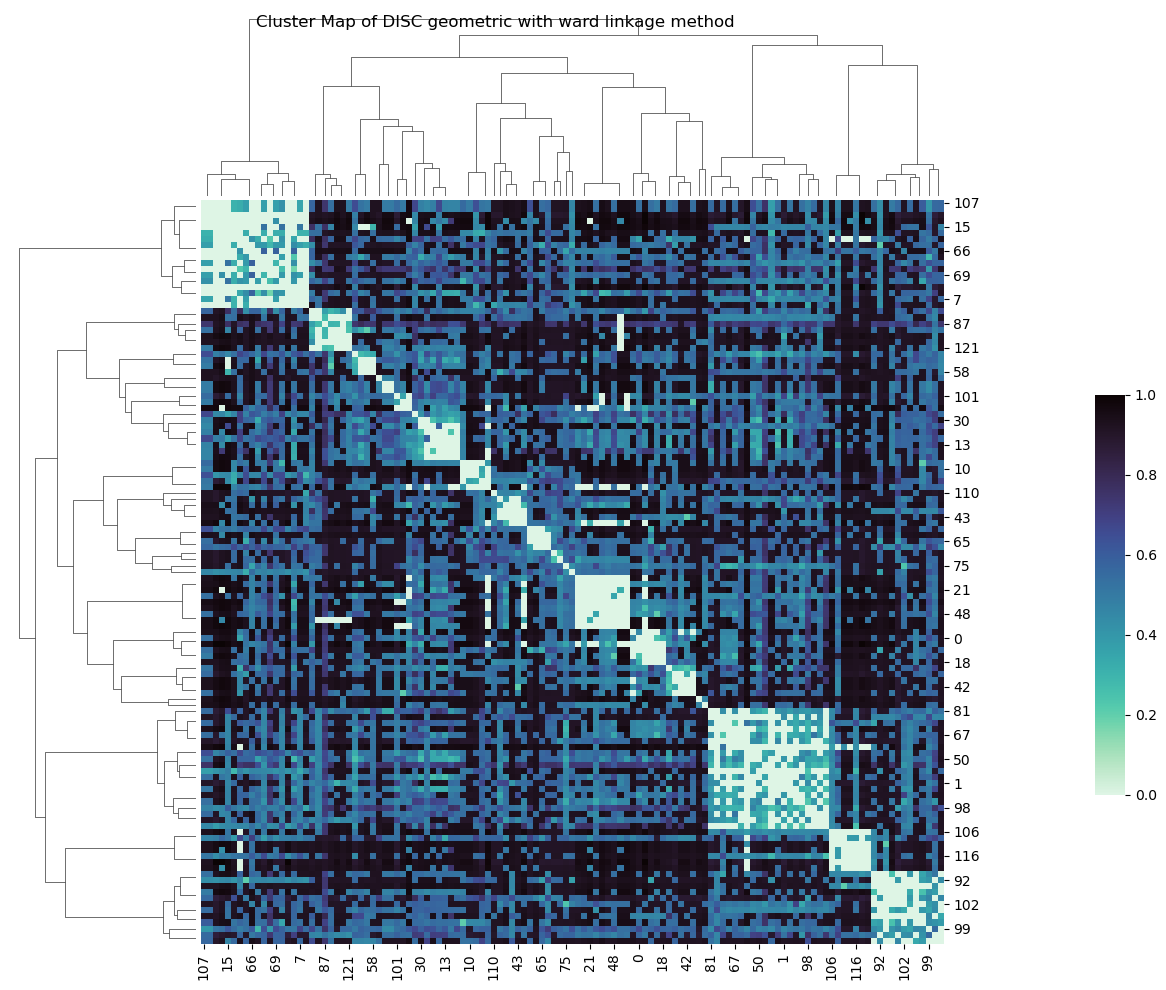

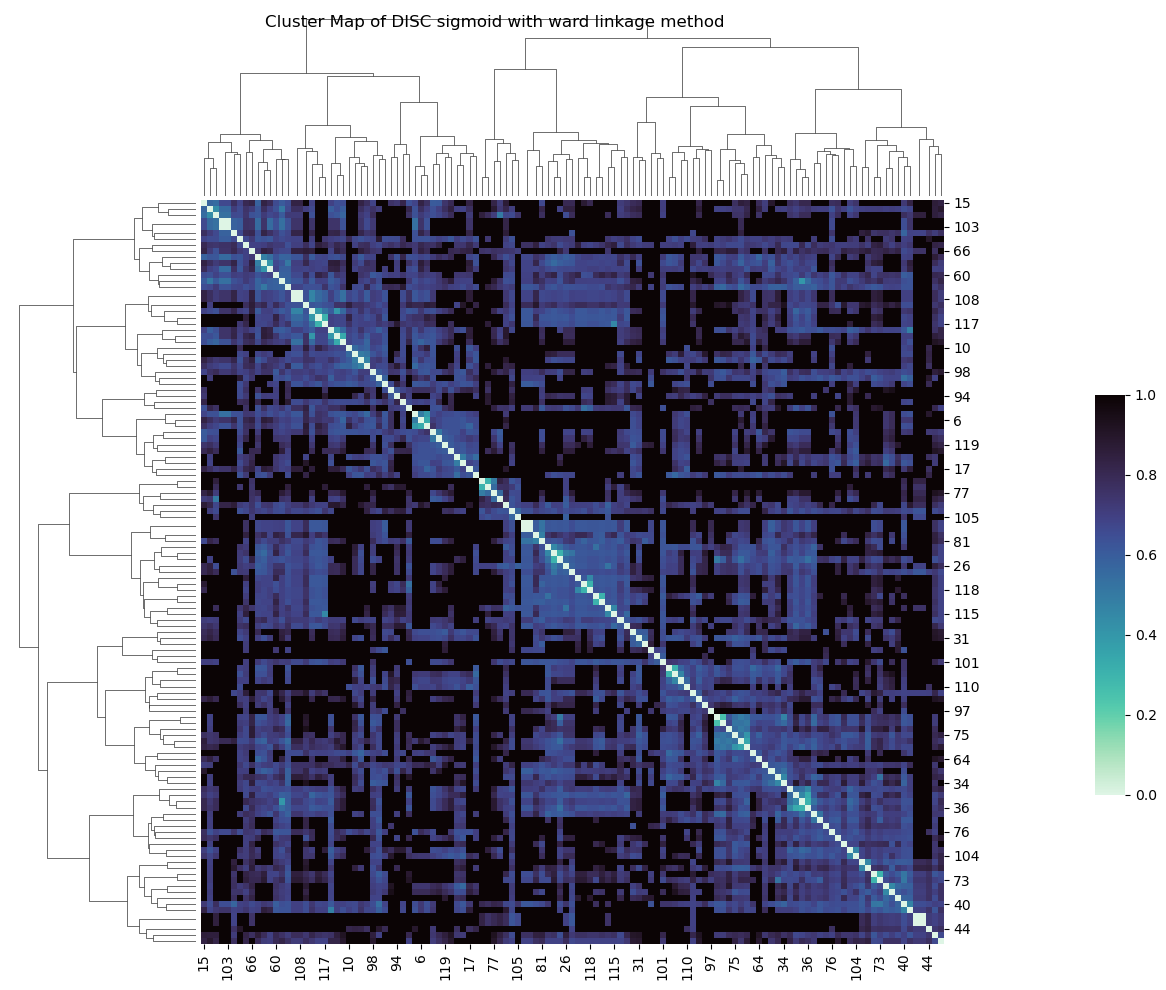

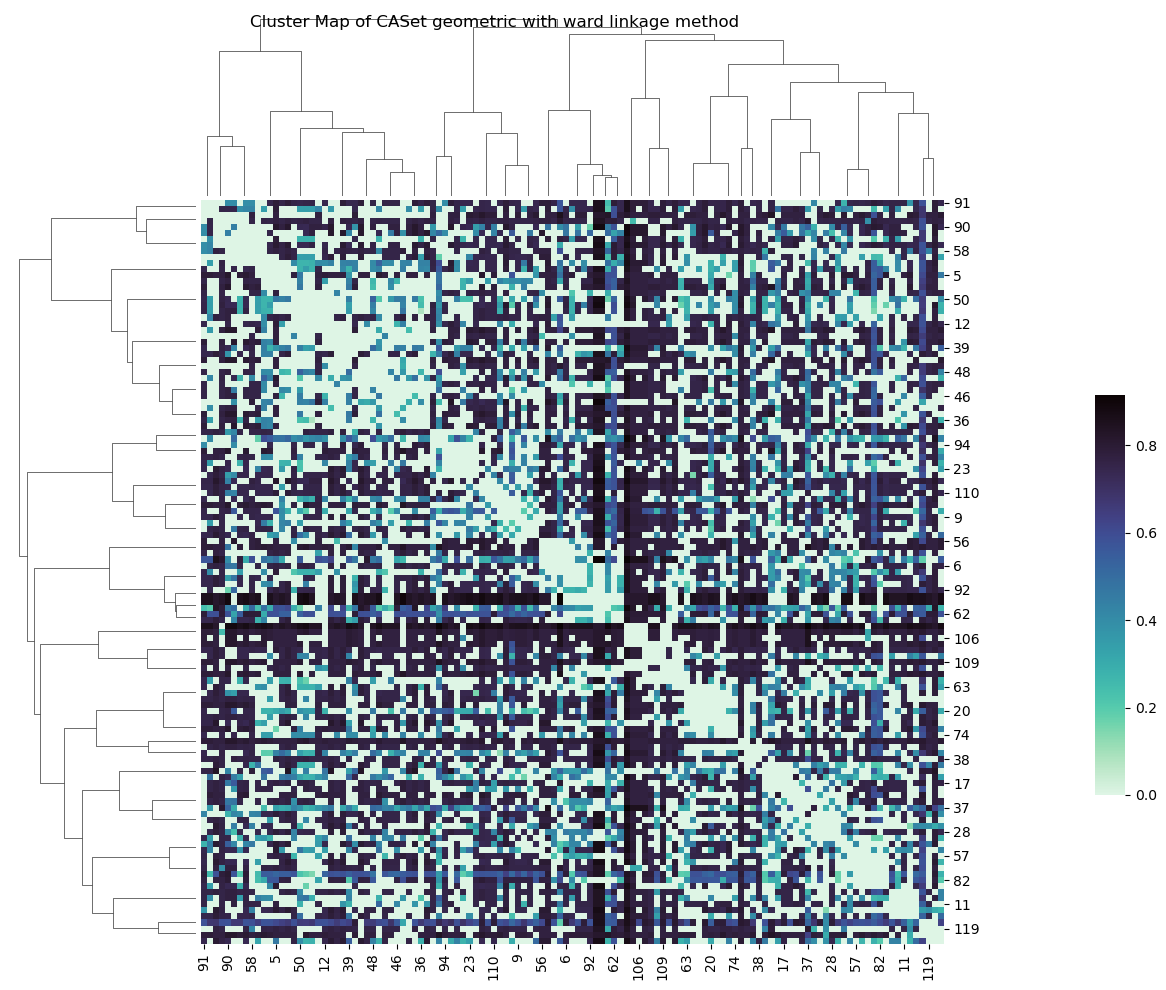

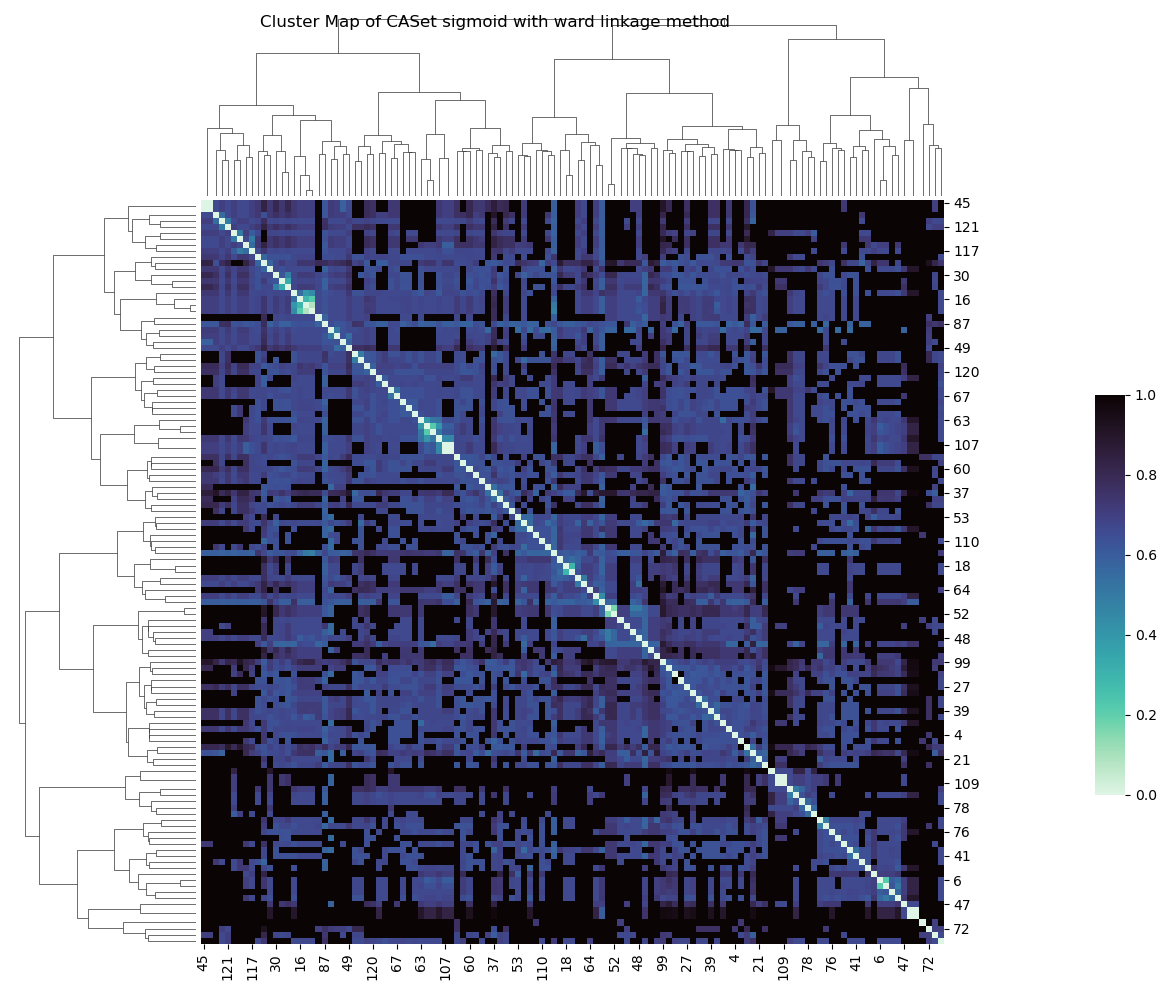

In [25]:
cluster_map('DISC geometric', 'ward', DISC_geo, 'Results/survival/t = 0.02/opt/clustermap_DISC_geo.png')
cluster_map('DISC sigmoid', 'ward', DISC_sig, 'Results/survival/t = 0.02/opt/clustermap_DISC_sig.png')
cluster_map('CASet geometric', 'ward', CASet_geo, 'Results/survival/t = 0.02/opt/clustermap_CASet_geo.png')
cluster_map('CASet sigmoid', 'ward', CASet_sig, 'Results/survival/t = 0.02/opt/clustermap_CASet_sig.png')

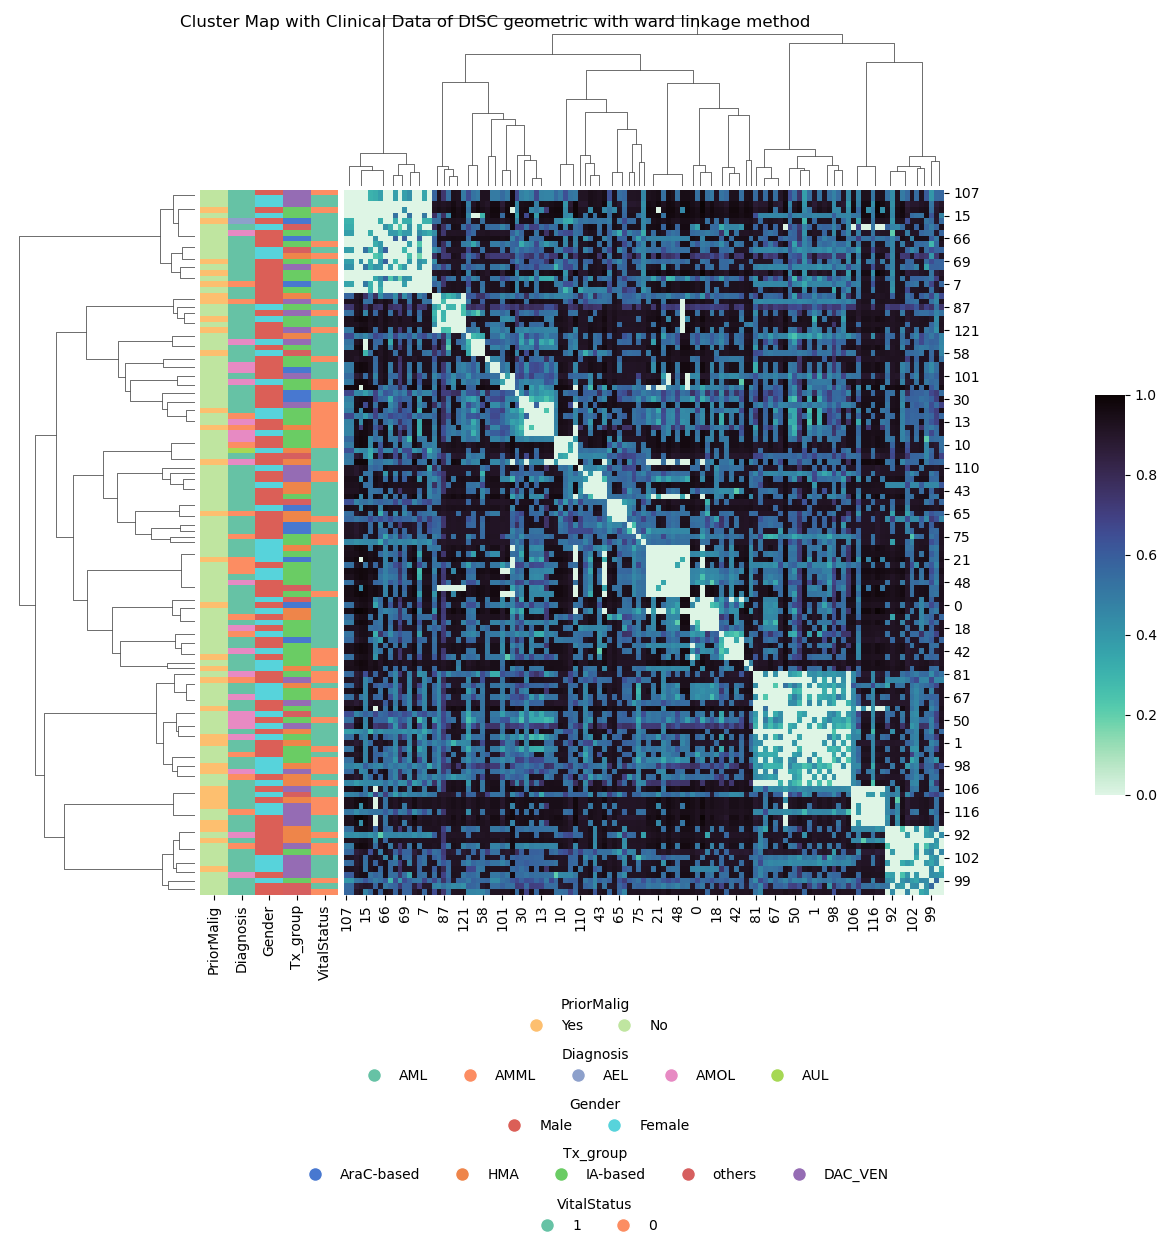

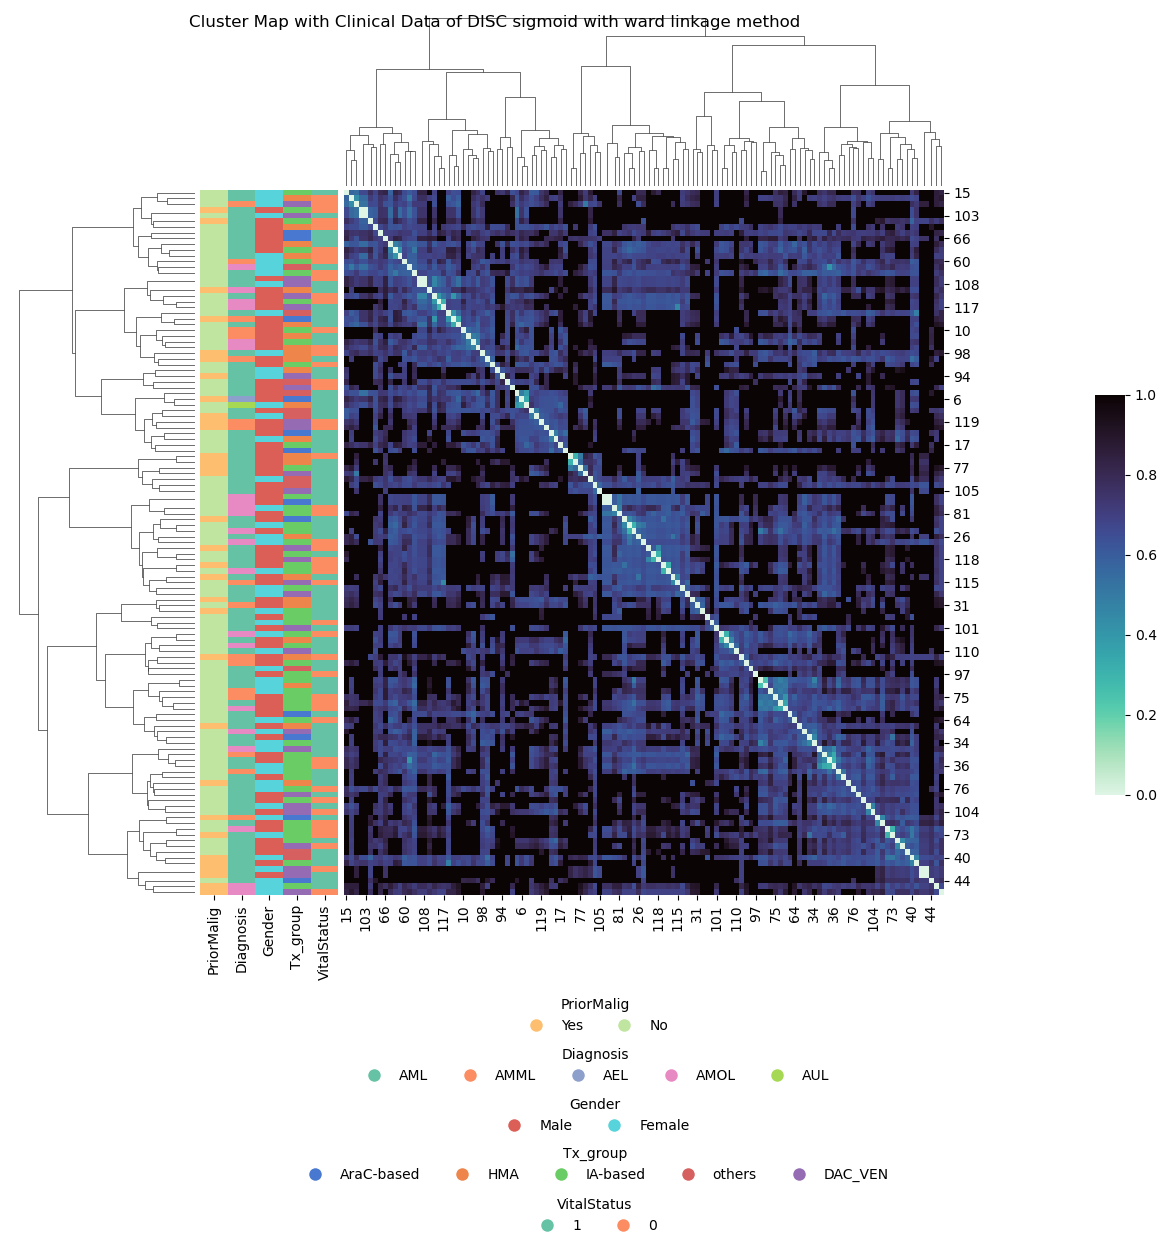

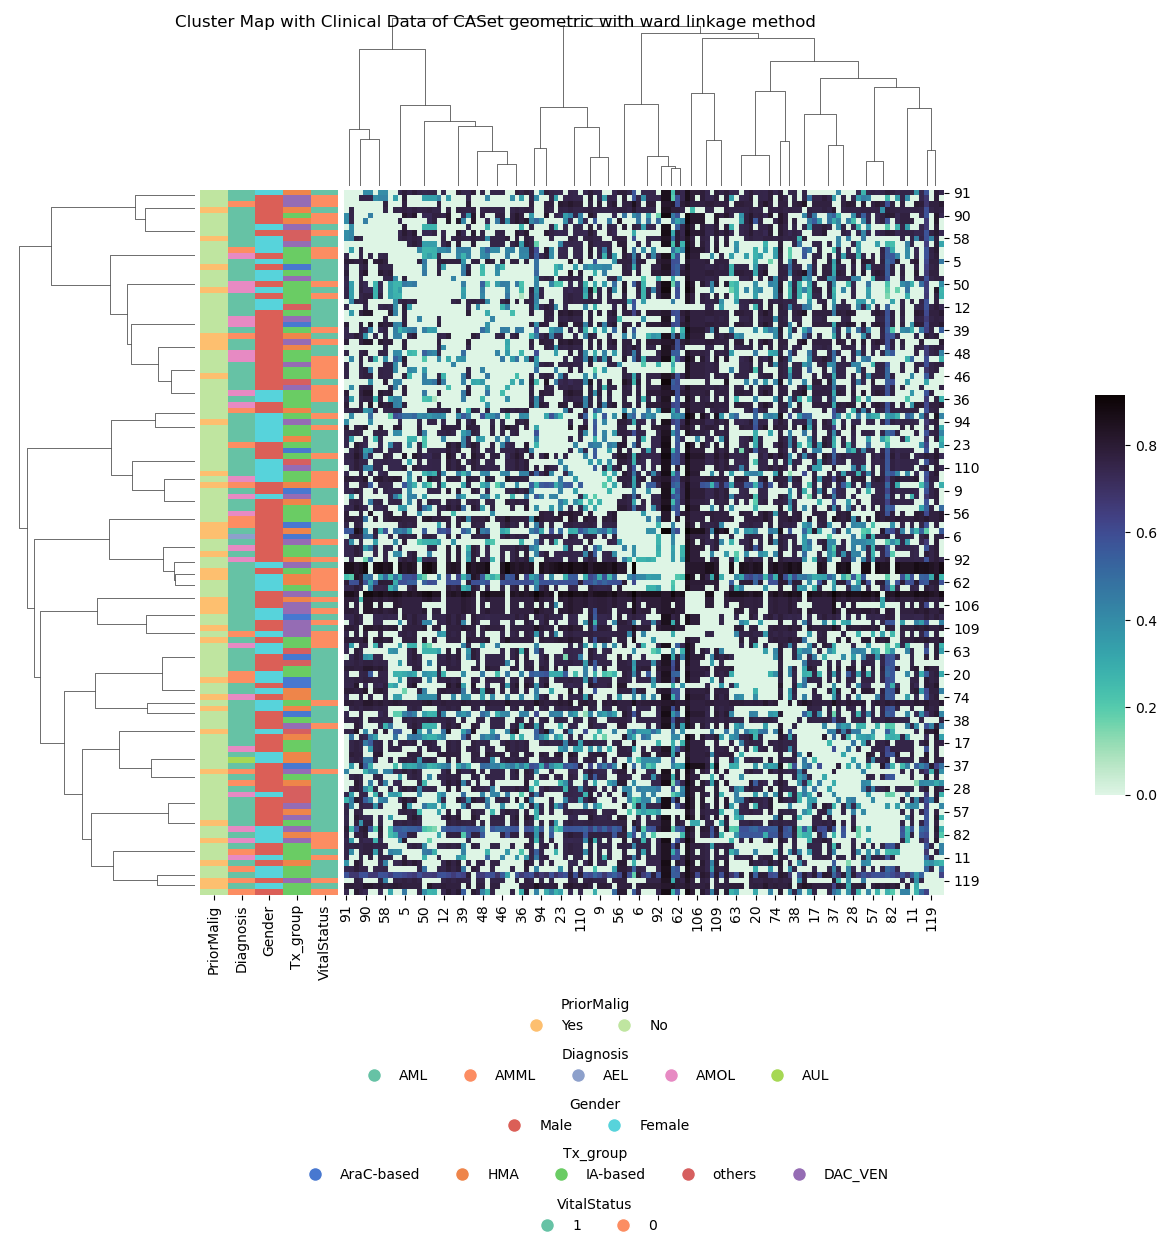

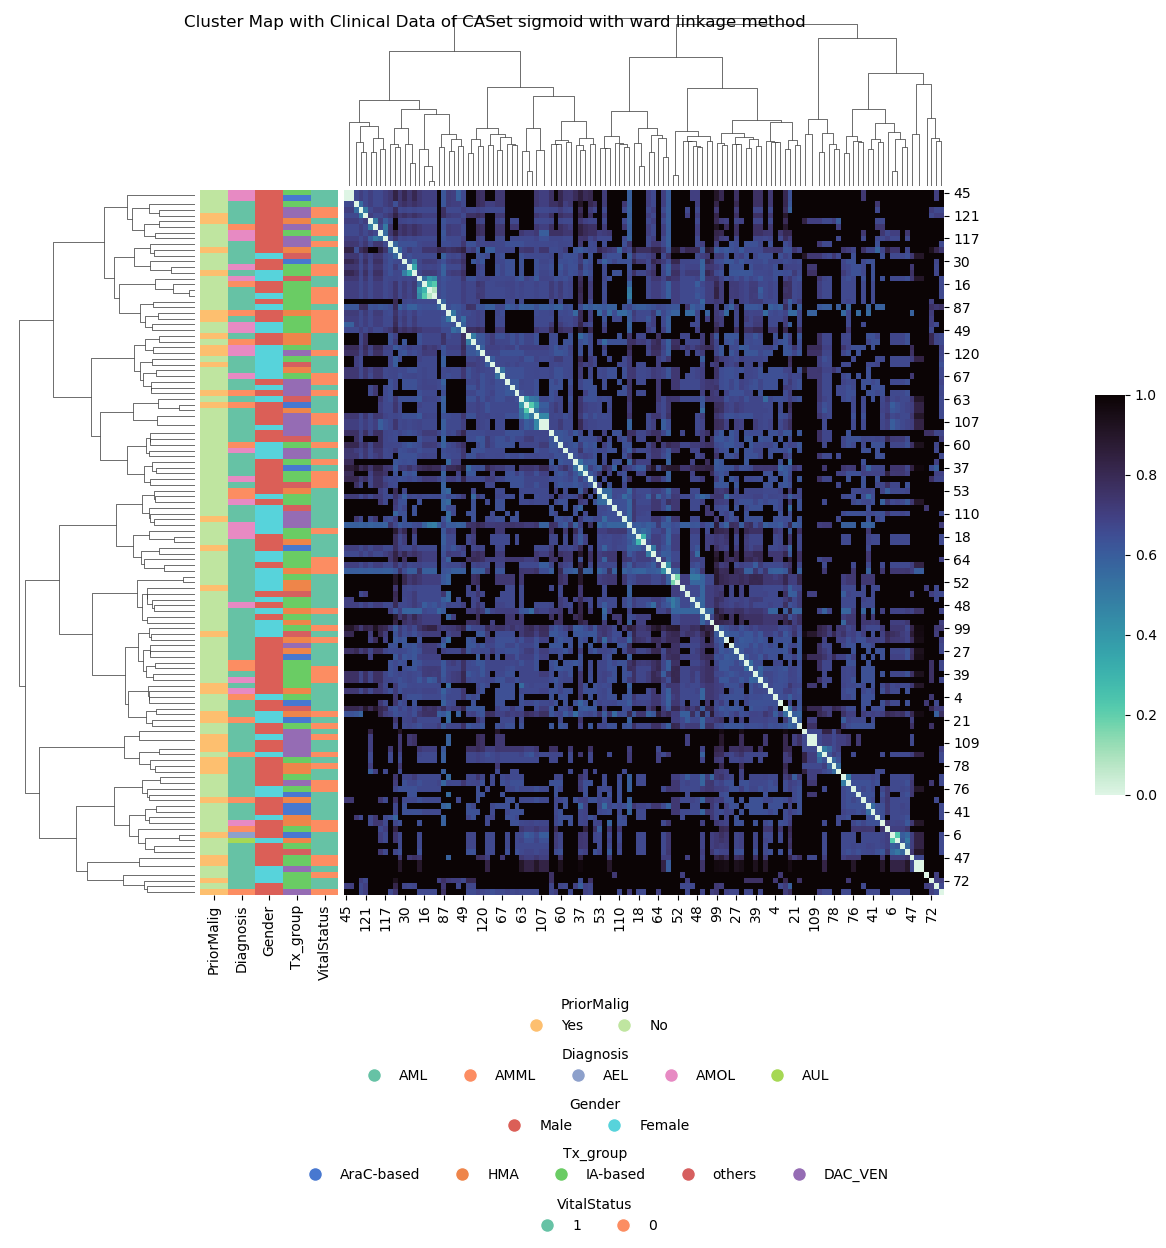

In [26]:
clustermap_wClinical_legend(DISC_geo, 'DISC geometric',clinical_data,'ward', 'Results/survival/t = 0.02/opt/clustermap_wClinical_DISC_geo.png')
clustermap_wClinical_legend(DISC_sig, 'DISC sigmoid',clinical_data,'ward', 'Results/survival/t = 0.02/opt/clustermap_wClinical_DISC_sig.png')
clustermap_wClinical_legend(CASet_geo, 'CASet geometric',clinical_data,'ward', 'Results/survival/t = 0.02/opt/clustermap_wClinical_CASet_geo.png')
clustermap_wClinical_legend(CASet_sig, 'CASet sigmoid',clinical_data,'ward', 'Results/survival/t = 0.02/opt/clustermap_wClinical_CASet_sig.png')

In [31]:
clinical_data = pd.read_csv(directory + '/' + thresh + '/clinicaldata_wclusterlabels.csv', delimiter=',')
matrix_geo = pd.read_csv('Matrix Output/AML_DISC_geometric.csv', delimiter=',')
matrix_sig = pd.read_csv('Matrix Output/AML_DISC_sigmoid.csv', delimiter=',')
matrix_casetgeo = pd.read_csv('Matrix Output/AML_CASet_geometric.csv', delimiter=',')
matrix_casetsig = pd.read_csv('Matrix Output/AML_CASet_sigmoid.csv', delimiter=',')
n_clust_geo = get_n_clusters_simple(matrix_geo,threshold=float(thresh[4:]))
labels_geo = list(get_cluster_labels(matrix_geo, n_clust_geo))
n_clust_sig = get_n_clusters_simple(matrix_sig,threshold=float(thresh[4:]))
labels_sig = list(get_cluster_labels(matrix_sig, n_clust_sig))
n_clust_casetgeo = get_n_clusters_simple(matrix_casetgeo,threshold=float(thresh[4:]))
labels_casetgeo = list(get_cluster_labels(matrix_casetgeo, n_clust_casetgeo))
n_clust_casetsig = get_n_clusters_simple(matrix_casetsig,threshold=float(thresh[4:]))
labels_casetsig = list(get_cluster_labels(matrix_casetsig, n_clust_casetsig))
# Add the cluster labels to the clinical data
clinical_data['DISC geometric'] = labels_geo
clinical_data['DISC sigmoid'] = labels_sig
clinical_data['CASet geometric'] = labels_casetgeo
clinical_data['CASet sigmoid'] = labels_casetsig

clinical_data.to_csv(directory + '/' + thresh + '/clinicaldata_wclusterlabels.csv', index=False)

train_data = train_data[['sample']]
test_data = test_data[['sample']]
cd_train = pd.merge(clinical_data, train_data, on='sample', how='inner')
cd_test = pd.merge(clinical_data, test_data, on='sample', how='inner')
cd_train.to_csv(directory + '/' + thresh + '/clinicaldata_train.csv', index=False)
cd_test.to_csv(directory + '/' + thresh + '/clinicaldata_test.csv', index=False)

In [28]:
new = ['CASet geometric','CASet sigmoid','DISC geometric', 'DISC sigmoid']
for method in new:
    kaplan_meier(clinical_data, 'Survival in days', 'VitalStatus', method, directory + '/' + thresh + '/KM/')
    kaplan_meier(cd_train, 'Survival in days', 'VitalStatus', method, directory + '/' + thresh + '/KM/KM train/')
    kaplan_meier(cd_test, 'Survival in days', 'VitalStatus', method, directory + '/' + thresh + '/KM/KM test/')

<Figure size 640x480 with 0 Axes>

### Differential Evolution

#### Choose best weights

In [15]:
import re

# Initialize the list to store the extracted information
weights_aic_list = []
file_path = 'Results/Diff Ev Results/diff_ev_cv.txt'
pattern = re.compile(r"[-+]?(?:\d*\.\d+|\d+)(?:[eE][-+]?\d+)?")

# Open the file and read line by line
with open(file_path, 'r') as file:
    while True:
        weights_str_list = []
        
        # Concatenate lines until a valid array of weights is formed
        while True:
            # Read the next line
            line = file.readline().strip()
            
            # Check if we have reached the end of the file
            if not line:
                break
            
            # Use regex to find all floating point numbers in the string
            weights_str_list.extend(pattern.findall(line))
            
            # If the line does not end with a ']' it means the array continues in the next line
            if line.endswith(']'):
                break
        
        # Check if we have reached the end of the file
        if not weights_str_list:
            break
        
        # Convert the string numbers to floats and create a list of weights
        weights = [float(weight) for weight in weights_str_list]
        
        # Read the AIC value line
        aic_line = file.readline().strip()
        
        # Check if we have reached the end of the file
        if not aic_line:
            break
        
        # Convert the string representation of the AIC value to a float
        try:
            aic = float(aic_line)
            # Store the extracted information in the list
            weights_aic_list.append((aic, weights))
        except ValueError:
            # If conversion to float fails, continue to the next pair
            print(f'Failed to convert AIC value {aic_line} to float')
            continue


In [17]:
print(len(weights_aic_list))

1001


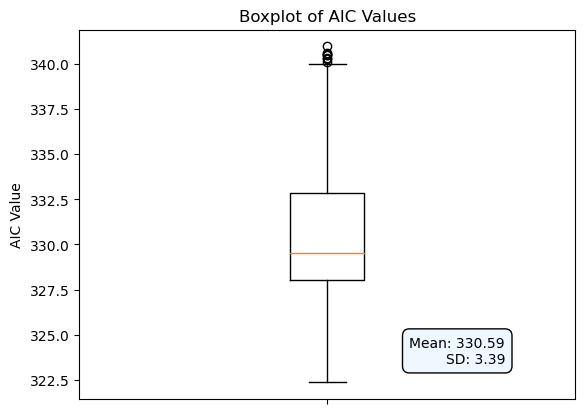

In [18]:
import matplotlib.pyplot as plt

# Extract the AIC values from the list of tuples
aic_values = [aic for aic, _ in weights_aic_list]


# Create a boxplot for the AIC values
plt.boxplot(aic_values)

mean = np.mean(aic_values)
std_dev = np.std(aic_values)

# Add title and labels
plt.title('Boxplot of AIC Values')
plt.ylabel('AIC Value')
plt.annotate(
    f'Mean: {mean:.2f}\nSD: {std_dev:.2f}',
    xy=(0.8, 0.1), xycoords='figure fraction',
    xytext=(-5, 0), textcoords='offset points',
    
    ha='right', va='bottom',
    bbox=dict(boxstyle='round,pad=0.5', edgecolor='black', facecolor='aliceblue')
)

ax = plt.gca()
ax.set_xticklabels([])
# Show the plot
plt.show()


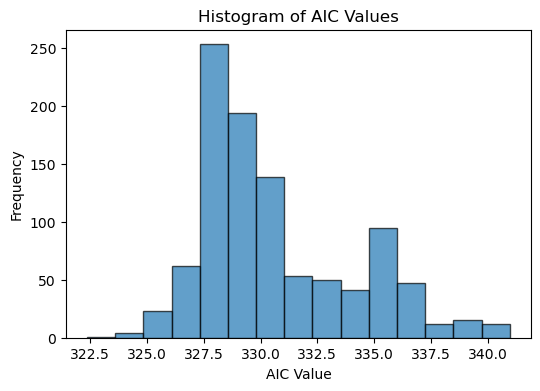

In [19]:
# Create a histogram for the AIC values with 10 bins
plt.figure(figsize=(6,4))
plt.hist(aic_values, bins=15, edgecolor='k', alpha=0.7)

# Add title and labels
plt.title('Histogram of AIC Values')
plt.xlabel('AIC Value')
plt.ylabel('Frequency')

# Show the plot
plt.show()



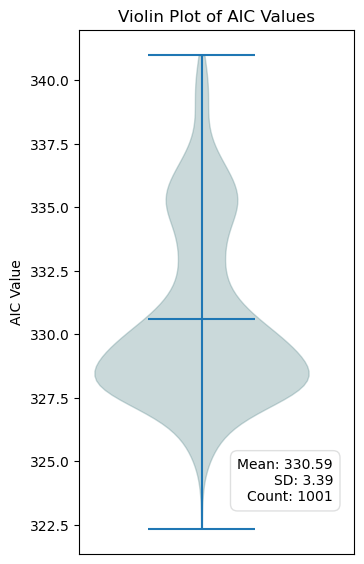

In [20]:
# Define the color for the violin plot
color = '#528387'

# Create a violin plot for the AIC values
plt.figure(figsize=(4, 6))
plt.violinplot(aic_values, showmeans=True, vert=True, widths=0.7)

# Customize the color of the violin plot
plt.gca().collections[0].set_facecolor(color)
plt.gca().collections[0].set_edgecolor(color)

# Add title and labels
plt.title('Violin Plot of AIC Values')
plt.ylabel('AIC Value')

# Remove the x-axis tick labels
plt.gca().set_xticks([])

plt.ylim(min(aic_values) - 1, max(aic_values) + 1)
plt.xlim(0.6,1.5)

mean = np.mean(aic_values)
std_dev = np.std(aic_values)

plt.tight_layout(pad=2)
plt.annotate(
    f'Mean: {mean:.2f}\nSD: {std_dev:.2f}\nCount: {len(aic_values)}',
    xy=(0.85, 0.1), xycoords='figure fraction',
    xytext=(-5, 0), textcoords='offset points',
    
    ha='right', va='bottom',
    bbox=dict(boxstyle='round,pad=0.5', edgecolor='#D2D3D4', facecolor='white', alpha=0.7)
)
# Show the plot
plt.show()


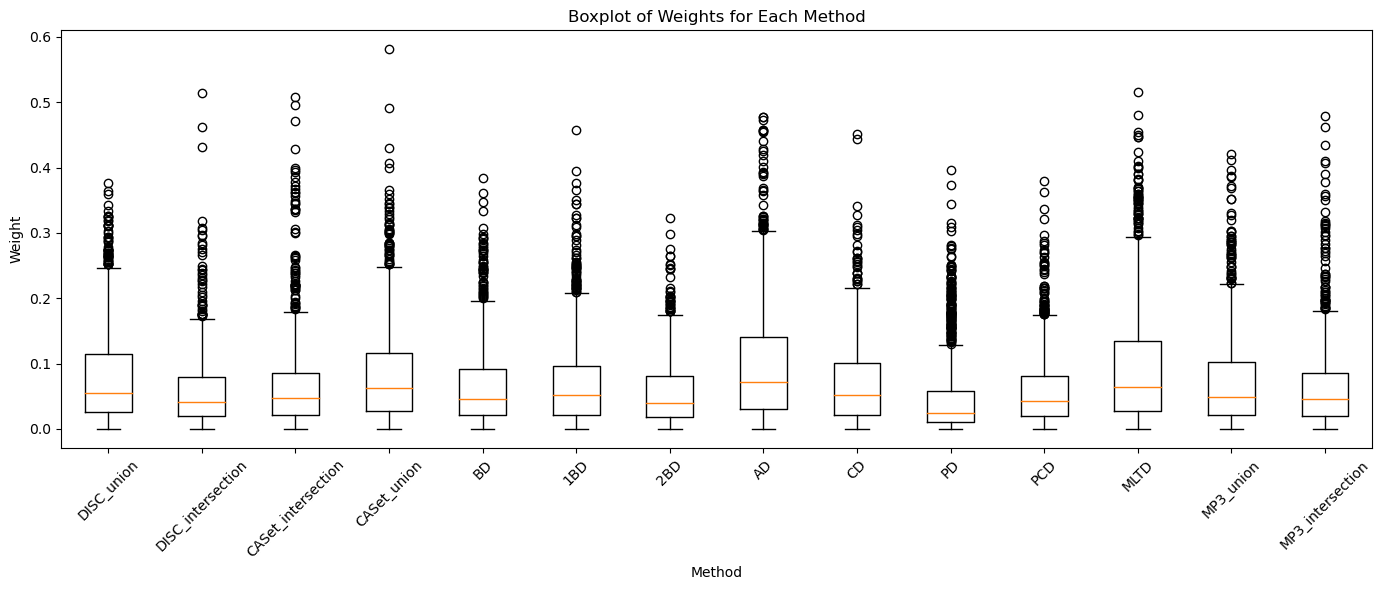

In [21]:
# Initialize a dictionary to store the weights for each method
methods = ['DISC_union', 'DISC_intersection', 'CASet_intersection', 'CASet_union', 'BD','1BD', '2BD', 'AD', 'CD', 'PD', 'PCD', 'MLTD', 'MP3_union', 'MP3_intersection']

weights_by_method = {method: [] for method in methods}

# Iterate through the list of weights and AIC values and extract the weights for each method
for idx, (aic, weights) in enumerate(weights_aic_list):
    if len(weights) != len(methods):
        # Print a warning message if the number of weights does not match the number of methods
        print(f"Warning: Number of weights ({len(weights)}) does not match number of methods ({len(methods)}) at index {idx}.")
        continue
    
    for i, weight in enumerate(weights):
        method = methods[i]
        weights_by_method[method].append(weight)

# Create a list of weights for each method in the order of methods
weights_data = [weights_by_method[method] for method in methods]

# Create a boxplot for each method
plt.figure(figsize=(14, 6))
plt.boxplot(weights_data, labels=methods)

# Add title and labels
plt.title('Boxplot of Weights for Each Method')
plt.xlabel('Method')
plt.ylabel('Weight')

# Rotate x-axis labels for better readability
plt.xticks(rotation=45)

# Show the plot
plt.tight_layout()
plt.show()


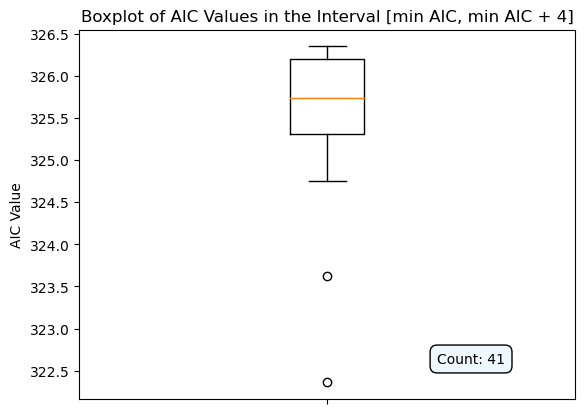

In [67]:
# Create a boxplot for the filtered AIC values
min_aic = min(aic_values)

d = 4
# Define the upper bound of the interval
upper_bound = min_aic + d

# Filter the AIC values that are in the interval [min_aic, min_aic + 5]
filtered_aic_values = [aic for aic in aic_values if aic <= upper_bound]

num_aic_in_interval = len(filtered_aic_values)

plt.boxplot(filtered_aic_values)

# Add title and labels
plt.title(f'Boxplot of AIC Values in the Interval [min AIC, min AIC + {d}]')
plt.ylabel('AIC Value')

# Add the number of AIC values in the interval as text to the plot
plt.annotate(
    f'Count: {num_aic_in_interval}',
    xy=(0.8, 0.1), xycoords='figure fraction',
    xytext=(-5, 0), textcoords='offset points',
    
    ha='right', va='bottom',
    bbox=dict(boxstyle='round,pad=0.5', edgecolor='black', facecolor='aliceblue')
)


# Remove the x-axis tick labels
ax = plt.gca()
ax.set_xticklabels([])

# Show the plot
plt.show()


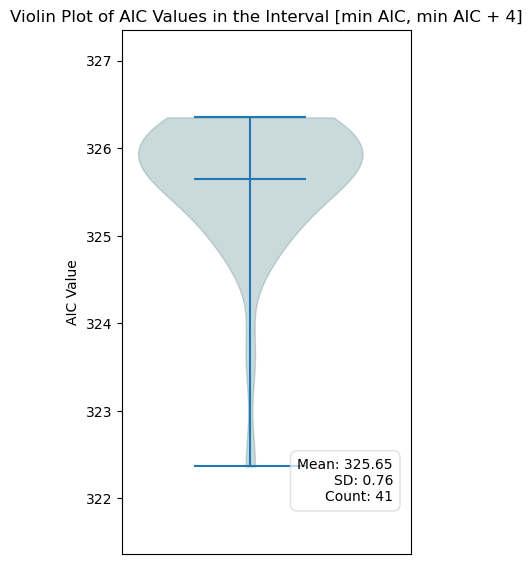

In [68]:
# Define the color for the violin plot
color = '#528387'

# Create a violin plot for the AIC values
plt.figure(figsize=(4, 6))
plt.violinplot(filtered_aic_values, showmeans=True, vert=True, widths=0.7)

# Customize the color of the violin plot
plt.gca().collections[0].set_facecolor(color)
plt.gca().collections[0].set_edgecolor(color)

# Add title and labels
plt.title(f'Violin Plot of AIC Values in the Interval [min AIC, min AIC + {d}]')
plt.ylabel('AIC Value')

# Remove the x-axis tick labels
plt.gca().set_xticks([])

plt.ylim(min(filtered_aic_values) - 1, max(filtered_aic_values) + 1)
plt.xlim(0.6,1.5)

mean = np.mean(filtered_aic_values)
std_dev = np.std(filtered_aic_values)

plt.tight_layout(pad=2)
plt.annotate(
    f'Mean: {mean:.2f}\nSD: {std_dev:.2f}\nCount: {num_aic_in_interval}',
    xy=(1, 0.1), xycoords='figure fraction',
    xytext=(-5, 0), textcoords='offset points',
    
    ha='right', va='bottom',
    bbox=dict(boxstyle='round,pad=0.5', edgecolor='#D2D3D4', facecolor='white', alpha=0.7)
)
# Show the plot
plt.show()


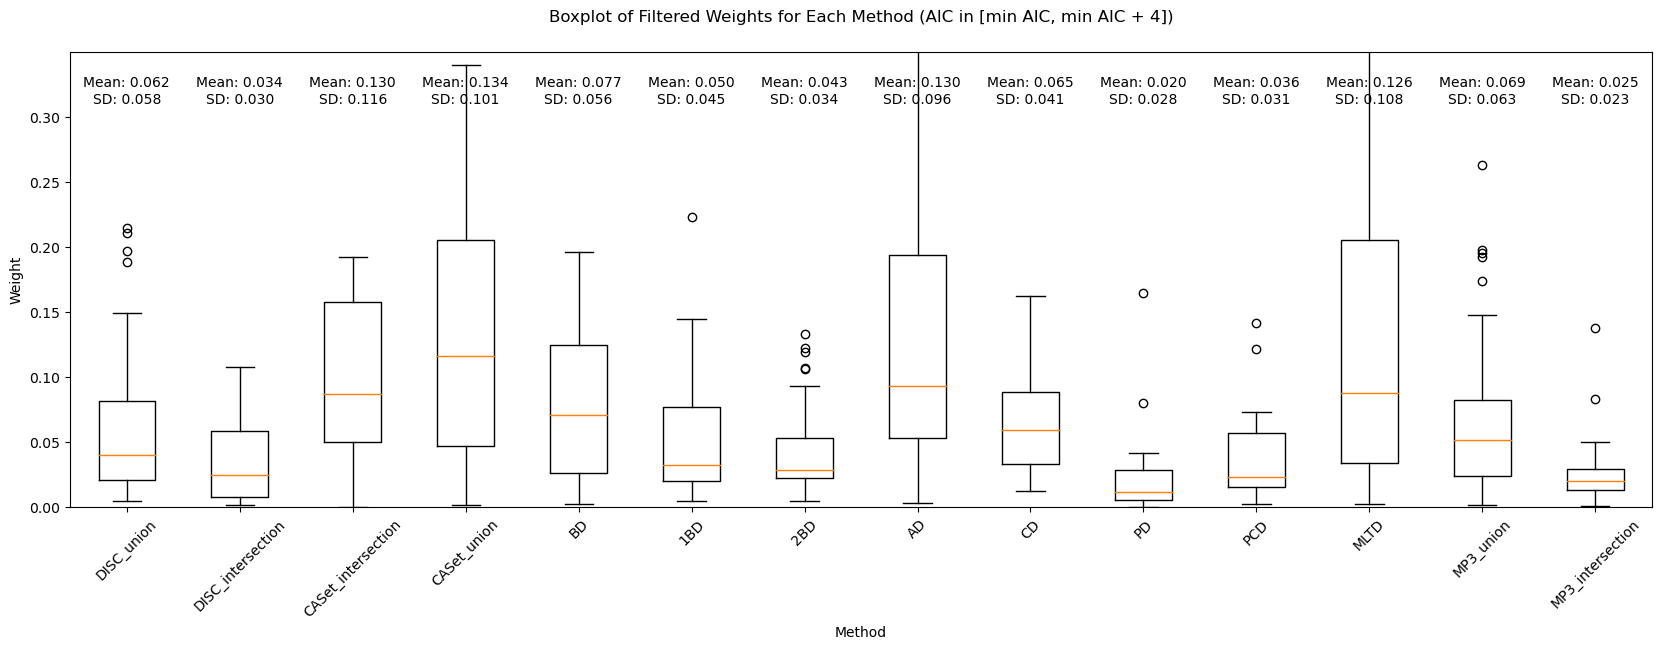

In [69]:
# Filter the list of weights and AIC values based on the specified interval
filtered_weights_aic_list = [(aic, weights) for aic, weights in weights_aic_list if aic <= upper_bound]

# Initialize a dictionary to store the filtered weights for each method
filtered_weights_by_method = {method: [] for method in methods}

# Iterate through the filtered list and extract the weights for each method
for aic, weights in filtered_weights_aic_list:
    for i, weight in enumerate(weights):
        method = methods[i]
        filtered_weights_by_method[method].append(weight)

# Create a list of filtered weights for each method in the order of methods
filtered_weights_data = [filtered_weights_by_method[method] for method in methods]

# Create a boxplot for each method using the filtered weights
plt.figure(figsize=(14, 6))
bp = plt.boxplot(filtered_weights_data, labels=methods)

# Add title with adjusted vertical position and labels
plt.title(f'Boxplot of Filtered Weights for Each Method (AIC in [min AIC, min AIC + {d}])', y=1.05)
plt.xlabel('Method')
plt.ylabel('Weight')

# Rotate x-axis labels for better readability
plt.xticks(rotation=45)

# Calculate the position above each box to place the annotation
y_max = max([item.get_ydata().max() for item in bp['boxes']])
annotation_height = y_max + (y_max * 0.5)  # 10% above the highest box

# Iterate through the filtered weights for each method and annotate the mean and standard deviation
for i, weights in enumerate(filtered_weights_data):
    mean = np.mean(weights)
    std_dev = np.std(weights)
    plt.annotate(
        f'Mean: {mean:.3f}\nSD: {std_dev:.3f}',
        xy=(i + 1, annotation_height),
        xycoords='data',
        xytext=(0, 0),
        textcoords='offset points',
        ha='center',
        va='bottom',
        rotation=0
    )

# Adjust the y-axis limit to fit the annotations
plt.ylim(0, annotation_height + (y_max * 0.2))

# Show the plot with adjusted layout
plt.tight_layout(rect=[0, 0, 1.2, 1.1])
plt.show()

In [16]:
def get_lowest_aic(data):
    # Sort by AIC value
    sorted_data = sorted(data, key=lambda x: x[0])

    # Return the top 3 (lowest AICs)
    return sorted_data[:3]


lowest_aic_values = get_lowest_aic(weights_aic_list)

for weights, aic in lowest_aic_values:
    print("Weights:", weights)
    print("AIC:", aic)
    print("------")


Weights: 322.3618550439148
AIC: [0.03122381, 0.03960774, 0.36793971, 0.03609658, 0.19563003, 0.01510442, 0.02691017, 0.14237214, 0.03094989, 0.0299555, 0.00742279, 0.05785371, 0.00439025, 0.01454327]
------
Weights: 323.62715533921204
AIC: [0.02445635, 0.02781128, 0.39580284, 0.02161632, 0.14971547, 0.00466213, 0.00518734, 0.17167391, 0.02258214, 0.07998926, 0.06299469, 0.01198002, 0.00425111, 0.01727714]
------
Weights: 324.74955079953276
AIC: [0.00482486, 0.00720231, 0.07119965, 0.33764333, 0.0262491, 0.01464826, 0.04937003, 0.20776207, 0.08818554, 0.02843343, 0.01726809, 0.03998387, 0.07090405, 0.0363254]
------


In [17]:
r_lowest_aic_values = []
weights = lowest_aic_values[0][1]
aic = lowest_aic_values[0][0]
print("Weights:", weights)
print("AIC:", aic)

Weights: [0.03122381, 0.03960774, 0.36793971, 0.03609658, 0.19563003, 0.01510442, 0.02691017, 0.14237214, 0.03094989, 0.0299555, 0.00742279, 0.05785371, 0.00439025, 0.01454327]
AIC: 322.3618550439148


In [18]:

weights_round = [round(weight, 2) for weight in weights]
print(weights_round)
weights_round =[0.03, 0.04, 0.37, 0.04, 0.2, 0.02, 0.03, 0.14, 0.03, 0.03, 0.01, 0.06, 0.0, 0.0]

print(sum(weights_round))
# i want to input as the weights the weights_round
r_lowest_aic_values += [(weights_round, aic)]

[0.03, 0.04, 0.37, 0.04, 0.2, 0.02, 0.03, 0.14, 0.03, 0.03, 0.01, 0.06, 0.0, 0.01]
1.0


In [19]:
weights = lowest_aic_values[1][1]
aic = lowest_aic_values[1][0]
print("Weights:", weights)
print("AIC:", aic)

Weights: [0.02445635, 0.02781128, 0.39580284, 0.02161632, 0.14971547, 0.00466213, 0.00518734, 0.17167391, 0.02258214, 0.07998926, 0.06299469, 0.01198002, 0.00425111, 0.01727714]
AIC: 323.62715533921204


In [20]:
weights_round = [round(weight, 2) for weight in weights]
print(weights_round)

weights_round =[0.02, 0.03, 0.4, 0.02, 0.15, 0.0, 0.01, 0.18, 0.02, 0.08, 0.06, 0.01, 0.0, 0.02]
print(sum(weights_round))
# i want to input as the weights the weights_round
r_lowest_aic_values += [(weights_round, aic)]

[0.02, 0.03, 0.4, 0.02, 0.15, 0.0, 0.01, 0.17, 0.02, 0.08, 0.06, 0.01, 0.0, 0.02]
1.0


In [21]:
weights = lowest_aic_values[2][1]
aic = lowest_aic_values[2][0]
print("Weights:", weights)
print("AIC:", aic)

Weights: [0.00482486, 0.00720231, 0.07119965, 0.33764333, 0.0262491, 0.01464826, 0.04937003, 0.20776207, 0.08818554, 0.02843343, 0.01726809, 0.03998387, 0.07090405, 0.0363254]
AIC: 324.74955079953276


In [22]:
weights_round = [round(weight, 2) for weight in weights]
print(weights_round)

weights_round = [0.000, 0.000, 0.070, 0.340, 0.030, 0.010, 0.050, 0.210, 0.090, 0.030, 0.020, 0.040, 0.070, 0.040]

#print(weights_round)
# i want to input as the weights the weights_round
r_lowest_aic_values += [(weights_round, aic)]


[0.0, 0.01, 0.07, 0.34, 0.03, 0.01, 0.05, 0.21, 0.09, 0.03, 0.02, 0.04, 0.07, 0.04]


In [23]:
import plotly.graph_objects as go

# Define metrics
metrics = ['DISC_union', 'DISC_intersection', 'CASet_intersection', 'CASet_union', 'BD','1BD', '2BD', 'AD', 'CD', 'PD', 'PCD', 'MLTD', 'MP3_union', 'MP3_intersection']

# Create the radar chart
fig = go.Figure()

# Iterate over each set of weights in lowest_aic_values
for weights, aic in r_lowest_aic_values:
    # Complete the loop for plotting
    weights_circ = weights + weights[:1]

    fig.add_trace(go.Scatterpolar(
        r=weights_circ,
        theta=metrics + [metrics[0]], # complete the loop for the metrics as well
        fill='toself',
        name=f"AIC: {aic:.2f}"
    ))

fig.update_layout(
    polar=dict(
        radialaxis=dict(
            visible=True,
            range=[0, max(weight for weights, _ in r_lowest_aic_values for weight in weights)] # corrected line
        )),
    showlegend=True
)

# Save as an HTML file
fig.write_html("radar_chart.html") 

# Show the plot
fig.show()




Concordance Index


In [25]:
methods = ['DISC_union', 'DISC_intersection', 'CASet_intersection', 'CASet_union', 'BD','1BD', '2BD', 'AD', 'CD', 'PD', 'PCD', 'MLTD', 'MP3_union', 'MP3_intersection']

for weights,aic in r_lowest_aic_values:
    list_matrix =list()

    for method in methods:
        list_matrix.append(pd.read_csv('Matrix Output/AML_'+method+'.csv', delimiter=','))

    matrix = np.zeros((len(list_matrix[0]), len(list_matrix[0])))

    for n in range(len(list_matrix)):

        matrix += list_matrix[n] * weights[n]
    #merge clinical data with train and test data
    clinical_data = pd.read_csv(directory + '/' + thresh + '/clinicaldata_wclusterlabels.csv', delimiter=',')
    
    n_clust = get_n_clusters_simple(matrix)
    labels = list(get_cluster_labels(matrix, n_clust))

    # Add the cluster labels to the clinical data
    clinical_data['Optimal Combination'] = labels
    clinical_data.to_csv(directory + '/' + thresh + '/clinicaldata_wclusterlabels.csv', index=False)
    train_data = train_data[['sample']]
    test_data = test_data[['sample']]
    cd_train = pd.merge(clinical_data, train_data, on='sample', how='inner')
    cd_test = pd.merge(clinical_data, test_data, on='sample', how='inner')
    cd_train.to_csv(directory + '/' + thresh + '/clinicaldata_train.csv', index=False)
    cd_test.to_csv(directory + '/' + thresh + '/clinicaldata_test.csv', index=False)
    dfs = convert_to_category(cd_train,columns =['Gender','Optimal Combination'])
    filtered_df = filter_data(dfs, ['age','Gender','EZH2', 'GATA2', 'TP53', 'STAG2', 'IDH1', 'ETV6', 'SRSF2', 'U2AF1', 'DNMT3A', 'SF3B1', 'FLT3', 'PTPN11', 'NRAS', 'CSF3R', 'IDH2', 'PPM1D',  'MYC', 'KRAS', 'KIT', 'PHF6',  'ASXL1', 'BCOR', 'SETBP1', 'TET2', 'NPM1', 'WT1', 'RUNX1', 'FLT3-ITD', 'Optimal Combination', 'Survival in days', 'VitalStatus'])

    df_HE = convert_to_OneHotEncoder(filtered_df)
    cph_model = fit_cox_model(df_HE, 'Survival in days', 'VitalStatus')
    print(aic)
    print(print_cox_model_summary(cph_model))


/Users/Lau/anaconda3/lib/python3.10/site-packages/lifelines/utils/__init__.py:1122: ConvergenceWarning:

Column BCOR have very low variance when conditioned on death event present or not. This may harm convergence. This could be a form of 'complete separation'. For example, try the following code:

>>> events = df['VitalStatus'].astype(bool)
>>> print(df.loc[events, 'BCOR'].var())
>>> print(df.loc[~events, 'BCOR'].var())

A very low variance means that the column BCOR completely determines whether a subject dies or not. See https://stats.stackexchange.com/questions/11109/how-to-deal-with-perfect-separation-in-logistic-regression.


/Users/Lau/anaconda3/lib/python3.10/site-packages/lifelines/fitters/coxph_fitter.py:1604: ConvergenceWarning:

Newton-Rhaphson convergence completed successfully but norm(delta) is still high, 0.240. This may imply non-unique solutions to the maximum likelihood. Perhaps there is collinearity or complete separation in the dataset?




322.3618550439148
<lifelines.CoxPHFitter: fitted with 86 total observations, 34 right-censored observations>
             duration col = 'Survival in days'
                event col = 'VitalStatus'
      baseline estimation = breslow
   number of observations = 86
number of events observed = 52
   partial log-likelihood = -167.82
         time fit was run = 2023-10-08 22:27:42 UTC

---
                        coef  exp(coef)   se(coef)    p
covariate                                              
age                     0.02       1.02       0.02 0.14
Gender=Male             0.21       1.23       0.51 0.68
EZH2                    1.61       5.01       1.42 0.26
GATA2                   0.33       1.40       1.26 0.79
TP53                    0.94       2.55       0.80 0.24
STAG2                 -16.76       0.00    5462.38 1.00
IDH1                    0.09       1.09       0.74 0.91
ETV6                   -1.51       0.22       2.45 0.54
SRSF2                  -0.50       0.61       0.78 

/Users/Lau/anaconda3/lib/python3.10/site-packages/lifelines/utils/__init__.py:1122: ConvergenceWarning:

Column BCOR have very low variance when conditioned on death event present or not. This may harm convergence. This could be a form of 'complete separation'. For example, try the following code:

>>> events = df['VitalStatus'].astype(bool)
>>> print(df.loc[events, 'BCOR'].var())
>>> print(df.loc[~events, 'BCOR'].var())

A very low variance means that the column BCOR completely determines whether a subject dies or not. See https://stats.stackexchange.com/questions/11109/how-to-deal-with-perfect-separation-in-logistic-regression.


/Users/Lau/anaconda3/lib/python3.10/site-packages/lifelines/fitters/coxph_fitter.py:1604: ConvergenceWarning:

Newton-Rhaphson convergence completed successfully but norm(delta) is still high, 0.240. This may imply non-unique solutions to the maximum likelihood. Perhaps there is collinearity or complete separation in the dataset?




323.62715533921204
<lifelines.CoxPHFitter: fitted with 86 total observations, 34 right-censored observations>
             duration col = 'Survival in days'
                event col = 'VitalStatus'
      baseline estimation = breslow
   number of observations = 86
number of events observed = 52
   partial log-likelihood = -168.27
         time fit was run = 2023-10-08 22:27:43 UTC

---
                        coef  exp(coef)   se(coef)    p
covariate                                              
age                     0.01       1.01       0.02 0.38
Gender=Male            -0.17       0.85       0.54 0.75
EZH2                    1.42       4.14       1.35 0.29
GATA2                   0.42       1.51       1.25 0.74
TP53                    1.15       3.16       0.68 0.09
STAG2                 -16.43       0.00    5524.53 1.00
IDH1                   -1.37       0.26       0.93 0.14
ETV6                   -0.14       0.87       2.19 0.95
SRSF2                  -0.57       0.56       0.87

/Users/Lau/anaconda3/lib/python3.10/site-packages/lifelines/utils/__init__.py:1122: ConvergenceWarning:

Column BCOR have very low variance when conditioned on death event present or not. This may harm convergence. This could be a form of 'complete separation'. For example, try the following code:

>>> events = df['VitalStatus'].astype(bool)
>>> print(df.loc[events, 'BCOR'].var())
>>> print(df.loc[~events, 'BCOR'].var())

A very low variance means that the column BCOR completely determines whether a subject dies or not. See https://stats.stackexchange.com/questions/11109/how-to-deal-with-perfect-separation-in-logistic-regression.


/Users/Lau/anaconda3/lib/python3.10/site-packages/lifelines/fitters/coxph_fitter.py:1604: ConvergenceWarning:

Newton-Rhaphson convergence completed successfully but norm(delta) is still high, 0.240. This may imply non-unique solutions to the maximum likelihood. Perhaps there is collinearity or complete separation in the dataset?




#### New method results

In [102]:
weights = r_lowest_aic_values[0][0]


methods = ['DISC_union', 'DISC_intersection', 'CASet_intersection', 'CASet_union', 'BD','1BD', '2BD', 'AD', 'CD', 'PD', 'PCD', 'MLTD', 'MP3_union', 'MP3_intersection']

list_matrix =list()

for method in methods:
    list_matrix.append(pd.read_csv('Matrix Output/AML_'+method+'.csv', delimiter=','))

matrix = np.zeros((len(list_matrix[0]), len(list_matrix[0])))

for n in range(len(list_matrix)):

    matrix += list_matrix[n] * weights[n]



In [103]:
matrix.to_csv('Matrix Output/AML_Optimal_Combination.csv', index=False)

In [104]:
np_matrix = matrix.to_numpy()
histograms(np_matrix, 'Results/survival/t = 0.02/opt/histogram_optimizer.png', 'Optimal Combination')

<Figure size 1000x1000 with 0 Axes>

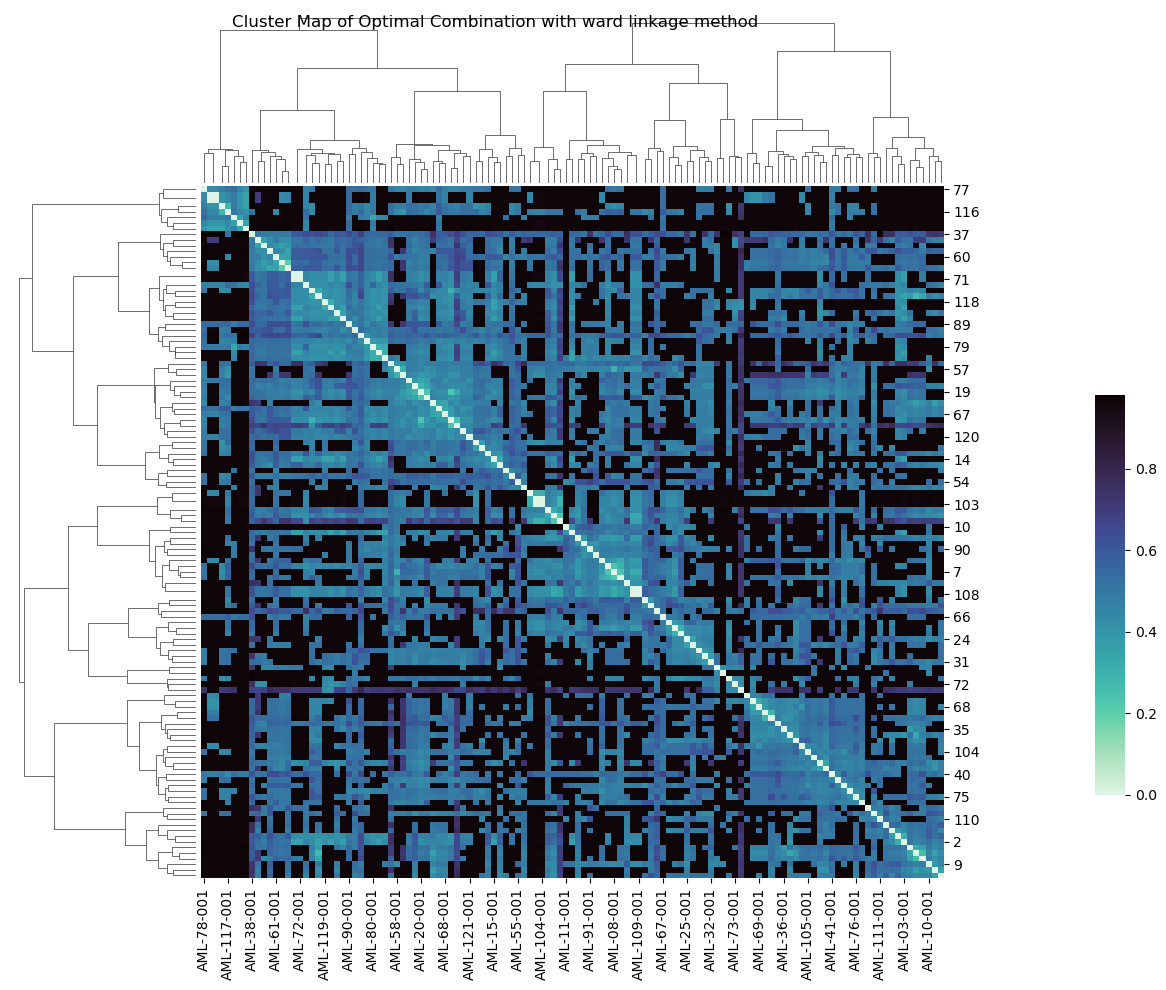

In [105]:
cluster_map('Optimal Combination', 'ward', matrix, 'Results/survival/t = 0.02/opt/clustermap_optimizer.png')

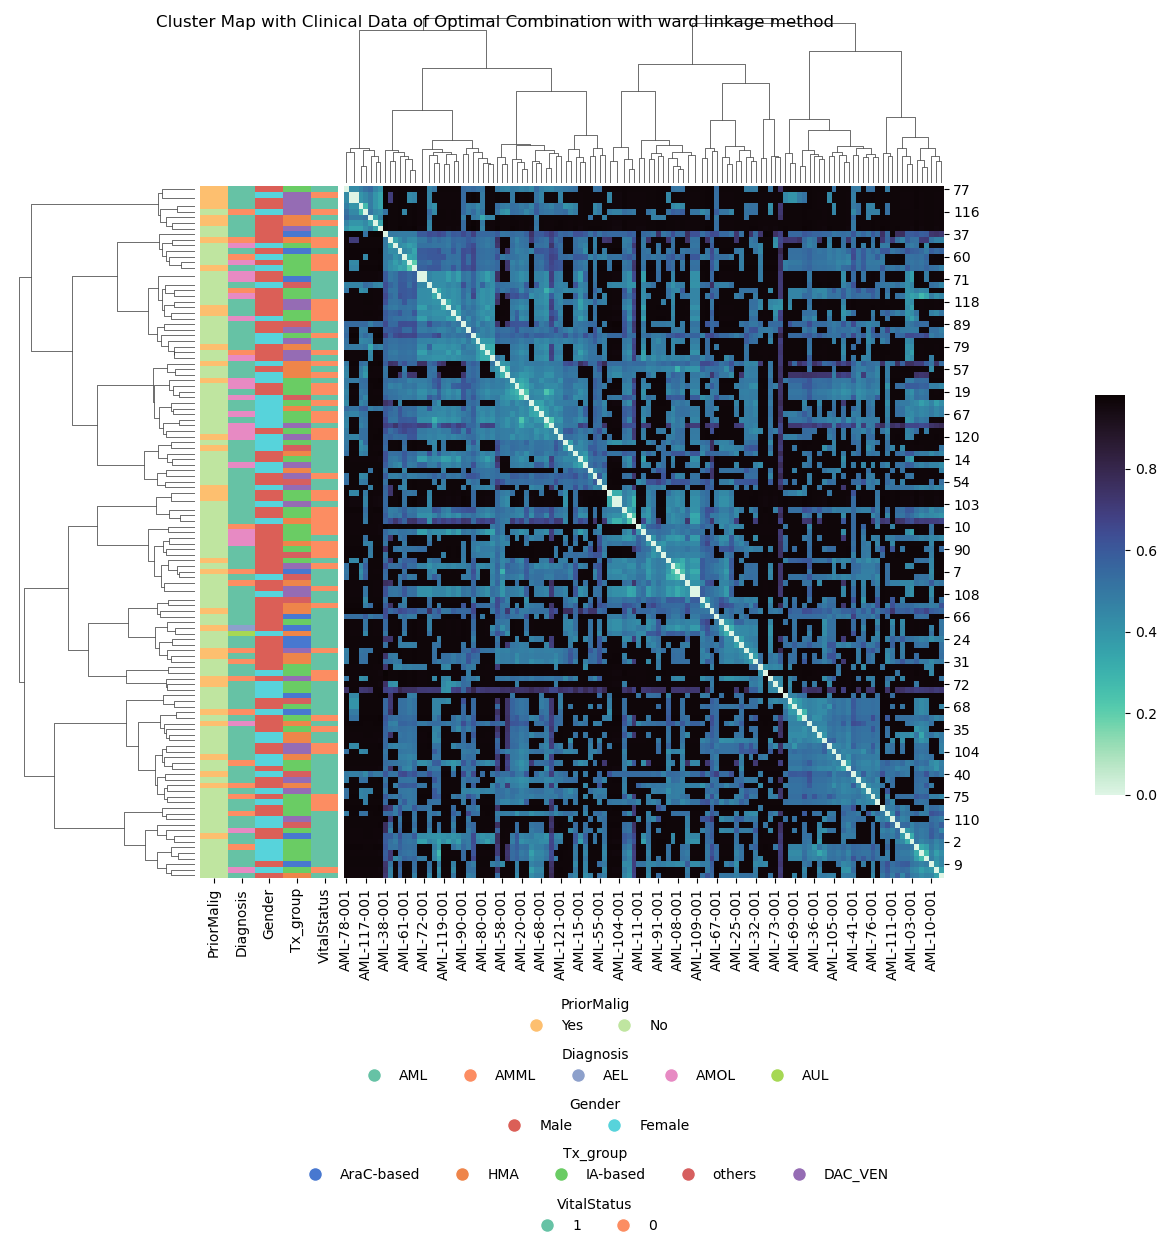

In [106]:
clustermap_wClinical_legend(matrix, 'Optimal Combination',clinical_data,'ward', 'Results/survival/t = 0.02/opt/clustermap_wClinical_optimizer.png')

#### Add cluster optimal combination row

In [107]:
method = 'Optimal Combination'

In [108]:
#merge clinical data with train and test data
clinical_data = pd.read_csv(directory + '/' + thresh + '/clinicaldata_wclusterlabels.csv', delimiter=',')
matrix = pd.read_csv('Matrix Output/AML_Optimal_Combination.csv', delimiter=',')
n_clust = get_n_clusters_simple(matrix)
labels = list(get_cluster_labels(matrix, n_clust))

# Add the cluster labels to the clinical data
clinical_data['Optimal Combination'] = labels
clinical_data.to_csv(directory + '/' + thresh + '/clinicaldata_wclusterlabels.csv', index=False)
train_data = train_data[['sample']]
test_data = test_data[['sample']]
cd_train = pd.merge(clinical_data, train_data, on='sample', how='inner')
cd_test = pd.merge(clinical_data, test_data, on='sample', how='inner')
cd_train.to_csv(directory + '/' + thresh + '/clinicaldata_train.csv', index=False)
cd_test.to_csv(directory + '/' + thresh + '/clinicaldata_test.csv', index=False)

In [109]:
kaplan_meier(clinical_data, 'Survival in days', 'VitalStatus', method, directory + '/' + thresh + '/KM/')
kaplan_meier(cd_train, 'Survival in days', 'VitalStatus', method, directory + '/' + thresh + '/KM/KM train/')
kaplan_meier(cd_test, 'Survival in days', 'VitalStatus', method, directory + '/' + thresh + '/KM/KM test/')

<Figure size 640x480 with 0 Axes>

In [129]:
#### Cox regression LLR and AIC
methods = ['DISC_union', 'DISC_intersection', 'CASet_intersection', 'CASet_union', 'BD','1BD', '2BD', 'AD', 'CD', 'PD', 'PCD', 'MLTD', 'MP3_union', 'MP3_sigmoid', 'MP3_intersection', 'MP3_geometric']

methods_n = methods + ['CASet_geometric','CASet_sigmoid','DISC_geometric','DISC_sigmoid','Optimal Combination']
dfs = convert_to_category(cd_train,columns =['Gender'], method=methods_n)
results = {}
methods_cox = ['Only Clinical'] + methods + ['CASet_geometric','CASet_sigmoid','DISC_geometric','DISC_sigmoid','Optimal Combination']


for method in methods_cox:

    if method == 'Only Clinical':
        filtered_df = filter_data(dfs, ['age','Gender', 'Survival in days', 'VitalStatus'])
    else:
        filtered_df = filter_data(dfs, ['age','Gender', method, 'Survival in days', 'VitalStatus'])

    df_HE = convert_to_OneHotEncoder(filtered_df)
    cph_model = fit_cox_model(df_HE, 'Survival in days', 'VitalStatus')
    results[method] = {}
    results[method]['AIC'] = round(partial_AIC(cph_model),1)
    results[method]['LR'] = round(LLR_score(cph_model)/2,1)

results = pd.DataFrame(results).T
results.to_csv(directory + '/' + thresh + '/' + stage + '/Cox Results' + stage + '.csv')
results 

,AIC,LR
Only Clinical,389.8,1.8
DISC_union,393.4,2.0
DISC_intersection,395.4,11.0
CASet_intersection,392.3,3.5
CASet_union,393.5,1.9
BD,392.4,2.5
1BD,380.4,8.5
2BD,393.0,2.2
AD,385.8,5.8
CD,391.1,3.1


In [130]:
#### LR like fritz
results = pd.read_csv(directory + '/' + thresh + '/' + stage + '/Cox Results' + stage + '.csv', index_col=0)
results_llr = results[['LR']]
results_aic = results[['AIC']]
clinical_n =  results_llr.loc['Only Clinical'][0]
clinical_aic = results_aic.loc['Only Clinical'][0]
p1 = 1 - stats.chi2.cdf(clinical_n, 1)
add_results = {"AIC-corrected" : {'Only Clinical' : None}, "pvalue" : {"Only Clinical" : p1}, "LR-corrected" : {'Only Clinical' : None},"pvalue-corrected" : {'Only Clinical' : None}}
for method in methods_n:
    llr_n =  results_llr.loc[method][0]
    method_levels =  clinical_data[method].unique()
    add_results["AIC-corrected"][method] = results_aic.loc[method][0] - clinical_aic
    add_results["LR-corrected"][method] = llr_n - clinical_n

    # Calculate p1
    df_p1 = len(method_levels) - 1
    p1 = 1 - stats.chi2.cdf(llr_n - clinical_n, df_p1)
    p1 = round(p1, 10)
    add_results["pvalue-corrected"][method] = p1
    # Calculate p2
    df_p2 = len(method_levels) - 1
    p2 = 1 - stats.chi2.cdf(llr_n, df_p2)
    add_results["pvalue"][method] = p2
    

add_results = pd.DataFrame(add_results)

#merge with index
new_results = pd.concat([results, add_results], axis=1)
new_results = new_results[['AIC','AIC-corrected', 'LR', 'pvalue', 'LR-corrected', 'pvalue-corrected']]
new_results.to_csv(directory + '/' + thresh + '/' + stage + '/Cox Results' + stage + '.csv')
new_results

,AIC,AIC-corrected,LR,pvalue,LR-corrected,pvalue-corrected
Only Clinical,389.8,NaN,1.8,0.179712,NaN,NaN
DISC_union,393.4,3.6,2.0,0.367879,0.2,0.904837
DISC_intersection,395.4,5.6,11.0,0.610818,9.2,0.757676
CASet_intersection,392.3,2.5,3.5,0.320762,1.7,0.636934
CASet_union,393.5,3.7,1.9,0.386741,0.1,0.951229
BD,392.4,2.6,2.5,0.286505,0.7,0.704688
1BD,380.4,-9.4,8.5,0.014264,6.7,0.035084
2BD,393.0,3.2,2.2,0.332871,0.4,0.818731
AD,385.8,-4.0,5.8,0.055023,4.0,0.135335
CD,391.1,1.3,3.1,0.212248,1.3,0.522046


In [131]:
#### add WSS and number of clusters
results = pd.read_csv(directory + '/' + thresh + '/' + stage + '/Cox Results' + stage + '.csv', index_col=0)
numb_clust = pd.read_csv('Results/Threshold_nclust.csv', index_col=0)
nclust_c =numb_clust[['0.02_Number of Clusters']]

#merge with index
nclust = nclust_c.copy()


## add WSS
wss = {}
for method in methods_n:
    if method == 'Optimal Combination':
        X = pd.read_csv('Matrix Output/AML_Optimal_Combination.csv', delimiter=',')
        nclusters = get_n_clusters_simple(X)
        nclust.loc['Optimal Combination'] = [nclusters]
    elif method == 'DISC_geometric':
        X = pd.read_csv('Matrix Output/AML_DISC_geometric.csv', delimiter=',')
        nclusters = get_n_clusters_simple(X)
        nclust.loc['DISC_geometric'] = [nclusters]
    elif method == 'DISC_sigmoid':
        X = pd.read_csv('Matrix Output/AML_DISC_sigmoid.csv', delimiter=',')
        nclusters = get_n_clusters_simple(X)
        nclust.loc['DISC_sigmoid'] = [nclusters]
    elif method == 'CASet_geometric':
        X = pd.read_csv('Matrix Output/AML_CASet_geometric.csv', delimiter=',')
        nclusters = get_n_clusters_simple(X)
        nclust.loc['CASet_geometric'] = [nclusters]
    elif method == 'CASet_sigmoid':
        X = pd.read_csv('Matrix Output/AML_CASet_sigmoid.csv', delimiter=',')
        nclusters = get_n_clusters_simple(X)
        nclust.loc['CASet_sigmoid'] = [nclusters]
    else:
        X = pd.read_csv(current_dir + f'/Matrix Output/AML_{method}.csv', delimiter=',')
        nclusters = nclust.loc[method][0]
    wss[method] = round(weighted_silhouette(n_clust = int(nclusters), X = X), 2)


new_results = pd.concat([results, nclust], axis=1)

#change name of thresh to number of clusters
new_results = new_results.rename(columns={'0.02_Number of Clusters': 'Number of Clusters'})

wss = pd.Series(wss)
wss = wss.rename('WSS')
new_results = pd.concat([new_results, wss], axis=1)

new_results = new_results[['Number of Clusters', 'WSS', 'AIC','AIC-corrected', 'LR', 'pvalue', 'LR-corrected', 'pvalue-corrected']]
new_results.to_csv(directory + '/' + thresh + '/' + stage + '/Cox Results' + stage + '.csv')
new_results

,Number of Clusters,WSS,AIC,AIC-corrected,LR,pvalue,LR-corrected,pvalue-corrected
Only Clinical,NaN,NaN,389.8,NaN,1.8,0.179712,NaN,NaN
DISC_union,3.0,0.05,393.4,3.6,2.0,0.367879,0.2,0.904837
DISC_intersection,14.0,0.68,395.4,5.6,11.0,0.610818,9.2,0.757676
CASet_intersection,4.0,0.13,392.3,2.5,3.5,0.320762,1.7,0.636934
CASet_union,3.0,0.03,393.5,3.7,1.9,0.386741,0.1,0.951229
BD,3.0,0.10,392.4,2.6,2.5,0.286505,0.7,0.704688
1BD,3.0,0.09,380.4,-9.4,8.5,0.014264,6.7,0.035084
2BD,3.0,0.07,393.0,3.2,2.2,0.332871,0.4,0.818731
AD,3.0,0.05,385.8,-4.0,5.8,0.055023,4.0,0.135335
CD,3.0,0.06,391.1,1.3,3.1,0.212248,1.3,0.522046


In [132]:
coef_dict = {}
new_methods = ['Only Clinical'] + methods + ['CASet_geometric','CASet_sigmoid','DISC_geometric','DISC_sigmoid','Optimal Combination']

for method in new_methods:
    if method == 'Only Clinical':
        filtered_clinical = cd_train[['age','Gender', 'Survival in days', 'VitalStatus']]
        categorical_data = convert_to_category(filtered_clinical, columns =['Gender'])
    else:
        filtered_clinical = cd_train[['age','Gender', 'Survival in days', 'VitalStatus', method]]
        categorical_data = convert_to_category(filtered_clinical, columns =['Gender', method])
    
    enconder_data = convert_to_OneHotEncoder(categorical_data)

    cph_model = fit_cox_model(enconder_data, 'Survival in days', 'VitalStatus')

    coef = list(get_coef(cph_model))

    if method == 'Only Clinical':
        filtered_clinical_test = cd_test[['age','Gender', 'Survival in days', 'VitalStatus']]
        categorical_data_test = convert_to_category(filtered_clinical_test, columns =['Gender'])
    else:
        filtered_clinical_test = cd_test[['age','Gender', 'Survival in days', 'VitalStatus', method]]
        categorical_data_test = convert_to_category(filtered_clinical_test, columns =['Gender', method])
    
    enconder_data_test = convert_to_OneHotEncoder(categorical_data_test)
    missing_cols = set(enconder_data.columns) - set(enconder_data_test.columns)

    # Add the missing columns to the 'new' DataFrame and fill them with zeros
    for col in missing_cols:
        enconder_data_test[col] = 0.0

    
    # Reorder the columns of the 'new' DataFrame to match the order of the columns in the 'previous' DataFrame
    df_result = enconder_data_test[enconder_data.columns]


    enconder_data_test = df_result.drop(['Survival in days', 'VitalStatus'], axis=1)

    test_clinical = prognostic_index(coef,enconder_data_test,method,cd_test)

test_clinical.to_csv(directory + '/' + thresh + '/' + stage + '/Prognostic Index' + stage + '.csv')

In [133]:
from lifelines import KaplanMeierFitter
from lifelines.statistics import logrank_test
import matplotlib.pyplot as plt

# Load the data
df = pd.read_csv(directory + '/' + thresh + '/' + stage + '/Prognostic Index' + stage + '.csv', delimiter=',')
new_methods = ['Only Clinical'] + methods + ['CASet_geometric','CASet_sigmoid','DISC_geometric','DISC_sigmoid','Optimal Combination']
for method in new_methods:
    plt.figure(figsize=(8, 6))  # Create a new figure for each method
    
    kmf = KaplanMeierFitter()
    high_risk_data = df[df[f'Risk Group {method}'] == 'High']
    low_risk_data = df[df[f'Risk Group {method}'] == 'Low']
    
    # Fit Kaplan-Meier for high-risk group
    kmf.fit(high_risk_data['Survival in days'], event_observed=high_risk_data['VitalStatus'], label='High Risk')
    kmf.plot(label='High Risk')
    
    # Fit Kaplan-Meier for low-risk group
    kmf.fit(low_risk_data['Survival in days'], event_observed=low_risk_data['VitalStatus'], label='Low Risk')
    kmf.plot(label='Low Risk')
    
    plt.xlabel('Time (Days)')
    plt.ylabel('Survival Probability')
    plt.title(f'Survival Curves for Risk Groups - {method}')
    plt.legend()
    
    # Perform log-rank test and add p-value to the plot
    result = logrank_test(
        high_risk_data['Survival in days'], low_risk_data['Survival in days'],
        high_risk_data['VitalStatus'], low_risk_data['VitalStatus']
    )

    plt.text(0.5, 0.04, f'Log-rank p-value: {result.p_value:.2e}', transform=plt.gca().transAxes, ha='center', va='bottom', bbox=dict(facecolor='white', edgecolor='black', boxstyle='round,pad=0.5'))
    
    # Save the plot for this method
    plt.savefig(directory + '/' + thresh + '/' + stage + f'/KM PI/Survival Curves for Risk Groups - {method}.png')
    
    # Close the current figure to create a new one for the next method
    plt.close()


In [134]:
c_index = dict()
test_clinical = pd.read_csv(directory + '/' + thresh + '/' + stage + '/Prognostic Index' + stage + '.csv', delimiter=',')
results = pd.read_csv(directory + '/' + thresh + '/' + stage + '/Cox Results' + stage + '.csv', index_col=0)

method = 'Only Clinical'

filtered_clinical = test_clinical[['Survival in days', 'VitalStatus', f'Prognostic Index {method}']]

cph_model = fit_cox_model(filtered_clinical, 'Survival in days', 'VitalStatus')

ci_test = cph_model.score(filtered_clinical, scoring_method="concordance_index")

clinical_c = round(ci_test,3)

c_index[method] = [clinical_c, None]

for method in new_methods:
    #c-index of the low risk and high risk groups
    filtered_clinical = test_clinical[['Survival in days', 'VitalStatus', f'Prognostic Index {method}']]

    cph_model = fit_cox_model(filtered_clinical, 'Survival in days', 'VitalStatus')

    ci_test = cph_model.score(filtered_clinical, scoring_method="concordance_index")

    cind = round(ci_test,3)

    c_index[method] = [cind, round(cind - clinical_c,3)]

    

c_index_df = pd.DataFrame.from_dict(c_index, orient='index', columns=['C-Index', 'C-Index - corrected'])


results['C-Index'] = c_index_df['C-Index']
results['C-Index - corrected'] = c_index_df['C-Index - corrected']
results.to_csv(directory + '/' + thresh + '/' + stage + '/Cox Results' + stage + '.csv')
results

,Number of Clusters,WSS,AIC,AIC-corrected,LR,pvalue,LR-corrected,pvalue-corrected,C-Index,C-Index - corrected
Only Clinical,NaN,NaN,389.8,NaN,1.8,0.179712,NaN,NaN,0.663,0.000
DISC_union,3.0,0.05,393.4,3.6,2.0,0.367879,0.2,0.904837,0.658,-0.005
DISC_intersection,14.0,0.68,395.4,5.6,11.0,0.610818,9.2,0.757676,0.463,-0.200
CASet_intersection,4.0,0.13,392.3,2.5,3.5,0.320762,1.7,0.636934,0.637,-0.026
CASet_union,3.0,0.03,393.5,3.7,1.9,0.386741,0.1,0.951229,0.652,-0.011
BD,3.0,0.10,392.4,2.6,2.5,0.286505,0.7,0.704688,0.584,-0.079
1BD,3.0,0.09,380.4,-9.4,8.5,0.014264,6.7,0.035084,0.649,-0.014
2BD,3.0,0.07,393.0,3.2,2.2,0.332871,0.4,0.818731,0.677,0.014
AD,3.0,0.05,385.8,-4.0,5.8,0.055023,4.0,0.135335,0.607,-0.056
CD,3.0,0.06,391.1,1.3,3.1,0.212248,1.3,0.522046,0.622,-0.041


### GROUP LASSO

#### Create dataset encoder data

In [116]:
#enconder dataset
methods = ['DISC_union', 'DISC_intersection', 'CASet_intersection', 'CASet_union', 'BD','1BD', '2BD', 'AD', 'CD', 'PD', 'PCD', 'MLTD', 'MP3_union', 'MP3_sigmoid', 'MP3_intersection', 'MP3_geometric']
methods2 = ['CASet_geometric','CASet_sigmoid','DISC_geometric','DISC_sigmoid']
n_methods = methods + methods2
cd_train = pd.read_csv('Results/survival/t = 0.02/clinicaldata_train.csv', delimiter=',')

datawclusters = pd.read_csv('Results/survival/t = 0.02/clinicaldata_wclusterlabels.csv', delimiter=',')

    
cd_train_n = cd_train[['sample']]
cd_train_t = pd.merge(datawclusters, cd_train_n, on='sample', how='inner')

dfs = convert_to_category(cd_train_t,columns =['Gender'], method=n_methods)

filtered_df = filter_data(dfs, ['age','Gender'] + n_methods)

df_HE = convert_to_OneHotEncoder(filtered_df)

df_HE.to_csv(directory + '/' + thresh + f'/clinicaldata_train_HE_newmethods.csv', index=False)

#enconder dataset
cd_train_n = cd_train[['sample']]
cd_train_t = pd.merge(datawclusters, cd_train_n, on='sample', how='inner')
dfs = convert_to_category(cd_train_t,columns =['Gender'], method=methods)

filtered_df = filter_data(dfs, ['age','Gender'] + methods)

df_HE = convert_to_OneHotEncoder(filtered_df)

df_HE.to_csv(directory + '/' + thresh + f'/clinicaldata_train_HE.csv', index=False)


In [117]:
import re
df_HE = pd.read_csv(directory + '/' + thresh + '/clinicaldata_train_HE.csv', delimiter=',')
columns = list(df_HE.columns)


# Extract group names using regex
group_names_list = []
for col in columns:
    match = re.match(r"([a-zA-Z0-9_]+)", col)
    if match:
        group_names_list.append(match.group(1))

print(tuple(group_names_list))




('age', 'Gender', 'DISC_union', 'DISC_union', 'DISC_intersection', 'DISC_intersection', 'DISC_intersection', 'DISC_intersection', 'DISC_intersection', 'DISC_intersection', 'DISC_intersection', 'DISC_intersection', 'DISC_intersection', 'DISC_intersection', 'DISC_intersection', 'DISC_intersection', 'CASet_intersection', 'CASet_intersection', 'CASet_intersection', 'CASet_union', 'CASet_union', 'BD', 'BD', '1BD', '1BD', '2BD', '2BD', 'AD', 'AD', 'CD', 'CD', 'PD', 'PD', 'PD', 'PD', 'PD', 'PD', 'PD', 'PCD', 'PCD', 'MLTD', 'MLTD', 'MP3_union', 'MP3_union', 'MP3_sigmoid', 'MP3_sigmoid', 'MP3_intersection', 'MP3_intersection', 'MP3_geometric', 'MP3_geometric')
('age', 'Gender', 'DISC_union', 'DISC_union', 'DISC_intersection', 'DISC_intersection', 'DISC_intersection', 'DISC_intersection', 'DISC_intersection', 'DISC_intersection', 'DISC_intersection', 'DISC_intersection', 'DISC_intersection', 'DISC_intersection', 'DISC_intersection', 'DISC_intersection', 'CASet_intersection', 'CASet_intersection'

In [122]:
coef_dict = {}
coef_gr = pd.read_csv('Results/survival/t = 0.02/R_aic_coef.csv', delimiter=',', index_col=None)
coef_lasso = coef_gr['Coefficients'].values
coef_gr_nm = pd.read_csv('Results/survival/t = 0.02/R_aic_coef_newmethods.csv', delimiter=',', index_col=None)
coef_lasso_nm = coef_gr_nm['Coefficients'].values
methods = ['DISC_union', 'DISC_intersection', 'CASet_intersection', 'CASet_union', 'BD','1BD', '2BD', 'AD', 'CD', 'PD', 'PCD', 'MLTD', 'MP3_union', 'MP3_sigmoid', 'MP3_intersection', 'MP3_geometric']
new_methods = ['Only Clinical'] + methods + ['CASet_geometric','CASet_sigmoid','DISC_geometric','DISC_sigmoid','Optimal Combination'] + ['Group Lasso', 'Group Lasso New Methods']

for method in new_methods:
    if method == 'Group Lasso':
        coef = coef_lasso

        enconder_data = pd.read_csv(directory + '/' + thresh + '/clinicaldata_train_HE.csv', delimiter=',')
    
    elif method == 'Group Lasso New Methods':
        coef = coef_lasso_nm
        enconder_data = pd.read_csv(directory + '/' + thresh + '/clinicaldata_train_HE_newmethods.csv', delimiter=',')
    else:
        if method == 'Only Clinical':
            filtered_clinical = cd_train[['age','Gender', 'Survival in days', 'VitalStatus']]
            categorical_data = convert_to_category(filtered_clinical, columns =['Gender'])
        else:
            filtered_clinical = cd_train[['age','Gender', 'Survival in days', 'VitalStatus', method]]
            categorical_data = convert_to_category(filtered_clinical, columns =['Gender', method])
        
        enconder_data = convert_to_OneHotEncoder(categorical_data)

        cph_model = fit_cox_model(enconder_data, 'Survival in days', 'VitalStatus')

        coef = list(get_coef(cph_model))


    if method == 'Only Clinical':
        filtered_clinical_test = cd_test[['age','Gender', 'Survival in days', 'VitalStatus']]
        categorical_data_test = convert_to_category(filtered_clinical_test, columns =['Gender'])
        enconder_data_test = convert_to_OneHotEncoder(categorical_data_test)
    elif method == 'Group Lasso':
        filtered_clinical_test = cd_test[['age','Gender', 'Survival in days', 'VitalStatus'] + methods]
        categorical_data_test = convert_to_category(filtered_clinical_test, columns =['Gender'] + methods)
        enconder_data_test = convert_to_OneHotEncoder(categorical_data_test)
    elif method == 'Group Lasso New Methods':
        filtered_clinical_test = cd_test[['age','Gender', 'Survival in days', 'VitalStatus'] + n_methods]
        categorical_data_test = convert_to_category(filtered_clinical_test, columns =['Gender'] + n_methods)
        enconder_data_test = convert_to_OneHotEncoder(categorical_data_test)
    else:
        filtered_clinical_test = cd_test[['age','Gender', 'Survival in days', 'VitalStatus', method]]
        categorical_data_test = convert_to_category(filtered_clinical_test, columns =['Gender', method])
        enconder_data_test = convert_to_OneHotEncoder(categorical_data_test)

    
    missing_cols = set(enconder_data.columns) - set(enconder_data_test.columns)

    # Add the missing columns to the 'new' DataFrame and fill them with zeros
    for col in missing_cols:
        enconder_data_test[col] = 0.0


    # Reorder the columns of the 'new' DataFrame to match the order of the columns in the 'previous' DataFrame
    df_result = enconder_data_test[enconder_data.columns]

    if method != 'Group Lasso' and method != 'Group Lasso New Methods':
        df_result = df_result.drop(['Survival in days', 'VitalStatus'], axis=1)

    test_clinical = prognostic_index(coef,df_result,method,cd_test)

test_clinical.to_csv(directory + '/' + thresh + '/' + stage + '/Prognostic Index' + stage + '.csv')


In [123]:
from lifelines import KaplanMeierFitter
from lifelines.statistics import logrank_test
import matplotlib.pyplot as plt

# Load the data
df = pd.read_csv(directory + '/' + thresh + '/' + stage + '/Prognostic Index' + stage + '.csv', delimiter=',')
new_methods = ['Only Clinical'] + methods + ['CASet_geometric','CASet_sigmoid','DISC_geometric','DISC_sigmoid','Optimal Combination'] + ['Group Lasso','Group Lasso New Methods']

for method in new_methods:
    plt.figure(figsize=(8, 6))  # Create a new figure for each method
    
    kmf = KaplanMeierFitter()
    high_risk_data = df[df[f'Risk Group {method}'] == 'High']
    low_risk_data = df[df[f'Risk Group {method}'] == 'Low']
    
    # Fit Kaplan-Meier for high-risk group
    kmf.fit(high_risk_data['Survival in days'], event_observed=high_risk_data['VitalStatus'], label='High Risk')
    kmf.plot(label='High Risk')
    
    # Fit Kaplan-Meier for low-risk group
    kmf.fit(low_risk_data['Survival in days'], event_observed=low_risk_data['VitalStatus'], label='Low Risk')
    kmf.plot(label='Low Risk')
    
    plt.xlabel('Time (Days)')
    plt.ylabel('Survival Probability')
    plt.title(f'Survival Curves for Risk Groups - {method}')
    plt.legend()
    
    # Perform log-rank test and add p-value to the plot
    result = logrank_test(
        high_risk_data['Survival in days'], low_risk_data['Survival in days'],
        high_risk_data['VitalStatus'], low_risk_data['VitalStatus']
    )

    plt.text(0.5, 0.04, f'Log-rank p-value: {result.p_value:.2e}', transform=plt.gca().transAxes, ha='center', va='bottom', bbox=dict(facecolor='white', edgecolor='black', boxstyle='round,pad=0.5'))
    
    # Save the plot for this method
    plt.savefig(directory + '/' + thresh + '/' + stage + f'/KM PI/Survival Curves for Risk Groups - {method}.png')
    
    # Close the current figure to create a new one for the next method
    plt.close()





In [137]:
method = 'Only Clinical'

filtered_clinical = test_clinical[['Survival in days', 'VitalStatus', f'Prognostic Index {method}']]

cph_model = fit_cox_model(filtered_clinical, 'Survival in days', 'VitalStatus')

ci_test = cph_model.score(filtered_clinical, scoring_method="concordance_index")

clinical_c = round(ci_test,3)


method_gl = ['Group Lasso', 'Group Lasso New Methods']
aic_gl = [380.62, 329.7]
results = pd.read_csv(directory + '/' + thresh + '/' + stage + '/Cox Results' + stage + '.csv', index_col=0)

for i in range(len(method_gl)):
    method = method_gl[i]
    filtered_clinical = test_clinical[['Survival in days', 'VitalStatus', f'Prognostic Index {method}']]

    cph_model = fit_cox_model(filtered_clinical, 'Survival in days', 'VitalStatus')

    ci_test = cph_model.score(filtered_clinical, scoring_method="concordance_index")

    cind = round(ci_test,3)

    aic = aic_gl[i]
    c_aic = 389.8
    n = aic - c_aic

    add_row = [None,None,aic,n,None,None,None,None,cind, round(cind - clinical_c,3)]

    
    
    results.loc[method] = add_row


results.to_csv(directory + '/' + thresh + '/' + stage + '/Cox Results' + stage + '.csv')

In [138]:
results

,Number of Clusters,WSS,AIC,AIC-corrected,LR,pvalue,LR-corrected,pvalue-corrected,C-Index,C-Index - corrected
Only Clinical,NaN,NaN,389.80,NaN,1.8,0.179712,NaN,NaN,0.663,0.000
DISC_union,3.0,0.05,393.40,3.60,2.0,0.367879,0.2,0.904837,0.658,-0.005
DISC_intersection,14.0,0.68,395.40,5.60,11.0,0.610818,9.2,0.757676,0.463,-0.200
CASet_intersection,4.0,0.13,392.30,2.50,3.5,0.320762,1.7,0.636934,0.637,-0.026
CASet_union,3.0,0.03,393.50,3.70,1.9,0.386741,0.1,0.951229,0.652,-0.011
BD,3.0,0.10,392.40,2.60,2.5,0.286505,0.7,0.704688,0.584,-0.079
1BD,3.0,0.09,380.40,-9.40,8.5,0.014264,6.7,0.035084,0.649,-0.014
2BD,3.0,0.07,393.00,3.20,2.2,0.332871,0.4,0.818731,0.677,0.014
AD,3.0,0.05,385.80,-4.00,5.8,0.055023,4.0,0.135335,0.607,-0.056
CD,3.0,0.06,391.10,1.30,3.1,0.212248,1.3,0.522046,0.622,-0.041


In [4]:
coef_gr = pd.read_csv('Results/survival/t = 0.02/R_aic_coef.csv', delimiter=',')

for row in coef_gr.iterrows():

    print(row)

(0, Coefficients    0.004085
Names                age
Name: 0, dtype: object)
(1, Coefficients            0.0
Names           Gender.Male
Name: 1, dtype: object)
(2, Coefficients             0.0
Names           DISC_union.1
Name: 2, dtype: object)
(3, Coefficients             0.0
Names           DISC_union.2
Name: 3, dtype: object)
(4, Coefficients                    0.0
Names           DISC_intersection.1
Name: 4, dtype: object)
(5, Coefficients                    0.0
Names           DISC_intersection.2
Name: 5, dtype: object)
(6, Coefficients                    0.0
Names           DISC_intersection.3
Name: 6, dtype: object)
(7, Coefficients                    0.0
Names           DISC_intersection.4
Name: 7, dtype: object)
(8, Coefficients                    0.0
Names           DISC_intersection.5
Name: 8, dtype: object)
(9, Coefficients                    0.0
Names           DISC_intersection.6
Name: 9, dtype: object)
(10, Coefficients                    0.0
Names           DISC_inte

In [5]:
bd = 0.034651 + 0.006366 
onebd = 0.387838 + 0.424939
ad = 0.167172 + 0.205299

In [6]:
soma = bd + onebd + ad
n_bd = bd/soma
n_onebd = onebd/soma
n_ad = ad/soma

In [8]:
import plotly.graph_objects as go

# Define metrics
metrics = ['DISC_union', 'DISC_intersection', 'CASet_intersection', 'CASet_union', 'BD','1BD', '2BD', 'AD', 'CD', 'PD', 'PCD', 'MLTD', 'MP3_union', 'MP3_intersection']


# Create the radar chart
fig = go.Figure()

aic = 1777.44
weights = [0,0,0,0,n_bd,n_onebd,0,n_ad,0,0,0,0,0,0]

# Complete the loop for plotting
weights_circ = weights + weights[:1]

fig.add_trace(go.Scatterpolar(
    r=weights_circ,
    theta=metrics + [metrics[0]], # complete the loop for the metrics as well
    fill='toself',
    name=f"AIC: {aic:.2f}"
))

fig.update_layout(
    polar=dict(
        radialaxis=dict(
            visible=True,
            range=[0, max(weight for weight in weights)] # corrected line
        )),
    showlegend=True
)

# Save as an HTML file
fig.write_html("gl_radar_chart.html") 

# Show the plot
fig.show()

In [74]:
cd_train = pd.read_csv(directory + '/' + thresh + '/clinicaldata_train.csv', delimiter=',')
dfs = convert_to_category(cd_train,columns =['Gender'], method='Optimal Combination')
filtered_df = filter_data(dfs, ['age','Gender','Optimal Combination', 'Survival in days', 'VitalStatus'])

df_HE = convert_to_OneHotEncoder(filtered_df)
cph_model = fit_cox_model(df_HE, 'Survival in days', 'VitalStatus')


In [75]:
print_cox_model_summary(cph_model)

<lifelines.CoxPHFitter: fitted with 86 total observations, 34 right-censored observations>
             duration col = 'Survival in days'
                event col = 'VitalStatus'
      baseline estimation = breslow
   number of observations = 86
number of events observed = 52
   partial log-likelihood = -184.86
         time fit was run = 2023-10-03 16:23:54 UTC

---
                        coef  exp(coef)   se(coef)      p
covariate                                                
age                     0.02       1.02       0.01   0.02
Gender=Male            -0.38       0.68       0.30   0.21
Optimal Combination=1  -0.64       0.53       0.40   0.11
Optimal Combination=2  -0.56       0.57       0.35   0.11
Optimal Combination=3   2.33      10.23       0.67 <0.005
---
Concordance = 0.64
Partial AIC = 379.73
log-likelihood ratio test = 19.62 on 5 df
-log2(p) of ll-ratio test = 9.41



In [52]:
print(-2 * cph_model.score(df_HE)* 86 + 2* 4)

392.9539443128895


In [53]:
#### Cox regression LLR and AIC
cd_train = pd.read_csv(directory + '/' + thresh + '/clinicaldata_train.csv', delimiter=',')
cd_test = pd.read_csv(directory + '/' + thresh + '/clinicaldata_test.csv', delimiter=',')

methods = ['DISC_union', 'DISC_intersection','DISC_sigmoid','DISC_geometric', 'CASet_intersection', 'CASet_union','CASet_sigmoid','CASet_geometric', 'BD','1BD', '2BD', 'AD', 'CD', 'PD', 'PCD', 'MLTD','MP3_union',  'MP3_sigmoid', 'MP3_intersection', 'MP3_geometric', 'Optimal Combination']

dfs = convert_to_category(cd_train,columns =['Gender'], method=methods)
dfs_test = convert_to_category(cd_test,columns=['Gender'], method=methods)
results = {}

methods_cox = ['Only Clinical'] + methods 

for method in methods_cox:
    print(method)
    if method == 'Only Clinical':
        filtered_df = filter_data(dfs, ['age','Gender', 'Survival in days', 'VitalStatus'])
        filtered_df_test = filter_data(dfs_test, ['age','Gender', 'Survival in days', 'VitalStatus'])
    else:
        filtered_df = filter_data(dfs, ['age','Gender', method, 'Survival in days', 'VitalStatus'])
        filtered_df_test = filter_data(dfs_test, ['age','Gender',method, 'Survival in days', 'VitalStatus'])

    df_HE = convert_to_OneHotEncoder(filtered_df)

    df_HE_test = convert_to_OneHotEncoder(filtered_df_test)

    missing_cols = set(df_HE.columns) - set(df_HE_test.columns)

    # Add the missing columns to the 'new' DataFrame and fill them with zeros
    for col in missing_cols:
        df_HE_test[col] = 0.0

    cph_model = fit_cox_model(df_HE, 'Survival in days', 'VitalStatus')

    k_reduced = cph_model.params_.shape[0]
    print(k_reduced)  # Number of parameters in the reduced model
    log_likelihood_reduced = cph_model.score(df_HE)
    log_lik = cph_model.score(df_HE_test)

    results[method] = {}
    results[method]['AIC train'] = round(2 * k_reduced - 2 * log_likelihood_reduced * len(df_HE),3)
    results[method]['AIC test'] = round(2 * k_reduced - 2 * log_lik * len(df_HE_test),3)

results = pd.DataFrame(results).T
results.to_csv(directory + '/' + thresh + '/' + stage + '/Cox Results_ AIC av.csv')


Only Clinical
2
DISC_union
4
DISC_intersection
14
DISC_sigmoid
4
DISC_geometric
14
CASet_intersection
5
CASet_union
4
CASet_sigmoid
4
CASet_geometric
8
BD
4
1BD
4
2BD
4
AD
4
CD
4
PD
9
PCD
4
MLTD
4
MP3_union
4
MP3_sigmoid
4
MP3_intersection
4
MP3_geometric
4
Optimal Combination
5


In [57]:
methods = ['DISC_union', 'DISC_intersection','CASet_intersection', 'CASet_union', 'BD','1BD', '2BD', 'AD', 'CD', 'PD', 'PCD', 'MLTD','MP3_union',  'MP3_intersection',  'Optimal_Combination']

cd_train = pd.read_csv(directory + '/' + thresh + '/clinicaldata_train.csv', delimiter=',')
clinical_data = pd.read_csv(directory + '/' + thresh + '/clinicaldata_wclusterlabels.csv')

for method in methods:
    numb = 4
    X = pd.read_csv(f'Matrix Output/AML_{method}.csv')
    cluster_labels = list(get_cluster_labels(X, numb))

    # Add the cluster labels to the clinical data
    clinical_data[method] = cluster_labels


train = cd_train[['sample']]
data= pd.merge(clinical_data, train, on='sample', how='inner')
new_data = data[methods]

new_data.to_csv(directory + '/' + thresh + '/Optimal correlation.csv', index=False)


In [86]:
excel_1 = pd.read_excel('Results/survival/t = 0.02/Jaccard Train all.xlsx', sheet_name='Sheet1', index_col=0)
excel_1.to_csv('Results/survival/t = 0.02/Jaccard Train all.csv', index=True)

plot_correlation_network_jaccard('Results/survival/t = 0.02/Jaccard Train all.csv',threshold_normal=0.4,threshold_strong=0.5,threshold_weak=0.3, edge_label=True, output_dir='Results/survival/t = 0.02/Jaccard Train all.png')

FileNotFoundError: [Errno 2] No such file or directory: 'Results/WARD/Survival/Simple LOESS/t = 0.02/wo_Stage/Jaccard Train all.xlsx'

In [77]:
with open("tree_map.pickle", "rb") as f:
    tree_map = pickle.load(f)

In [78]:
print(tree_map)

{'AML-01-001': {278: AnyNode(data='278', label='Root', matching_label='Root', name=0, node_id='4'), 291: AnyNode(data='291', label='Root', matching_label='Root', name=0, node_id='4')}, 'AML-02-001': {272: AnyNode(data='272', label='Root', matching_label='Root', name=0, node_id='5')}, 'AML-03-001': {298: AnyNode(data='298', label='Root', matching_label='Root', name=0, node_id='2')}, 'AML-04-001': {235: AnyNode(data='235', label='Root', matching_label='Root', name=0, node_id='12'), 244: AnyNode(data='244', label='Root', matching_label='Root', name=0, node_id='12'), 248: AnyNode(data='248', label='Root', matching_label='Root', name=0, node_id='12')}, 'AML-05-001': {219: AnyNode(data='219', label='Root', matching_label='Root', name=0, node_id='5')}, 'AML-06-001': {247: AnyNode(data='247', label='Root', matching_label='Root', name=0, node_id='5')}, 'AML-07-001': {221: AnyNode(data='221', label='Root', matching_label='Root', name=0, node_id='3'), 347: AnyNode(data='347', label='Root', matchi

In [82]:
# Function to count the nodes in a tree
from anytree import PreOrderIter
# Function to count the nodes in a tree
def count_nodes(tree_node):
    return len(list(PreOrderIter(tree_node)))

# Calculating the total number of trees and total number of nodes
total_trees = sum(len(inner_dict) for inner_dict in tree_map.values())
total_nodes = sum(count_nodes(tree) for inner_dict in tree_map.values() for tree in inner_dict.values())

# Calculating the average size of trees
avg_size = total_nodes / total_trees if total_trees != 0 else 0

total_trees, avg_size

(154, 4.805194805194805)

### TEST DIFF EV

In [152]:
clinical_data = pd.read_csv('GEN/Results/survival/t = 0.02/clinicaldata_wclusterlabels.csv')
train_data0 = pd.read_csv('aml original data/clinical_train_fold0.csv')
train_data1 = pd.read_csv('aml original data/clinical_train_fold1.csv')
train_data2 = pd.read_csv('aml original data/clinical_train_fold2.csv')
train_data3 = pd.read_csv('aml original data/clinical_train_fold3.csv')
train_data4 = pd.read_csv('aml original data/clinical_train_fold4.csv')
train_data5 = pd.read_csv('aml original data/clinical_train_fold5.csv')
train_data6 = pd.read_csv('aml original data/clinical_train_fold6.csv')
train_data7 = pd.read_csv('aml original data/clinical_train_fold7.csv')
train_data8 = pd.read_csv('aml original data/clinical_train_fold8.csv')
train_data9 = pd.read_csv('aml original data/clinical_train_fold9.csv')
#train_data = [train_data0, train_data1, train_data2, train_data3, train_data4, train_data5, train_data6, train_data7, train_data8, train_data9]
methods = ['DISC_union', 'DISC_intersection', 'CASet_intersection', 'CASet_union', 'BD','1BD', '2BD', 'AD', 'CD', 'PD', 'PCD', 'MLTD', 'MP3_union', 'MP3_intersection']
strategy_o = sys.argv[1]
init_o = sys.argv[2]
o = sys.argv[3]

print(sys.executable)

list_matrix =list()

for method in methods:
    list_matrix.append(pd.read_csv('Matrix Output/AML_'+method+'.csv', delimiter=','))

params = (list_matrix, clinical_data, train_data0, train_data1, train_data2, train_data3, train_data4, train_data5, train_data6, train_data7, train_data8, train_data9) 


/Users/Lau/anaconda3/bin/python


In [164]:
def optimize_weights(z, list_matrix, clinical_data, train_data0, train_data1, train_data2, train_data3, train_data4, train_data5, train_data6, train_data7, train_data8, train_data9):
    #a, b, c, d, e, f, g, h, i, j, k, l, m, o = z

    #weights = [a, b,c, d, e, f, g, h, i, j, k, l, m, o]

    weights = z

    matrix = np.zeros((len(list_matrix[0]), len(list_matrix[0])))
    for n in range(len(list_matrix)):

        matrix += list_matrix[n] * weights[n]
    


    n_clust = get_n_clusters_simple(matrix,threshold=0.02)

    labels = get_cluster_labels(matrix, n_clust)

    clinical_data['Cluster Opt'] = labels

    

    AIC_list = []

    train_data = [train_data0, train_data1, train_data2, train_data3, train_data4, train_data5, train_data6, train_data7, train_data8, train_data9]

    for i in range(len(train_data)):

        try:

            fold = train_data[i]

            fold = fold[['sample']]

            train_clinical = pd.merge(fold, clinical_data, on='sample', how='inner')

            filtered_clinical = train_clinical[['age','Gender','maxCCF','TP53', 'IDH1', 'SRSF2', 'DNMT3A', 'FLT3', 'PTPN11', 'NRAS', 'IDH2', 'KRAS', 'ASXL1', 'TET2', 'NPM1', 'WT1', 'RUNX1', 'FLT3-ITD',  'Cluster Opt',  'VitalStatus', 'Survival in days']]

            categorical_data = convert_to_category(filtered_clinical, columns =['Gender', 'Cluster Opt'])

            enconder_data = convert_to_OneHotEncoder(categorical_data)

            cph_model = fit_cox_model(enconder_data, 'Survival in days', 'VitalStatus')

            AIC = partial_AIC(cph_model)

            AIC_list.append(AIC)
        except:
            continue
    
    if AIC_list == []:
        final_AIC = np.inf
    else:
        final_AIC = np.median(AIC_list)

    return final_AIC

IndentationError: expected an indented block after 'except' statement on line 49 (2443068499.py, line 52)

In [163]:
print(optimize_weights([0, 0,0, 0, 0, 0, 0, 0.5, 0.5, 0, 0, 0, 0, 0], *params))

fold0
fold1
fold2
fold3
fold4
fold5
fold6
fold7
fold8
fold9
348.3269135078423
